# Imports

In [4]:
# Import standard libraries
import csv
import OmicsIntegrator as oi
import pandas as pd
import numpy as np
import scipy.stats as ss
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import pickle
import tqdm
import time

# Import custom libraries
import drugs2
import prizes
import sensitivity_analysis as sensitivity
import sensitivity_sarspartners as svp
import neighborhoods as nbh

# Create prized list

## Selected Blanco et al. genes

In [5]:
# First load and process data from Blanco et al.
blanco_data_file_name = '../Data/GSE147507_log2_RPKMquantile.csv'
protein_coding_genes_file_name = '../Data/protein_coding_ensembl_gene_id_hgnc_hg19.txt'
blanco1_rpkm, blanco2_rpkm, blanco3_rpkm = prizes.load_and_process_blanco_data(blanco_data_file_name, 
                                                                               protein_coding_genes_file_name,
                                                                               shuffle=False)

In [6]:
# Then compute selected genes from Blanco et al.
blanco_rpkm_selected = prizes.load_selected_blanco_genes(  blanco1_rpkm,
                                                           blanco2_rpkm,
                                                           blanco3_rpkm,
                                                           protein_coding_genes_file_name,
                                                           plot_venn_diagrams=False)
blanco_rpkm_selected.head()

,name,Series16_A549.ACE2_Mock_1,Series16_A549.ACE2_Mock_2,Series16_A549.ACE2_Mock_3,Series16_A549.ACE2_SARS.CoV.2_1,Series16_A549.ACE2_SARS.CoV.2_2,Series16_A549.ACE2_SARS.CoV.2_3,mean_treatment,mean_control,log2FC,abslog2FC
16,MRPL20,23.476467,21.996085,22.725973,10.491229,10.301154,9.132030,9.974804,22.732841,-1.112690,1.112690
31,FAM213B,5.360438,3.903674,3.700970,1.084121,0.474477,1.628909,1.062502,4.321694,-1.367490,1.367490
34,TPRG1L,20.528304,19.654982,21.892141,8.881052,8.683763,7.923967,8.496260,20.691809,-1.191719,1.191719
41,KCNAB2,3.732427,2.494125,2.801351,0.308315,0.553297,0.147803,0.336471,3.009301,-1.584922,1.584922
44,ICMT,21.144779,22.122032,20.299840,8.961928,6.999973,9.068861,8.343587,21.188884,-1.247789,1.247789


## Create final prized list

In [7]:
# Load L1000 gene list
lincs_genes_file_name = '../Data/GSE92742_Broad_LINCS_gene_info.txt'
l1000_genes = prizes.load_lincs_genes(lincs_genes_file_name)

# Load proteins in ppi list
ppi_data_file_name = '../Data/iRefIndex_v14_MIScore_interactome_C9.costs.allcaps.txt'
proteins_in_ppi = prizes.load_iref_genes(ppi_data_file_name)

In [8]:
n_terminals = 162 # number of terminals in the original analysis
terminal_df = prizes.create_random_prized_genes_list(blanco2_rpkm,
                                                     proteins_in_ppi,
                                                     n_terminals,
                                                     seed=13)
terminal_df.head(10)

,name,prize,log2FC_blanco,log2FC_ageing
3165,GSKIP,0.392441,-0.392441,0
9265,LAT2,1.178801,1.178801,0
1940,CAPN5,1.141493,-1.141493,0
10440,CFP,0.930856,0.930856,0
395,MAGOH,0.718321,0.718321,0
9806,SYBU,0.538131,-0.538131,0
1969,CTSC,0.837400,-0.837400,0
3976,BCAR1,0.057980,-0.057980,0
301,HEYL,0.058508,-0.058508,0
5971,COX5B,1.549952,-1.549952,0


In [9]:
# Save terminal df to tsv
terminal_df.to_csv(r'../Save_RandomizeTerminals/terminals_ppi_analysis.tsv', header=True, index=None, sep='\t', quoting = csv.QUOTE_NONE, escapechar = '\t')

# Prepare the sentivity analysis for Stein tree parameters

## W range

In [10]:
# Load prizes data
prizes_data = terminal_df
terminals = list(prizes_data['name'])
n_terminals = len(terminals)

In [11]:
# Load IREF interactome
interactome_file = "../Data/iRefIndex_v14_MIScore_interactome_C9.costs.allcaps.txt"
graph = oi.Graph(interactome_file)

In [9]:
# Distribution of cheapest path between any two terminals without penalty (g=-\infty)
network = graph.interactome_graph
shortest_dist_mat = np.zeros(shape = (n_terminals,n_terminals))
for ix_prot1 in tqdm.tqdm(np.arange(n_terminals)):
    time.sleep(0.01)
    for ix_prot2 in np.arange(ix_prot1+1, n_terminals, 1):
        shortest_dist_mat[ix_prot1,ix_prot2] = nx.dijkstra_path_length(network,
                                                                       source = terminals[ix_prot1],
                                                                       target = terminals[ix_prot2],
                                                                       weight = 'cost')
        shortest_dist_mat[ix_prot2,ix_prot2] = shortest_dist_mat[ix_prot1,ix_prot2]

  0%|          | 0/150 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# Plot heatmap of cheapest path
plt.matshow(np.transpose(shortest_dist_mat))
plt.xlabel('terminals')
plt.ylabel('terminals')
plt.colorbar()

In [ ]:
# Plot histogram of cheapest path
plt.subplot(1,2,1)
flat_mat = shortest_dist_mat[np.triu_indices(n_terminals, k=1)]
plt.hist(flat_mat,40)
plt.xlabel('Cost of shortest path between two terminals')
plt.ylabel('Number of pairs of terminals')

## G range

In [12]:
# Create a dictionary containing edge costs under several choices of g
g_range = [0,1,2,3,4,5]
edge_costs_dict={'g = -Inf': graph.edge_costs}
for g in g_range:
    params = {"w": 0, "b": 1, "g": g, "edge_noise": 0, "dummy_mode": "terminals", "seed": 0, "skip_checks": False}
    graph._reset_hyperparameters(params)
    edge_costs_dict['g='+str(g)] = graph.costs
edge_costs_df = pd.DataFrame(data = edge_costs_dict)

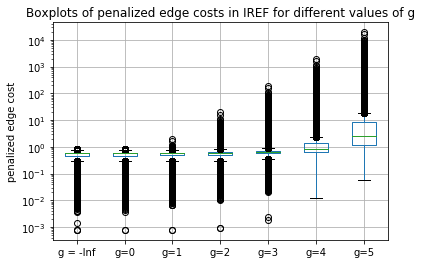

In [13]:
# Boxplot of edge costs under several choices of g
plt.figure()
edge_costs_df.boxplot()
plt.yscale('log')
plt.ylabel('penalized edge cost')
plt.title('Boxplots of penalized edge costs in IREF for different values of g')
plt.show()

## B range

In [14]:
# For a range of g, compute the maximum penalized edge cost
g_range = [0,1,2,3,4,5]
max_penalized_edge_cost = pd.DataFrame(edge_costs_df.max())
max_penalized_edge_cost.columns=['max_penalized_edge_cost']
max_penalized_edge_cost

,max_penalized_edge_cost
g = -Inf,0.859220
g=0,0.860892
g=1,2.015303
g=2,19.487738
g=3,194.212079
g=4,1941.455488
g=5,19413.889586


# Sensitivity analysis for Steiner tree parameters

## Run sensitivity analysis

In [15]:
# Load set of virus interacting genes from Gordon et al.
virus_partners_file_name = "../Data/SARSCov_targets_df.tsv"
virus_interacting_genes = sensitivity.import_virus_partners(virus_partners_file_name)

In [16]:
# Parameters for sensitivity analysis
interactome_file_name = "../Data/iRefIndex_v14_MIScore_interactome_C9.costs.allcaps.txt"
prize_file_name = "../Save_RandomizeTerminals/terminals_ppi_analysis.tsv"
# Graph hyperparameters
graph_params =  {
                "noise": 0.0, 
                "dummy_mode": "terminals", 
                "exclude_terminals": False, 
                "seed": 1,
                "pruning": 'strong',
                "verbosity_level": 0
                }
# Set sweeping parameters, i.e. configurations (w,b,g)
W_list = np.linspace(start = 0.2, stop = 2, num = 10)
B_list = np.array([5., 10., 15., 20., 25., 30., 35., 40., 45., 50.])

In [19]:
# Run sensitivity analysis
networks_dict = sensitivity.run_sensitivity_analysis(interactome_file_name, 
                                                     prize_file_name, 
                                                     graph_params, 
                                                     W_list, 
                                                     B_list, 
                                                     G=0)

07:54:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:54:46 - OI2: INFO - []
07:54:46 - OI2: INFO - Members of the prize file not present in the interactome:
07:54:46 - OI2: INFO - []


Progress= 0.01


07:54:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:54:47 - OI2: INFO - []
07:54:47 - OI2: INFO - Members of the prize file not present in the interactome:
07:54:47 - OI2: INFO - []


Progress= 0.02


07:54:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:54:48 - OI2: INFO - []
07:54:48 - OI2: INFO - Members of the prize file not present in the interactome:
07:54:48 - OI2: INFO - []


Progress= 0.03


07:54:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:54:49 - OI2: INFO - []
07:54:49 - OI2: INFO - Members of the prize file not present in the interactome:
07:54:49 - OI2: INFO - []


Progress= 0.04


07:54:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:54:50 - OI2: INFO - []
07:54:50 - OI2: INFO - Members of the prize file not present in the interactome:
07:54:50 - OI2: INFO - []


Progress= 0.05


07:54:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:54:51 - OI2: INFO - []
07:54:51 - OI2: INFO - Members of the prize file not present in the interactome:
07:54:51 - OI2: INFO - []


Progress= 0.06


07:54:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:54:51 - OI2: INFO - []
07:54:51 - OI2: INFO - Members of the prize file not present in the interactome:
07:54:51 - OI2: INFO - []


Progress= 0.07


07:54:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:54:52 - OI2: INFO - []
07:54:52 - OI2: INFO - Members of the prize file not present in the interactome:
07:54:52 - OI2: INFO - []


Progress= 0.08


07:54:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:54:53 - OI2: INFO - []
07:54:53 - OI2: INFO - Members of the prize file not present in the interactome:
07:54:53 - OI2: INFO - []


Progress= 0.09


07:54:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:54:54 - OI2: INFO - []
07:54:54 - OI2: INFO - Members of the prize file not present in the interactome:
07:54:54 - OI2: INFO - []


Progress= 0.1


07:54:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:54:55 - OI2: INFO - []
07:54:55 - OI2: INFO - Members of the prize file not present in the interactome:
07:54:55 - OI2: INFO - []


Progress= 0.11


07:54:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:54:56 - OI2: INFO - []
07:54:56 - OI2: INFO - Members of the prize file not present in the interactome:
07:54:56 - OI2: INFO - []


Progress= 0.12


07:54:57 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:54:57 - OI2: INFO - []
07:54:57 - OI2: INFO - Members of the prize file not present in the interactome:
07:54:57 - OI2: INFO - []


Progress= 0.13


07:54:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:54:58 - OI2: INFO - []
07:54:58 - OI2: INFO - Members of the prize file not present in the interactome:
07:54:58 - OI2: INFO - []


Progress= 0.14


07:54:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:54:59 - OI2: INFO - []
07:54:59 - OI2: INFO - Members of the prize file not present in the interactome:
07:54:59 - OI2: INFO - []


Progress= 0.15


07:55:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:00 - OI2: INFO - []
07:55:00 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:00 - OI2: INFO - []


Progress= 0.16


07:55:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:01 - OI2: INFO - []
07:55:01 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:01 - OI2: INFO - []


Progress= 0.17


07:55:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:02 - OI2: INFO - []
07:55:02 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:02 - OI2: INFO - []


Progress= 0.18


07:55:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:04 - OI2: INFO - []
07:55:04 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:04 - OI2: INFO - []


Progress= 0.19


07:55:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:05 - OI2: INFO - []
07:55:05 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:05 - OI2: INFO - []


Progress= 0.2


07:55:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:06 - OI2: INFO - []
07:55:06 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:06 - OI2: INFO - []


Progress= 0.21


07:55:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:07 - OI2: INFO - []
07:55:07 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:07 - OI2: INFO - []


Progress= 0.22


07:55:08 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:08 - OI2: INFO - []
07:55:08 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:08 - OI2: INFO - []


Progress= 0.23


07:55:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:09 - OI2: INFO - []
07:55:09 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:09 - OI2: INFO - []


Progress= 0.24


07:55:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:11 - OI2: INFO - []
07:55:11 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:11 - OI2: INFO - []


Progress= 0.25


07:55:12 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:12 - OI2: INFO - []
07:55:12 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:12 - OI2: INFO - []


Progress= 0.26


07:55:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:13 - OI2: INFO - []
07:55:13 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:13 - OI2: INFO - []


Progress= 0.27


07:55:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:14 - OI2: INFO - []
07:55:14 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:14 - OI2: INFO - []


Progress= 0.28


07:55:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:16 - OI2: INFO - []
07:55:16 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:16 - OI2: INFO - []


Progress= 0.29


07:55:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:17 - OI2: INFO - []
07:55:17 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:17 - OI2: INFO - []


Progress= 0.3


07:55:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:18 - OI2: INFO - []
07:55:18 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:18 - OI2: INFO - []


Progress= 0.31


07:55:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:19 - OI2: INFO - []
07:55:19 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:19 - OI2: INFO - []


Progress= 0.32


07:55:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:20 - OI2: INFO - []
07:55:20 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:20 - OI2: INFO - []


Progress= 0.33


07:55:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:21 - OI2: INFO - []
07:55:21 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:21 - OI2: INFO - []


Progress= 0.34


07:55:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:23 - OI2: INFO - []
07:55:23 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:23 - OI2: INFO - []


Progress= 0.35


07:55:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:24 - OI2: INFO - []
07:55:24 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:24 - OI2: INFO - []


Progress= 0.36


07:55:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:25 - OI2: INFO - []
07:55:25 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:25 - OI2: INFO - []


Progress= 0.37


07:55:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:26 - OI2: INFO - []
07:55:26 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:26 - OI2: INFO - []


Progress= 0.38


07:55:27 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:27 - OI2: INFO - []
07:55:27 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:27 - OI2: INFO - []


Progress= 0.39


07:55:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:29 - OI2: INFO - []
07:55:29 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:29 - OI2: INFO - []


Progress= 0.4


07:55:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:30 - OI2: INFO - []
07:55:30 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:30 - OI2: INFO - []


Progress= 0.41


07:55:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:31 - OI2: INFO - []
07:55:31 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:31 - OI2: INFO - []


Progress= 0.42


07:55:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:32 - OI2: INFO - []
07:55:32 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:32 - OI2: INFO - []


Progress= 0.43


07:55:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:33 - OI2: INFO - []
07:55:33 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:33 - OI2: INFO - []


Progress= 0.44


07:55:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:35 - OI2: INFO - []
07:55:35 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:35 - OI2: INFO - []


Progress= 0.45


07:55:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:36 - OI2: INFO - []
07:55:36 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:36 - OI2: INFO - []


Progress= 0.46


07:55:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:37 - OI2: INFO - []
07:55:37 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:37 - OI2: INFO - []


Progress= 0.47


07:55:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:38 - OI2: INFO - []
07:55:38 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:38 - OI2: INFO - []


Progress= 0.48


07:55:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:39 - OI2: INFO - []
07:55:39 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:39 - OI2: INFO - []


Progress= 0.49


07:55:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:41 - OI2: INFO - []
07:55:41 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:41 - OI2: INFO - []


Progress= 0.5


07:55:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:42 - OI2: INFO - []
07:55:42 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:42 - OI2: INFO - []


Progress= 0.51


07:55:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:43 - OI2: INFO - []
07:55:43 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:43 - OI2: INFO - []


Progress= 0.52


07:55:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:44 - OI2: INFO - []
07:55:44 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:44 - OI2: INFO - []


Progress= 0.53


07:55:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:46 - OI2: INFO - []
07:55:46 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:46 - OI2: INFO - []


Progress= 0.54


07:55:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:47 - OI2: INFO - []
07:55:47 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:47 - OI2: INFO - []


Progress= 0.55


07:55:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:48 - OI2: INFO - []
07:55:48 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:48 - OI2: INFO - []


Progress= 0.56


07:55:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:49 - OI2: INFO - []
07:55:49 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:49 - OI2: INFO - []


Progress= 0.57


07:55:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:50 - OI2: INFO - []
07:55:50 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:50 - OI2: INFO - []


Progress= 0.58


07:55:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:52 - OI2: INFO - []
07:55:52 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:52 - OI2: INFO - []


Progress= 0.59


07:55:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:53 - OI2: INFO - []
07:55:53 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:53 - OI2: INFO - []


Progress= 0.6


07:55:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:54 - OI2: INFO - []
07:55:54 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:54 - OI2: INFO - []


Progress= 0.61


07:55:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:55 - OI2: INFO - []
07:55:55 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:55 - OI2: INFO - []


Progress= 0.62


07:55:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:56 - OI2: INFO - []
07:55:56 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:56 - OI2: INFO - []


Progress= 0.63


07:55:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:58 - OI2: INFO - []
07:55:58 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:58 - OI2: INFO - []


Progress= 0.64


07:55:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:55:59 - OI2: INFO - []
07:55:59 - OI2: INFO - Members of the prize file not present in the interactome:
07:55:59 - OI2: INFO - []


Progress= 0.65


07:56:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:56:00 - OI2: INFO - []
07:56:00 - OI2: INFO - Members of the prize file not present in the interactome:
07:56:00 - OI2: INFO - []


Progress= 0.66


07:56:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:56:01 - OI2: INFO - []
07:56:01 - OI2: INFO - Members of the prize file not present in the interactome:
07:56:01 - OI2: INFO - []


Progress= 0.67


07:56:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:56:03 - OI2: INFO - []
07:56:03 - OI2: INFO - Members of the prize file not present in the interactome:
07:56:03 - OI2: INFO - []


Progress= 0.68


07:56:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:56:04 - OI2: INFO - []
07:56:04 - OI2: INFO - Members of the prize file not present in the interactome:
07:56:04 - OI2: INFO - []


Progress= 0.69


07:56:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:56:05 - OI2: INFO - []
07:56:05 - OI2: INFO - Members of the prize file not present in the interactome:
07:56:05 - OI2: INFO - []


Progress= 0.7


07:56:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:56:06 - OI2: INFO - []
07:56:06 - OI2: INFO - Members of the prize file not present in the interactome:
07:56:06 - OI2: INFO - []


Progress= 0.71


07:56:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:56:07 - OI2: INFO - []
07:56:07 - OI2: INFO - Members of the prize file not present in the interactome:
07:56:07 - OI2: INFO - []


Progress= 0.72


07:56:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:56:09 - OI2: INFO - []
07:56:09 - OI2: INFO - Members of the prize file not present in the interactome:
07:56:09 - OI2: INFO - []


Progress= 0.73


07:56:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:56:10 - OI2: INFO - []
07:56:10 - OI2: INFO - Members of the prize file not present in the interactome:
07:56:10 - OI2: INFO - []


Progress= 0.74


07:56:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:56:11 - OI2: INFO - []
07:56:11 - OI2: INFO - Members of the prize file not present in the interactome:
07:56:11 - OI2: INFO - []


Progress= 0.75


07:56:12 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:56:12 - OI2: INFO - []
07:56:12 - OI2: INFO - Members of the prize file not present in the interactome:
07:56:12 - OI2: INFO - []


Progress= 0.76


07:56:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:56:14 - OI2: INFO - []
07:56:14 - OI2: INFO - Members of the prize file not present in the interactome:
07:56:14 - OI2: INFO - []


Progress= 0.77


07:56:15 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:56:15 - OI2: INFO - []
07:56:15 - OI2: INFO - Members of the prize file not present in the interactome:
07:56:15 - OI2: INFO - []


Progress= 0.78


07:56:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:56:16 - OI2: INFO - []
07:56:16 - OI2: INFO - Members of the prize file not present in the interactome:
07:56:16 - OI2: INFO - []


Progress= 0.79


07:56:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:56:17 - OI2: INFO - []
07:56:17 - OI2: INFO - Members of the prize file not present in the interactome:
07:56:17 - OI2: INFO - []


Progress= 0.8


07:56:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:56:18 - OI2: INFO - []
07:56:18 - OI2: INFO - Members of the prize file not present in the interactome:
07:56:18 - OI2: INFO - []


Progress= 0.81


07:56:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:56:20 - OI2: INFO - []
07:56:20 - OI2: INFO - Members of the prize file not present in the interactome:
07:56:20 - OI2: INFO - []


Progress= 0.82


07:56:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:56:21 - OI2: INFO - []
07:56:21 - OI2: INFO - Members of the prize file not present in the interactome:
07:56:21 - OI2: INFO - []


Progress= 0.83


07:56:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:56:22 - OI2: INFO - []
07:56:22 - OI2: INFO - Members of the prize file not present in the interactome:
07:56:22 - OI2: INFO - []


Progress= 0.84


07:56:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:56:23 - OI2: INFO - []
07:56:23 - OI2: INFO - Members of the prize file not present in the interactome:
07:56:23 - OI2: INFO - []


Progress= 0.85


07:56:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:56:25 - OI2: INFO - []
07:56:25 - OI2: INFO - Members of the prize file not present in the interactome:
07:56:25 - OI2: INFO - []


Progress= 0.86


07:56:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:56:26 - OI2: INFO - []
07:56:26 - OI2: INFO - Members of the prize file not present in the interactome:
07:56:26 - OI2: INFO - []


Progress= 0.87


07:56:27 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:56:27 - OI2: INFO - []
07:56:27 - OI2: INFO - Members of the prize file not present in the interactome:
07:56:27 - OI2: INFO - []


Progress= 0.88


07:56:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:56:28 - OI2: INFO - []
07:56:28 - OI2: INFO - Members of the prize file not present in the interactome:
07:56:28 - OI2: INFO - []


Progress= 0.89


07:56:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:56:29 - OI2: INFO - []
07:56:29 - OI2: INFO - Members of the prize file not present in the interactome:
07:56:29 - OI2: INFO - []


Progress= 0.9


07:56:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:56:31 - OI2: INFO - []
07:56:31 - OI2: INFO - Members of the prize file not present in the interactome:
07:56:31 - OI2: INFO - []


Progress= 0.91


07:56:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:56:32 - OI2: INFO - []
07:56:32 - OI2: INFO - Members of the prize file not present in the interactome:
07:56:32 - OI2: INFO - []


Progress= 0.92


07:56:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:56:33 - OI2: INFO - []
07:56:33 - OI2: INFO - Members of the prize file not present in the interactome:
07:56:33 - OI2: INFO - []


Progress= 0.93


07:56:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:56:34 - OI2: INFO - []
07:56:34 - OI2: INFO - Members of the prize file not present in the interactome:
07:56:34 - OI2: INFO - []


Progress= 0.94


07:56:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:56:36 - OI2: INFO - []
07:56:36 - OI2: INFO - Members of the prize file not present in the interactome:
07:56:36 - OI2: INFO - []


Progress= 0.95


07:56:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:56:37 - OI2: INFO - []
07:56:37 - OI2: INFO - Members of the prize file not present in the interactome:
07:56:37 - OI2: INFO - []


Progress= 0.96


07:56:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:56:38 - OI2: INFO - []
07:56:38 - OI2: INFO - Members of the prize file not present in the interactome:
07:56:38 - OI2: INFO - []


Progress= 0.97


07:56:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:56:39 - OI2: INFO - []
07:56:39 - OI2: INFO - Members of the prize file not present in the interactome:
07:56:39 - OI2: INFO - []


Progress= 0.98


07:56:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:56:41 - OI2: INFO - []
07:56:41 - OI2: INFO - Members of the prize file not present in the interactome:
07:56:41 - OI2: INFO - []


Progress= 0.99


07:56:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:56:42 - OI2: INFO - []
07:56:42 - OI2: INFO - Members of the prize file not present in the interactome:
07:56:42 - OI2: INFO - []


Progress= 1.0


In [20]:
# Save as pickle
with open("../Save_RandomizeTerminals/networks_dict.pkl", "wb") as f: 
    pickle.dump(networks_dict, f)

In [17]:
# Add metatadata
networks_dict = pickle.load(open("../Save_RandomizeTerminals/networks_dict.pkl", "rb"))
networks_dict = sensitivity.add_metadata(networks_dict, virus_interacting_genes)

In [18]:
# Make summary
networks_summary_df = sensitivity.make_summary(networks_dict, n_terminals, g=0)
networks_summary_df.head()

,index,w,b,g,nodes,edges,number_components,size_components,percentage_terminals,upregulated_terminals,downregulated_terminals,number_transcription_regulators,transcription_regulators,number_of_proteins_interacting_sars,proteins_interacting_sars
w_0.2_b_10.0,1,0.2,10.0,0,169,281,30,"[140, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",0.973333,60,86,5,"[RFXAP, SHOX2, SLC30A9, ZNF254, ZNF30]",5,"[NDFIP2, RIPK1, SLC25A21, SLC30A9, TBK1]"
w_0.2_b_15.0,2,0.2,15.0,0,170,281,31,"[140, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",0.980000,61,86,5,"[RFXAP, SHOX2, SLC30A9, ZNF254, ZNF30]",5,"[NDFIP2, RIPK1, SLC25A21, SLC30A9, TBK1]"
w_0.2_b_20.0,3,0.2,20.0,0,172,283,32,"[141, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",0.993333,63,86,5,"[RFXAP, SHOX2, SLC30A9, ZNF254, ZNF30]",5,"[NDFIP2, RIPK1, SLC25A21, SLC30A9, TBK1]"
w_0.2_b_25.0,4,0.2,25.0,0,172,283,32,"[141, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",0.993333,63,86,5,"[RFXAP, SHOX2, SLC30A9, ZNF254, ZNF30]",5,"[NDFIP2, RIPK1, SLC25A21, SLC30A9, TBK1]"
w_0.2_b_30.0,5,0.2,30.0,0,172,283,32,"[141, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",0.993333,63,86,5,"[RFXAP, SHOX2, SLC30A9, ZNF254, ZNF30]",5,"[NDFIP2, RIPK1, SLC25A21, SLC30A9, TBK1]"


## Plot node stability heatmaps

<Figure size 432x288 with 0 Axes>

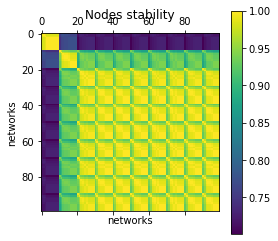

In [19]:
# Stability of selected nodes
mat_allnodes = sensitivity.create_matrix_gene_overlap_between_networks(networks_summary_df, networks_dict)
plt.figure()
plt.matshow(mat_allnodes)
plt.xlabel('networks')
plt.ylabel('networks')
plt.title('Nodes stability')
plt.colorbar()
plt.show()

<Figure size 432x288 with 0 Axes>

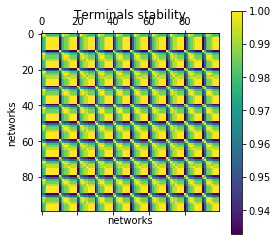

In [17]:
# Stability of selected terminals
mat_terminals = sensitivity.create_matrix_terminal_overlap_between_networks(networks_summary_df, networks_dict)
plt.figure()
plt.matshow(mat_terminals)
plt.xlabel('networks')
plt.ylabel('networks')
plt.title('Terminals stability')
plt.colorbar()
plt.show()

<Figure size 432x288 with 0 Axes>

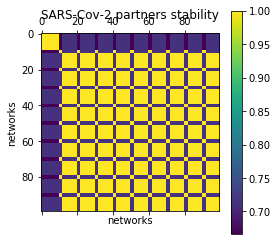

In [18]:
# Stability of selected SARS-Cov-2 partners
mat_sars = sensitivity.create_matrix_sars_overlap_between_networks(networks_summary_df, networks_dict)
plt.figure()
plt.matshow(mat_sars)
plt.xlabel('networks')
plt.ylabel('networks')
plt.title('SARS-Cov-2 partners stability')
plt.colorbar()
plt.show()

## Select robust parameters

In [20]:
# Select network corresponding to g=0, w=1.4 and b=40
index_selected = 67
paramstring_selected = networks_summary_df[networks_summary_df['index']==index_selected].index[0]
network_selected = networks_dict[paramstring_selected]

In [21]:
# Save selected network to file
oi.output_networkx_graph_as_interactive_html(network_selected, filename="../Save_RandomizeTerminals/network_selected.html")
oi.output_networkx_graph_as_pickle(network_selected, filename= '../Save_RandomizeTerminals/network_selected.pickle')
#oi.output_networkx_graph_as_graphml_for_cytoscape(robust_network, filename= '../Save_RandomizeTerminals/network_selected.graphml')

PosixPath('/home/louiscam/projects/sars_cov_2/Save_RandomizeTerminals/network_selected.pickle')

# Sensitivity analysis for virus partners prize

## Run sensitivity analysis

In [19]:
# Identify which SARS-Cov-2 partners are in the terminal list
terminal_partners = set(terminals).intersection(virus_interacting_genes)
print(terminal_partners)

{'TBK1', 'SLC25A21', 'SLC30A9', 'NDFIP2'}


In [25]:
# Run sensitivity analysis
interactome_file_name = "../Data/iRefIndex_v14_MIScore_interactome_C9.costs.allcaps.txt"
prize_file_name = "../Save_RandomizeTerminals/terminals_ppi_analysis.tsv"
# Graph hyperparameters
graph_params =  {
                "noise": 0.0, 
                "dummy_mode": "terminals", 
                "exclude_terminals": False, 
                "seed": 1,
                "pruning": 'strong',
                "verbosity_level": 0,
                "w": 1.4,
                "b": 40,
                "g": 0
                }
# List of values of P
P_list = np.arange(0,0.0016,0.0001)

networks_dict = svp.run_prize_sensitivity_analysis(interactome_file_name, 
                                                   prize_file_name, 
                                                   graph_params, 
                                                   virus_interacting_genes, 
                                                   terminal_partners, 
                                                   P_list)

11:57:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:57:42 - OI2: INFO - []
11:57:42 - OI2: INFO - Members of the prize file not present in the interactome:
11:57:42 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.0625


11:57:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:57:43 - OI2: INFO - []
11:57:43 - OI2: INFO - Members of the prize file not present in the interactome:
11:57:43 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.125


11:57:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:57:45 - OI2: INFO - []
11:57:45 - OI2: INFO - Members of the prize file not present in the interactome:
11:57:45 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.1875


11:57:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:57:47 - OI2: INFO - []
11:57:47 - OI2: INFO - Members of the prize file not present in the interactome:
11:57:47 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.25


11:57:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:57:48 - OI2: INFO - []
11:57:48 - OI2: INFO - Members of the prize file not present in the interactome:
11:57:48 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.3125


11:57:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:57:50 - OI2: INFO - []
11:57:50 - OI2: INFO - Members of the prize file not present in the interactome:
11:57:50 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.375


11:57:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:57:51 - OI2: INFO - []
11:57:51 - OI2: INFO - Members of the prize file not present in the interactome:
11:57:51 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.4375


11:57:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:57:53 - OI2: INFO - []
11:57:53 - OI2: INFO - Members of the prize file not present in the interactome:
11:57:53 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.5


11:57:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:57:54 - OI2: INFO - []
11:57:54 - OI2: INFO - Members of the prize file not present in the interactome:
11:57:54 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.5625


11:57:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:57:56 - OI2: INFO - []
11:57:56 - OI2: INFO - Members of the prize file not present in the interactome:
11:57:56 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.625


11:57:57 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:57:57 - OI2: INFO - []
11:57:57 - OI2: INFO - Members of the prize file not present in the interactome:
11:57:57 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.6875


11:57:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:57:59 - OI2: INFO - []
11:57:59 - OI2: INFO - Members of the prize file not present in the interactome:
11:57:59 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.75


11:58:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:58:00 - OI2: INFO - []
11:58:00 - OI2: INFO - Members of the prize file not present in the interactome:
11:58:00 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.8125


11:58:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:58:02 - OI2: INFO - []
11:58:02 - OI2: INFO - Members of the prize file not present in the interactome:
11:58:02 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.875


11:58:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:58:04 - OI2: INFO - []
11:58:04 - OI2: INFO - Members of the prize file not present in the interactome:
11:58:04 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.9375


11:58:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:58:05 - OI2: INFO - []
11:58:05 - OI2: INFO - Members of the prize file not present in the interactome:
11:58:05 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 1.0


In [26]:
# Save as pickle
with open("../Save_RandomizeTerminals/networks_dict_sarspartners.pkl", "wb") as f: 
    pickle.dump(networks_dict, f)

In [27]:
# Add metadata
networks_dict = pickle.load(open("../Save_RandomizeTerminals/networks_dict_sarspartners.pkl", "rb"))
networks_dict = svp.add_metadata(networks_dict, virus_interacting_genes)

In [28]:
# Make summary
networks_summary_df = svp.make_summary(networks_dict, n_terminals)
networks_summary_df.head()

,index,p,nodes,edges,number_components,size_components,percentage_terminals,transcription_regulators,number_of_proteins_interacting_sars,proteins_interacting_sars
p_0.0,0,0.0,236,962,1,[236],0.993333,"[GRHL3, RFXAP, SHOX2, SLC30A9, ZNF254, ZNF30]",7,"[HDAC2, NDFIP2, RBX1, RIPK1, SLC25A21, SLC30A9..."
p_0.0001,1,0.0001,236,962,1,[236],0.993333,"[GRHL3, RFXAP, SHOX2, SLC30A9, ZNF254, ZNF30]",7,"[HDAC2, NDFIP2, RBX1, RIPK1, SLC25A21, SLC30A9..."
p_0.0002,2,0.0002,236,962,1,[236],0.993333,"[GRHL3, RFXAP, SHOX2, SLC30A9, ZNF254, ZNF30]",7,"[HDAC2, NDFIP2, RBX1, RIPK1, SLC25A21, SLC30A9..."
p_0.00030000000000000003,3,0.00030000000000000003,236,958,1,[236],0.993333,"[GRHL3, RFXAP, SHOX2, SLC30A9, ZNF254, ZNF30]",8,"[CUL2, HDAC2, NDFIP2, RBX1, RIPK1, SLC25A21, S..."
p_0.0004,4,0.0004,236,918,1,[236],0.993333,"[GRHL3, RFXAP, SHOX2, SLC30A9, ZNF254, ZNF30]",11,"[AKAP8L, CSNK2B, CUL2, HDAC2, IMPDH2, NDFIP2, ..."


## Plot number of SARS-Cov-2 partners picked up versus p

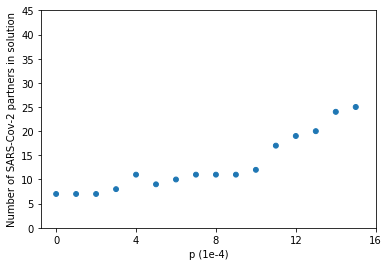

In [29]:
plt.figure()
plt.scatter(x = networks_summary_df['p'], 
            y = networks_summary_df['number_of_proteins_interacting_sars'],
            s = 0.1*networks_summary_df['nodes'])
plt.xlabel('p (1e-4)')
plt.ylabel('Number of SARS-Cov-2 partners in solution')
plt.xticks(np.arange(0,17,4),['0','4','8','12','16'])
plt.yticks(np.arange(0,50,5))
plt.show()

## Plot node stability heatmaps

<Figure size 432x288 with 0 Axes>

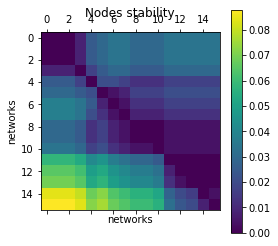

In [30]:
# Stability of selected nodes
mat_allnodes = svp.create_matrix_gene_overlap_between_networks(networks_summary_df, networks_dict)
plt.figure()
plt.matshow(mat_allnodes)
plt.xlabel('networks')
plt.ylabel('networks')
plt.title('Nodes stability')
plt.colorbar()
plt.show()

<Figure size 432x288 with 0 Axes>

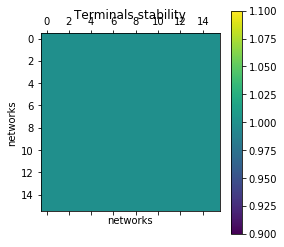

In [31]:
# Stability of selected terminals
mat_terminals = svp.create_matrix_terminal_overlap_between_networks(networks_summary_df, networks_dict)
plt.figure()
plt.matshow(mat_terminals)
plt.xlabel('networks')
plt.ylabel('networks')
plt.title('Terminals stability')
plt.colorbar()
plt.show()

<Figure size 432x288 with 0 Axes>

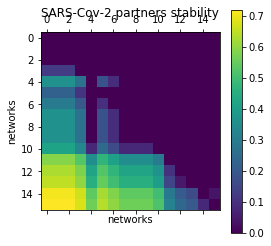

In [32]:
# Stability of selected SARS-Cov-2 partners
mat_sars = svp.create_matrix_sars_overlap_between_networks(networks_summary_df, networks_dict)
plt.figure()
plt.matshow(mat_sars)
plt.xlabel('networks')
plt.ylabel('networks')
plt.title('SARS-Cov-2 partners stability')
plt.colorbar()
plt.show()

## Select robust parameters

In [18]:
# Save network
index_selected = 8
paramstring_selected = networks_summary_df[networks_summary_df['index']==index_selected].index[0]
network_selected2 = networks_dict[paramstring_selected]

In [19]:
# Save selected network to file
oi.output_networkx_graph_as_interactive_html(network_selected2, filename="../Save_RandomizeTerminals/network_selected_sarspartners.html")
oi.output_networkx_graph_as_pickle(network_selected2, filename= '../Save_RandomizeTerminals/network_selected_sarspartners.pickle')
#oi.output_networkx_graph_as_graphml_for_cytoscape(network_selected, filename= r'../Save_RandomizeTerminals/network_selected_sarspartners.graphml')

PosixPath('/home/louiscam/projects/sars_cov_2/Save_RandomizeTerminals/network_selected_sarspartners.pickle')

# Add drug targets to selected network

## Construct drug/target data

In [22]:
# Compute degree centrality for all nodes in the interactome
graph = oi.Graph(interactome_file_name)
centrality_dic = nx.degree_centrality(graph.interactome_graph)

In [23]:
# Load drug/target data from DrugCentral
drug_target_file_name = '../Data/drug.target.interaction.tsv'
drugcentral_df = drugs2.load_drug_target_data(drug_target_file_name, aff_cst_thresh=5)
# Add degree centrality of gene target and drop drug/target pairs with no affinity constant information
drugcentral_df['degree_centrality'] = [centrality_dic[gene] if (gene in list(centrality_dic.keys())) else None for gene in drugcentral_df['gene']]
drugcentral_df.dropna(axis=0, subset=['affinity_constant'], inplace=True)
drugcentral_df.head()

,gene,drug,protein_target,affinity_constant,affinity_constant_type,degree_centrality
1,CYP2D6,levobupivacaine,Cytochrome P450 2D6,6.706859,IC50,NaN
5,SCN1A,levobupivacaine,Sodium channel protein type 1 subunit alpha,5.790000,IC50,0.000254
9,KCNN4,(s)-nitrendipine,Intermediate conductance calcium-activated pot...,7.600000,IC50,0.000444
10,CACNA1F,(s)-nitrendipine,Voltage-dependent L-type calcium channel subun...,6.000000,IC50,0.000127
13,CACNA1D,(s)-nitrendipine,Voltage-dependent L-type calcium channel subun...,8.400000,IC50,0.000254


In [24]:
# Compute total number of tyrosine kinase inhibitors (tinib suffix)
tinib_drugs = np.unique(drugcentral_df.set_index('drug').filter(like='tinib', axis=0).index)
len(tinib_drugs)

47

In [25]:
# Construct table that gives the number of targets per drug
num_targets_df0 = drugcentral_df.groupby('drug', as_index=False)[['gene']].agg({
    ('num_targets','count'),
    ('num_terminal_targets',lambda gs: len(set(gs).intersection(set(terminals))))
})
max_centrality_df0 = drugcentral_df.groupby('drug', as_index=False)[['degree_centrality']].agg({
    ('max_degree_centrality',max)
})
num_targets_df = pd.DataFrame({'drug': num_targets_df0.index,
                               'num_targets': num_targets_df0['gene']['num_targets'],
                               'num_terminal_targets': num_targets_df0['gene']['num_terminal_targets'],
                               'max_target_centrality': max_centrality_df0['degree_centrality']['max_degree_centrality']}).reset_index(drop=True)
num_targets_df = num_targets_df.sort_values(by='num_targets', ascending=False, inplace=False)
num_targets_df.head(10)

,drug,num_targets,num_terminal_targets,max_target_centrality
1399,sunitinib,260,2,0.055718
1039,nintedanib,218,2,0.037187
951,midostaurin,204,2,0.055718
189,bosutinib,203,2,0.055718
363,crizotinib,148,2,0.055718
1319,ruxolitinib,132,2,0.027224
393,dasatinib,128,0,0.055718
1315,ruboxistaurin,121,2,0.055718
1368,sorafenib,116,0,0.037187
1562,vandetanib,109,0,0.055718


In [26]:
# Load L1000 drugs with correlations
embedded_drugs_file_name = '../Data/final_A549_drug_correlations.csv'
bestdrugs_df = drugs2.load_embedded_drugs(embedded_drugs_file_name, lower_corr_thresh=0.86)
bestdrugs_df.head()

,drug,corr
0,doxapram,0.882798
1,dasatinib,0.882561
2,cyproheptadine,0.882541
3,ribavirin,0.881823
4,ethambutol,0.881799


In [27]:
# Merge L1000 drugs with DrugCentral drug/target dataset
targets_and_drugs_df = drugcentral_df.merge(bestdrugs_df, on = 'drug', how = 'inner')
targets_and_drugs_df.head()

,gene,drug,protein_target,affinity_constant,affinity_constant_type,degree_centrality,corr
0,CYP19A1,aminoglutethimide,Aromatase,5.110000,IC50,0.000063,0.860848
1,ADRA2A,amitriptyline,Alpha-2A adrenergic receptor,6.879426,Ki,0.000762,0.872172
2,ADRA2C,amitriptyline,Alpha-2C adrenergic receptor,8.065502,Ki,0.000254,0.872172
3,ADRA1D,amitriptyline,Alpha-1D adrenergic receptor,8.251812,Ki,0.001015,0.872172
4,SCN5A,amitriptyline,Sodium channel protein type 5 subunit alpha,5.800000,IC50,0.001777,0.872172


## Add drug target information to selected network

In [28]:
network_selected = pickle.load(open('../Save_RandomizeTerminals/network_selected.pickle', "rb"))
network_selected = drugs2.add_drug_info_to_selected_network(network_selected, targets_and_drugs_df)
# Save enriched network as pickle
oi.output_networkx_graph_as_pickle(network_selected, filename= '../Save_RandomizeTerminals/network_selected_with_drug_info.pickle')

PosixPath('/home/louiscam/projects/sars_cov_2/Save_RandomizeTerminals/network_selected_with_drug_info.pickle')

In [29]:
# Construct table of drug targets in the network
drug_targets_df = drugs2.drug_targets_in_selected_network(network_selected)
drug_targets_df.to_csv(r'../Save_RandomizeTerminals/drug_targets_in_network.tsv', header=True, index=None, sep='\t', quoting = csv.QUOTE_NONE, escapechar = '\t')
drug_targets_df['affinity'] = pd.to_numeric(drug_targets_df['affinity'], errors='coerce')
drug_targets_df.dropna(subset=['affinity'], inplace=True)
drug_targets_df

,name,protein_target,drug,corr,affinity
CDK2,CDK2,"{CDK2/Cyclin A, Cyclin-dependent kinase 2}",sorafenib,0.86517066,5.060000
CDK2,CDK2,"{CDK2/Cyclin A, Cyclin-dependent kinase 2}",palbociclib,0.86293995,6.640000
CDK4,CDK4,"{Cyclin-dependent kinase 4/cyclin D1, Cyclin-d...",sunitinib,0.8685898,5.700000
CDK4,CDK4,"{Cyclin-dependent kinase 4/cyclin D1, Cyclin-d...",palbociclib,0.86293995,7.958607
CDK4,CDK4,"{Cyclin-dependent kinase 4/cyclin D1, Cyclin-d...",palbociclib,0.86293995,8.700000
CDK7,CDK7,{Cyclin-dependent kinase 7},sorafenib,0.86517066,6.850000
CDK7,CDK7,{Cyclin-dependent kinase 7},sunitinib,0.8685898,6.480000
CDK7,CDK7,{Cyclin-dependent kinase 7},ruxolitinib,0.87487674,5.480000
CDK7,CDK7,{Cyclin-dependent kinase 7},bosutinib,0.86295736,5.920000
CLK2,CLK2,{Dual specificity protein kinase CLK2},sunitinib,0.8685898,7.700000


In [30]:
# Save drug/target dataframe to csv
drug_targets_df.to_csv(r'../Save_RandomizeTerminals/final_drug_target_table.tsv', header=True, index=None, sep='\t', quoting = csv.QUOTE_NONE, escapechar = '\t')

# Compare to non-randomized analysis

In [31]:
# Drug/target dataframe in the non-randomized case
drug_targets_df_norandom_file_name = '../Save/final_drug_target_table.tsv'
drug_targets_df_norandom = pd.read_csv(drug_targets_df_norandom_file_name, sep = '\t')
drug_targets_df_norandom

,name,protein_target,drug,corr,affinity
0,ACVR2A,{'Activin receptor type-2A'},dasatinib,0.882561,6.6800
1,AURKC,{'Aurora kinase C'},erlotinib,0.873780,6.2200
2,AURKC,{'Aurora kinase C'},sorafenib,0.865171,6.6800
3,AURKC,{'Aurora kinase C'},sunitinib,0.868590,6.6600
4,AURKC,{'Aurora kinase C'},pazopanib,0.866959,6.1200
5,AURKC,{'Aurora kinase C'},ruxolitinib,0.874877,5.0600
6,AURKC,{'Aurora kinase C'},axitinib,0.877977,8.8900
7,BRSK1,{'Serine/threonine-protein kinase BRSK1'},sunitinib,0.868590,5.4600
8,CDK17,{'Cyclin-dependent kinase 17'},sorafenib,0.865171,5.8000
9,CDK17,{'Cyclin-dependent kinase 17'},sunitinib,0.868590,5.9200


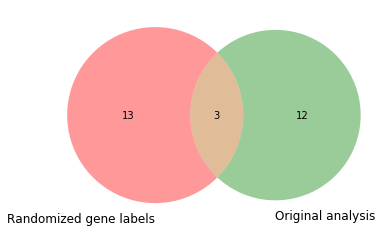

In [32]:
# Common gene targets
targets_random = set(drug_targets_df['name'])
targets_norandom = set(drug_targets_df_norandom['name'])
venn2(subsets = [targets_random,targets_norandom],set_labels = ('Randomized gene labels','Original analysis'))

            drug  num_targets  num_terminal_targets  max_target_centrality
1563  vardenafil           13                     0               0.002538
957    milrinone            9                     0               0.002538
652   formoterol            5                     0               0.049054
1213  primaquine            5                     0               0.049054
             drug  num_targets  num_terminal_targets  max_target_centrality
1381  sulconazole           25                     0               0.018721
1405   tacrolimus           13                     1               0.008884
1106  palbociclib           13                     0               0.037187
333   clofarabine            2                     1               0.002031
             drug  num_targets  num_terminal_targets  max_target_centrality
1399    sunitinib          260                     2               0.055718
189     bosutinib          203                     2               0.055718
1319  ruxolitinib

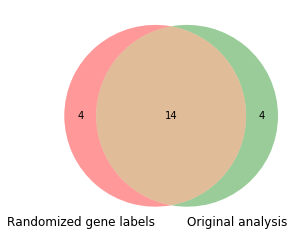

In [33]:
# Common drugs
drugs_random = set(drug_targets_df['drug'])
drugs_norandom = set(drug_targets_df_norandom['drug'])
venn2(subsets = [drugs_random,drugs_norandom],set_labels = ('Randomized gene labels','Original analysis'))
original_minus_random = num_targets_df.loc[num_targets_df['drug'].isin(drugs_norandom.difference(drugs_random))]
random_minus_original = num_targets_df.loc[num_targets_df['drug'].isin(drugs_random.difference(drugs_norandom))]
original_inter_random = num_targets_df.loc[num_targets_df['drug'].isin(drugs_norandom.intersection(drugs_random))]
print(original_minus_random)
print(random_minus_original)
print(original_inter_random)

# Repeat randomization and measure robustness of selected drugs

In [34]:
# Number of repetitions
N = 1000

# Steiner tree parameter
hyperparams = {"w": 1.4, 
               "b": 40, 
               "g": 0,
               "pruning": 'strong',
               "edge_noise": 0, 
               "dummy_mode": "terminals", 
               "seed": 0, 
               "skip_checks": False,
               "verbosity_level": 0}

# Table of selected drugs in the original study
original_drugs = num_targets_df.copy()
original_drugs = original_drugs[num_targets_df['drug'].isin(drugs_norandom)]
original_drugs.insert(3,"num_appearance",np.zeros(len(original_drugs['drug'])))

# Table of drugs that were not selected in the original study
non_original_drugs = num_targets_df.copy()
non_original_drugs = non_original_drugs[~num_targets_df['drug'].isin(drugs_norandom)]
non_original_drugs.insert(3,"num_appearance",np.zeros(len(non_original_drugs['drug'])))

In [35]:
for i in range(N):

    # Create prized list
    seed = i
    np.random.seed(seed)
    terminal_df = prizes.create_random_prized_genes_list(blanco2_rpkm,
                                                         proteins_in_ppi,
                                                         n_terminals,
                                                         seed=seed)
    # Save terminal df to tsv
    terminal_df.to_csv(r'../Save_RandomizeTerminals/terminals_ppi_analysis_repeat.tsv', header=True, index=None, sep='\t', quoting = csv.QUOTE_NONE, escapechar = '\t')
    prize_file_name = "../Save_RandomizeTerminals/terminals_ppi_analysis_repeat.tsv"

    # Obtain Steiner Tree
    graph = oi.Graph(interactome_file_name, hyperparams)
    graph.prepare_prizes(prize_file_name)
    vertex_indices, edge_indices = graph.pcsf()
    _, network_selected = graph.output_forest_as_networkx(vertex_indices, edge_indices)

    # Add following attribute for each gene: is gene druggable, what drug 
    drugs = {gene:list(targets_and_drugs_df.loc[targets_and_drugs_df['gene']==gene]['drug']) for gene in list(network_selected.nodes())}
    drugs_with_corr_aff = {gene:[targets_and_drugs_df['drug'][i]+'%'+str(targets_and_drugs_df['corr'][i])+'%'+str(targets_and_drugs_df['affinity_constant'][i])
                             for i in targets_and_drugs_df.index[targets_and_drugs_df['gene']==gene]]
                             for gene in list(network_selected.nodes())}
    druggable_boolean = {gene:drugs[gene]!=[] for gene in list(network_selected.nodes())}
    protein_target = {gene:list(targets_and_drugs_df.loc[targets_and_drugs_df['gene']==gene]['protein_target']) for gene in list(network_selected.nodes())}
    nx.set_node_attributes(network_selected, druggable_boolean, name='druggable')
    nx.set_node_attributes(network_selected, drugs, name='drug')
    nx.set_node_attributes(network_selected, drugs_with_corr_aff, name='drug_with_corr_aff')
    nx.set_node_attributes(network_selected, protein_target, name='protein_target')

    # Get selected network as dataframe of node
    network_enriched_df = oi.get_networkx_graph_as_dataframe_of_nodes(network_selected)

    # Drug targets in network dataframe
    drug_targets_df = network_enriched_df.copy()
    drug_targets_df = drug_targets_df.loc[drug_targets_df['druggable']==True]
    drug_targets_df['name'] = drug_targets_df.index
    wanted_columns = ['name','drug_with_corr_aff','protein_target']
    drug_targets_df = drug_targets_df[wanted_columns]
    drug_targets_df['protein_target'] = [set(drug_targets_df['protein_target'][i]) for i in np.arange(len(drug_targets_df))]

    # Explode
    drug_targets_df = drugs2.unnesting(drug_targets_df, ['drug_with_corr_aff'])
    drug_targets_df[['drug','corr','affinity']] = drug_targets_df['drug_with_corr_aff'].str.split('%',expand = True)
    wanted_columns2 = ['name','protein_target','drug','corr','affinity']
    drug_targets_df = drug_targets_df[wanted_columns2]

    # Increment number of appearances of original drugs and non-original drugs
    final_drug_list = np.unique(drug_targets_df['drug'])
    original_drugs.loc[original_drugs['drug'].isin(set(final_drug_list)),'num_appearance'] += 1
    non_original_drugs.loc[non_original_drugs['drug'].isin(set(final_drug_list)),'num_appearance'] += 1
    
    print('progress = '+str(i/N*100) + '%')
    
original_drugs.loc[:,'num_appearance'] /= N
non_original_drugs.loc[:,'num_appearance'] /= N

# Save as pickle
with open("../Save_RandomizeTerminals/original_drugs.pkl", "wb") as f: 
    pickle.dump(original_drugs, f)
with open("../Save_RandomizeTerminals/non_original_drugs.pkl", "wb") as f: 
    pickle.dump(non_original_drugs, f)

10:56:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:56:00 - OI2: INFO - []
10:56:00 - OI2: INFO - Members of the prize file not present in the interactome:
10:56:00 - OI2: INFO - []


progress = 0.0%


10:56:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:56:03 - OI2: INFO - []
10:56:03 - OI2: INFO - Members of the prize file not present in the interactome:
10:56:03 - OI2: INFO - []


progress = 0.1%


10:56:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:56:06 - OI2: INFO - []
10:56:06 - OI2: INFO - Members of the prize file not present in the interactome:
10:56:06 - OI2: INFO - []


progress = 0.2%


10:56:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:56:09 - OI2: INFO - []
10:56:09 - OI2: INFO - Members of the prize file not present in the interactome:
10:56:09 - OI2: INFO - []


progress = 0.3%


10:56:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:56:11 - OI2: INFO - []
10:56:11 - OI2: INFO - Members of the prize file not present in the interactome:
10:56:11 - OI2: INFO - []


progress = 0.4%


10:56:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:56:14 - OI2: INFO - []
10:56:14 - OI2: INFO - Members of the prize file not present in the interactome:
10:56:14 - OI2: INFO - []


progress = 0.5%


10:56:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:56:17 - OI2: INFO - []
10:56:17 - OI2: INFO - Members of the prize file not present in the interactome:
10:56:17 - OI2: INFO - []


progress = 0.6%


10:56:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:56:19 - OI2: INFO - []
10:56:19 - OI2: INFO - Members of the prize file not present in the interactome:
10:56:19 - OI2: INFO - []


progress = 0.7000000000000001%


10:56:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:56:22 - OI2: INFO - []
10:56:22 - OI2: INFO - Members of the prize file not present in the interactome:
10:56:22 - OI2: INFO - []


progress = 0.8%


10:56:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:56:25 - OI2: INFO - []
10:56:25 - OI2: INFO - Members of the prize file not present in the interactome:
10:56:25 - OI2: INFO - []


progress = 0.8999999999999999%


10:56:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:56:28 - OI2: INFO - []
10:56:28 - OI2: INFO - Members of the prize file not present in the interactome:
10:56:28 - OI2: INFO - []


progress = 1.0%


10:56:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:56:31 - OI2: INFO - []
10:56:31 - OI2: INFO - Members of the prize file not present in the interactome:
10:56:31 - OI2: INFO - []


progress = 1.0999999999999999%


10:56:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:56:33 - OI2: INFO - []
10:56:33 - OI2: INFO - Members of the prize file not present in the interactome:
10:56:33 - OI2: INFO - []


progress = 1.2%


10:56:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:56:36 - OI2: INFO - []
10:56:36 - OI2: INFO - Members of the prize file not present in the interactome:
10:56:36 - OI2: INFO - []


progress = 1.3%


10:56:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:56:39 - OI2: INFO - []
10:56:39 - OI2: INFO - Members of the prize file not present in the interactome:
10:56:39 - OI2: INFO - []


progress = 1.4000000000000001%


10:56:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:56:42 - OI2: INFO - []
10:56:42 - OI2: INFO - Members of the prize file not present in the interactome:
10:56:42 - OI2: INFO - []


progress = 1.5%


10:56:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:56:44 - OI2: INFO - []
10:56:44 - OI2: INFO - Members of the prize file not present in the interactome:
10:56:44 - OI2: INFO - []


progress = 1.6%


10:56:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:56:47 - OI2: INFO - []
10:56:47 - OI2: INFO - Members of the prize file not present in the interactome:
10:56:47 - OI2: INFO - []


progress = 1.7000000000000002%


10:56:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:56:50 - OI2: INFO - []
10:56:50 - OI2: INFO - Members of the prize file not present in the interactome:
10:56:50 - OI2: INFO - []


progress = 1.7999999999999998%


10:56:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:56:53 - OI2: INFO - []
10:56:53 - OI2: INFO - Members of the prize file not present in the interactome:
10:56:53 - OI2: INFO - []


progress = 1.9%


10:56:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:56:55 - OI2: INFO - []
10:56:55 - OI2: INFO - Members of the prize file not present in the interactome:
10:56:55 - OI2: INFO - []


progress = 2.0%


10:56:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:56:58 - OI2: INFO - []
10:56:58 - OI2: INFO - Members of the prize file not present in the interactome:
10:56:58 - OI2: INFO - []


progress = 2.1%


10:57:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:57:01 - OI2: INFO - []
10:57:01 - OI2: INFO - Members of the prize file not present in the interactome:
10:57:01 - OI2: INFO - []


progress = 2.1999999999999997%


10:57:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:57:04 - OI2: INFO - []
10:57:04 - OI2: INFO - Members of the prize file not present in the interactome:
10:57:04 - OI2: INFO - []


progress = 2.3%


10:57:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:57:06 - OI2: INFO - []
10:57:06 - OI2: INFO - Members of the prize file not present in the interactome:
10:57:06 - OI2: INFO - []


progress = 2.4%


10:57:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:57:09 - OI2: INFO - []
10:57:09 - OI2: INFO - Members of the prize file not present in the interactome:
10:57:09 - OI2: INFO - []


progress = 2.5%


10:57:12 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:57:12 - OI2: INFO - []
10:57:12 - OI2: INFO - Members of the prize file not present in the interactome:
10:57:12 - OI2: INFO - []


progress = 2.6%


10:57:15 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:57:15 - OI2: INFO - []
10:57:15 - OI2: INFO - Members of the prize file not present in the interactome:
10:57:15 - OI2: INFO - []


progress = 2.7%


10:57:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:57:17 - OI2: INFO - []
10:57:17 - OI2: INFO - Members of the prize file not present in the interactome:
10:57:17 - OI2: INFO - []


progress = 2.8000000000000003%


10:57:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:57:20 - OI2: INFO - []
10:57:20 - OI2: INFO - Members of the prize file not present in the interactome:
10:57:20 - OI2: INFO - []


progress = 2.9000000000000004%


10:57:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:57:23 - OI2: INFO - []
10:57:23 - OI2: INFO - Members of the prize file not present in the interactome:
10:57:23 - OI2: INFO - []


progress = 3.0%


10:57:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:57:26 - OI2: INFO - []
10:57:26 - OI2: INFO - Members of the prize file not present in the interactome:
10:57:26 - OI2: INFO - []


progress = 3.1%


10:57:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:57:28 - OI2: INFO - []
10:57:28 - OI2: INFO - Members of the prize file not present in the interactome:
10:57:28 - OI2: INFO - []


progress = 3.2%


10:57:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:57:31 - OI2: INFO - []
10:57:31 - OI2: INFO - Members of the prize file not present in the interactome:
10:57:31 - OI2: INFO - []


progress = 3.3000000000000003%


10:57:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:57:34 - OI2: INFO - []
10:57:34 - OI2: INFO - Members of the prize file not present in the interactome:
10:57:34 - OI2: INFO - []


progress = 3.4000000000000004%


10:57:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:57:37 - OI2: INFO - []
10:57:37 - OI2: INFO - Members of the prize file not present in the interactome:
10:57:37 - OI2: INFO - []


progress = 3.5000000000000004%


10:57:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:57:39 - OI2: INFO - []
10:57:39 - OI2: INFO - Members of the prize file not present in the interactome:
10:57:39 - OI2: INFO - []


progress = 3.5999999999999996%


10:57:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:57:42 - OI2: INFO - []
10:57:42 - OI2: INFO - Members of the prize file not present in the interactome:
10:57:42 - OI2: INFO - []


progress = 3.6999999999999997%


10:57:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:57:45 - OI2: INFO - []
10:57:45 - OI2: INFO - Members of the prize file not present in the interactome:
10:57:45 - OI2: INFO - []


progress = 3.8%


10:57:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:57:48 - OI2: INFO - []
10:57:48 - OI2: INFO - Members of the prize file not present in the interactome:
10:57:48 - OI2: INFO - []


progress = 3.9%


10:57:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:57:50 - OI2: INFO - []
10:57:50 - OI2: INFO - Members of the prize file not present in the interactome:
10:57:50 - OI2: INFO - []


progress = 4.0%


10:57:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:57:53 - OI2: INFO - []
10:57:53 - OI2: INFO - Members of the prize file not present in the interactome:
10:57:53 - OI2: INFO - []


progress = 4.1000000000000005%


10:57:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:57:56 - OI2: INFO - []
10:57:56 - OI2: INFO - Members of the prize file not present in the interactome:
10:57:56 - OI2: INFO - []


progress = 4.2%


10:57:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:57:59 - OI2: INFO - []
10:57:59 - OI2: INFO - Members of the prize file not present in the interactome:
10:57:59 - OI2: INFO - []


progress = 4.3%


10:58:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:58:01 - OI2: INFO - []
10:58:01 - OI2: INFO - Members of the prize file not present in the interactome:
10:58:01 - OI2: INFO - []


progress = 4.3999999999999995%


10:58:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:58:04 - OI2: INFO - []
10:58:04 - OI2: INFO - Members of the prize file not present in the interactome:
10:58:04 - OI2: INFO - []


progress = 4.5%


10:58:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:58:07 - OI2: INFO - []
10:58:07 - OI2: INFO - Members of the prize file not present in the interactome:
10:58:07 - OI2: INFO - []


progress = 4.6%


10:58:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:58:10 - OI2: INFO - []
10:58:10 - OI2: INFO - Members of the prize file not present in the interactome:
10:58:10 - OI2: INFO - []


progress = 4.7%


10:58:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:58:13 - OI2: INFO - []
10:58:13 - OI2: INFO - Members of the prize file not present in the interactome:
10:58:13 - OI2: INFO - []


progress = 4.8%


10:58:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:58:16 - OI2: INFO - []
10:58:16 - OI2: INFO - Members of the prize file not present in the interactome:
10:58:16 - OI2: INFO - []


progress = 4.9%


10:58:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:58:19 - OI2: INFO - []
10:58:19 - OI2: INFO - Members of the prize file not present in the interactome:
10:58:19 - OI2: INFO - []


progress = 5.0%


10:58:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:58:21 - OI2: INFO - []
10:58:21 - OI2: INFO - Members of the prize file not present in the interactome:
10:58:21 - OI2: INFO - []


progress = 5.1%


10:58:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:58:24 - OI2: INFO - []
10:58:24 - OI2: INFO - Members of the prize file not present in the interactome:
10:58:24 - OI2: INFO - []


progress = 5.2%


10:58:27 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:58:27 - OI2: INFO - []
10:58:27 - OI2: INFO - Members of the prize file not present in the interactome:
10:58:27 - OI2: INFO - []


progress = 5.3%


10:58:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:58:30 - OI2: INFO - []
10:58:30 - OI2: INFO - Members of the prize file not present in the interactome:
10:58:30 - OI2: INFO - []


progress = 5.4%


10:58:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:58:33 - OI2: INFO - []
10:58:33 - OI2: INFO - Members of the prize file not present in the interactome:
10:58:33 - OI2: INFO - []


progress = 5.5%


10:58:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:58:36 - OI2: INFO - []
10:58:36 - OI2: INFO - Members of the prize file not present in the interactome:
10:58:36 - OI2: INFO - []


progress = 5.6000000000000005%


10:58:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:58:38 - OI2: INFO - []
10:58:38 - OI2: INFO - Members of the prize file not present in the interactome:
10:58:38 - OI2: INFO - []


progress = 5.7%


10:58:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:58:41 - OI2: INFO - []
10:58:41 - OI2: INFO - Members of the prize file not present in the interactome:
10:58:41 - OI2: INFO - []


progress = 5.800000000000001%


10:58:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:58:44 - OI2: INFO - []
10:58:44 - OI2: INFO - Members of the prize file not present in the interactome:
10:58:44 - OI2: INFO - []


progress = 5.8999999999999995%


10:58:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:58:47 - OI2: INFO - []
10:58:47 - OI2: INFO - Members of the prize file not present in the interactome:
10:58:47 - OI2: INFO - []


progress = 6.0%


10:58:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:58:50 - OI2: INFO - []
10:58:50 - OI2: INFO - Members of the prize file not present in the interactome:
10:58:50 - OI2: INFO - []


progress = 6.1%


10:58:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:58:52 - OI2: INFO - []
10:58:53 - OI2: INFO - Members of the prize file not present in the interactome:
10:58:53 - OI2: INFO - []


progress = 6.2%


10:58:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:58:55 - OI2: INFO - []
10:58:55 - OI2: INFO - Members of the prize file not present in the interactome:
10:58:55 - OI2: INFO - []


progress = 6.3%


10:58:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:58:58 - OI2: INFO - []
10:58:58 - OI2: INFO - Members of the prize file not present in the interactome:
10:58:58 - OI2: INFO - []


progress = 6.4%


10:59:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:59:01 - OI2: INFO - []
10:59:01 - OI2: INFO - Members of the prize file not present in the interactome:
10:59:01 - OI2: INFO - []


progress = 6.5%


10:59:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:59:04 - OI2: INFO - []
10:59:04 - OI2: INFO - Members of the prize file not present in the interactome:
10:59:04 - OI2: INFO - []


progress = 6.6000000000000005%


10:59:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:59:06 - OI2: INFO - []
10:59:06 - OI2: INFO - Members of the prize file not present in the interactome:
10:59:06 - OI2: INFO - []


progress = 6.7%


10:59:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:59:09 - OI2: INFO - []
10:59:09 - OI2: INFO - Members of the prize file not present in the interactome:
10:59:09 - OI2: INFO - []


progress = 6.800000000000001%


10:59:12 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:59:12 - OI2: INFO - []
10:59:12 - OI2: INFO - Members of the prize file not present in the interactome:
10:59:12 - OI2: INFO - []


progress = 6.9%


10:59:15 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:59:15 - OI2: INFO - []
10:59:15 - OI2: INFO - Members of the prize file not present in the interactome:
10:59:15 - OI2: INFO - []


progress = 7.000000000000001%


10:59:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:59:17 - OI2: INFO - []
10:59:17 - OI2: INFO - Members of the prize file not present in the interactome:
10:59:17 - OI2: INFO - []


progress = 7.1%


10:59:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:59:20 - OI2: INFO - []
10:59:20 - OI2: INFO - Members of the prize file not present in the interactome:
10:59:20 - OI2: INFO - []


progress = 7.199999999999999%


10:59:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:59:23 - OI2: INFO - []
10:59:23 - OI2: INFO - Members of the prize file not present in the interactome:
10:59:23 - OI2: INFO - []


progress = 7.3%


10:59:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:59:26 - OI2: INFO - []
10:59:26 - OI2: INFO - Members of the prize file not present in the interactome:
10:59:26 - OI2: INFO - []


progress = 7.3999999999999995%


10:59:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:59:29 - OI2: INFO - []
10:59:29 - OI2: INFO - Members of the prize file not present in the interactome:
10:59:29 - OI2: INFO - []


progress = 7.5%


10:59:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:59:32 - OI2: INFO - []
10:59:32 - OI2: INFO - Members of the prize file not present in the interactome:
10:59:32 - OI2: INFO - []


progress = 7.6%


10:59:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:59:34 - OI2: INFO - []
10:59:34 - OI2: INFO - Members of the prize file not present in the interactome:
10:59:34 - OI2: INFO - []


progress = 7.7%


10:59:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:59:37 - OI2: INFO - []
10:59:37 - OI2: INFO - Members of the prize file not present in the interactome:
10:59:37 - OI2: INFO - []


progress = 7.8%


10:59:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:59:40 - OI2: INFO - []
10:59:40 - OI2: INFO - Members of the prize file not present in the interactome:
10:59:40 - OI2: INFO - []


progress = 7.9%


10:59:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:59:43 - OI2: INFO - []
10:59:43 - OI2: INFO - Members of the prize file not present in the interactome:
10:59:43 - OI2: INFO - []


progress = 8.0%


10:59:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:59:46 - OI2: INFO - []
10:59:46 - OI2: INFO - Members of the prize file not present in the interactome:
10:59:46 - OI2: INFO - []


progress = 8.1%


10:59:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:59:48 - OI2: INFO - []
10:59:48 - OI2: INFO - Members of the prize file not present in the interactome:
10:59:48 - OI2: INFO - []


progress = 8.200000000000001%


10:59:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:59:51 - OI2: INFO - []
10:59:51 - OI2: INFO - Members of the prize file not present in the interactome:
10:59:51 - OI2: INFO - []


progress = 8.3%


10:59:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:59:54 - OI2: INFO - []
10:59:54 - OI2: INFO - Members of the prize file not present in the interactome:
10:59:54 - OI2: INFO - []


progress = 8.4%


10:59:57 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:59:57 - OI2: INFO - []
10:59:57 - OI2: INFO - Members of the prize file not present in the interactome:
10:59:57 - OI2: INFO - []


progress = 8.5%


11:00:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:00:00 - OI2: INFO - []
11:00:00 - OI2: INFO - Members of the prize file not present in the interactome:
11:00:00 - OI2: INFO - []


progress = 8.6%


11:00:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:00:02 - OI2: INFO - []
11:00:02 - OI2: INFO - Members of the prize file not present in the interactome:
11:00:02 - OI2: INFO - []


progress = 8.7%


11:00:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:00:05 - OI2: INFO - []
11:00:05 - OI2: INFO - Members of the prize file not present in the interactome:
11:00:05 - OI2: INFO - []


progress = 8.799999999999999%


11:00:08 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:00:08 - OI2: INFO - []
11:00:08 - OI2: INFO - Members of the prize file not present in the interactome:
11:00:08 - OI2: INFO - []


progress = 8.9%


11:00:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:00:11 - OI2: INFO - []
11:00:11 - OI2: INFO - Members of the prize file not present in the interactome:
11:00:11 - OI2: INFO - []


progress = 9.0%


11:00:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:00:14 - OI2: INFO - []
11:00:14 - OI2: INFO - Members of the prize file not present in the interactome:
11:00:14 - OI2: INFO - []


progress = 9.1%


11:00:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:00:17 - OI2: INFO - []
11:00:17 - OI2: INFO - Members of the prize file not present in the interactome:
11:00:17 - OI2: INFO - []


progress = 9.2%


11:00:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:00:19 - OI2: INFO - []
11:00:19 - OI2: INFO - Members of the prize file not present in the interactome:
11:00:19 - OI2: INFO - []


progress = 9.3%


11:00:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:00:22 - OI2: INFO - []
11:00:22 - OI2: INFO - Members of the prize file not present in the interactome:
11:00:22 - OI2: INFO - []


progress = 9.4%


11:00:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:00:25 - OI2: INFO - []
11:00:25 - OI2: INFO - Members of the prize file not present in the interactome:
11:00:25 - OI2: INFO - []


progress = 9.5%


11:00:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:00:28 - OI2: INFO - []
11:00:28 - OI2: INFO - Members of the prize file not present in the interactome:
11:00:28 - OI2: INFO - []


progress = 9.6%


11:00:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:00:31 - OI2: INFO - []
11:00:31 - OI2: INFO - Members of the prize file not present in the interactome:
11:00:31 - OI2: INFO - []


progress = 9.700000000000001%


11:00:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:00:34 - OI2: INFO - []
11:00:34 - OI2: INFO - Members of the prize file not present in the interactome:
11:00:34 - OI2: INFO - []


progress = 9.8%


11:00:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:00:36 - OI2: INFO - []
11:00:36 - OI2: INFO - Members of the prize file not present in the interactome:
11:00:36 - OI2: INFO - []


progress = 9.9%


11:00:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:00:39 - OI2: INFO - []
11:00:39 - OI2: INFO - Members of the prize file not present in the interactome:
11:00:39 - OI2: INFO - []


progress = 10.0%


11:00:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:00:42 - OI2: INFO - []
11:00:42 - OI2: INFO - Members of the prize file not present in the interactome:
11:00:42 - OI2: INFO - []


progress = 10.100000000000001%


11:00:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:00:45 - OI2: INFO - []
11:00:45 - OI2: INFO - Members of the prize file not present in the interactome:
11:00:45 - OI2: INFO - []


progress = 10.2%


11:00:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:00:48 - OI2: INFO - []
11:00:48 - OI2: INFO - Members of the prize file not present in the interactome:
11:00:48 - OI2: INFO - []


progress = 10.299999999999999%


11:00:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:00:51 - OI2: INFO - []
11:00:51 - OI2: INFO - Members of the prize file not present in the interactome:
11:00:51 - OI2: INFO - []


progress = 10.4%


11:00:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:00:53 - OI2: INFO - []
11:00:53 - OI2: INFO - Members of the prize file not present in the interactome:
11:00:53 - OI2: INFO - []


progress = 10.5%


11:00:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:00:56 - OI2: INFO - []
11:00:56 - OI2: INFO - Members of the prize file not present in the interactome:
11:00:56 - OI2: INFO - []


progress = 10.6%


11:00:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:00:59 - OI2: INFO - []
11:00:59 - OI2: INFO - Members of the prize file not present in the interactome:
11:00:59 - OI2: INFO - []


progress = 10.7%


11:01:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:01:02 - OI2: INFO - []
11:01:02 - OI2: INFO - Members of the prize file not present in the interactome:
11:01:02 - OI2: INFO - []


progress = 10.8%


11:01:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:01:05 - OI2: INFO - []
11:01:05 - OI2: INFO - Members of the prize file not present in the interactome:
11:01:05 - OI2: INFO - []


progress = 10.9%


11:01:08 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:01:08 - OI2: INFO - []
11:01:08 - OI2: INFO - Members of the prize file not present in the interactome:
11:01:08 - OI2: INFO - []


progress = 11.0%


11:01:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:01:11 - OI2: INFO - []
11:01:11 - OI2: INFO - Members of the prize file not present in the interactome:
11:01:11 - OI2: INFO - []


progress = 11.1%


11:01:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:01:13 - OI2: INFO - []
11:01:13 - OI2: INFO - Members of the prize file not present in the interactome:
11:01:13 - OI2: INFO - []


progress = 11.200000000000001%


11:01:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:01:16 - OI2: INFO - []
11:01:16 - OI2: INFO - Members of the prize file not present in the interactome:
11:01:16 - OI2: INFO - []


progress = 11.3%


11:01:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:01:19 - OI2: INFO - []
11:01:19 - OI2: INFO - Members of the prize file not present in the interactome:
11:01:19 - OI2: INFO - []


progress = 11.4%


11:01:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:01:22 - OI2: INFO - []
11:01:22 - OI2: INFO - Members of the prize file not present in the interactome:
11:01:22 - OI2: INFO - []


progress = 11.5%


11:01:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:01:25 - OI2: INFO - []
11:01:25 - OI2: INFO - Members of the prize file not present in the interactome:
11:01:25 - OI2: INFO - []


progress = 11.600000000000001%


11:01:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:01:28 - OI2: INFO - []
11:01:28 - OI2: INFO - Members of the prize file not present in the interactome:
11:01:28 - OI2: INFO - []


progress = 11.700000000000001%


11:01:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:01:30 - OI2: INFO - []
11:01:30 - OI2: INFO - Members of the prize file not present in the interactome:
11:01:30 - OI2: INFO - []


progress = 11.799999999999999%


11:01:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:01:33 - OI2: INFO - []
11:01:33 - OI2: INFO - Members of the prize file not present in the interactome:
11:01:33 - OI2: INFO - []


progress = 11.899999999999999%


11:01:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:01:36 - OI2: INFO - []
11:01:36 - OI2: INFO - Members of the prize file not present in the interactome:
11:01:36 - OI2: INFO - []


progress = 12.0%


11:01:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:01:39 - OI2: INFO - []
11:01:39 - OI2: INFO - Members of the prize file not present in the interactome:
11:01:39 - OI2: INFO - []


progress = 12.1%


11:01:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:01:42 - OI2: INFO - []
11:01:42 - OI2: INFO - Members of the prize file not present in the interactome:
11:01:42 - OI2: INFO - []


progress = 12.2%


11:01:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:01:44 - OI2: INFO - []
11:01:44 - OI2: INFO - Members of the prize file not present in the interactome:
11:01:44 - OI2: INFO - []


progress = 12.3%


11:01:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:01:47 - OI2: INFO - []
11:01:47 - OI2: INFO - Members of the prize file not present in the interactome:
11:01:47 - OI2: INFO - []


progress = 12.4%


11:01:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:01:50 - OI2: INFO - []
11:01:50 - OI2: INFO - Members of the prize file not present in the interactome:
11:01:50 - OI2: INFO - []


progress = 12.5%


11:01:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:01:53 - OI2: INFO - []
11:01:53 - OI2: INFO - Members of the prize file not present in the interactome:
11:01:53 - OI2: INFO - []


progress = 12.6%


11:01:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:01:55 - OI2: INFO - []
11:01:55 - OI2: INFO - Members of the prize file not present in the interactome:
11:01:55 - OI2: INFO - []


progress = 12.7%


11:01:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:01:58 - OI2: INFO - []
11:01:58 - OI2: INFO - Members of the prize file not present in the interactome:
11:01:58 - OI2: INFO - []


progress = 12.8%


11:02:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:02:01 - OI2: INFO - []
11:02:01 - OI2: INFO - Members of the prize file not present in the interactome:
11:02:01 - OI2: INFO - []


progress = 12.9%


11:02:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:02:04 - OI2: INFO - []
11:02:04 - OI2: INFO - Members of the prize file not present in the interactome:
11:02:04 - OI2: INFO - []


progress = 13.0%


11:02:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:02:07 - OI2: INFO - []
11:02:07 - OI2: INFO - Members of the prize file not present in the interactome:
11:02:07 - OI2: INFO - []


progress = 13.100000000000001%


11:02:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:02:10 - OI2: INFO - []
11:02:10 - OI2: INFO - Members of the prize file not present in the interactome:
11:02:10 - OI2: INFO - []


progress = 13.200000000000001%


11:02:12 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:02:12 - OI2: INFO - []
11:02:12 - OI2: INFO - Members of the prize file not present in the interactome:
11:02:12 - OI2: INFO - []


progress = 13.3%


11:02:15 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:02:15 - OI2: INFO - []
11:02:15 - OI2: INFO - Members of the prize file not present in the interactome:
11:02:15 - OI2: INFO - []


progress = 13.4%


11:02:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:02:18 - OI2: INFO - []
11:02:18 - OI2: INFO - Members of the prize file not present in the interactome:
11:02:18 - OI2: INFO - []


progress = 13.5%


11:02:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:02:21 - OI2: INFO - []
11:02:21 - OI2: INFO - Members of the prize file not present in the interactome:
11:02:21 - OI2: INFO - []


progress = 13.600000000000001%


11:02:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:02:24 - OI2: INFO - []
11:02:24 - OI2: INFO - Members of the prize file not present in the interactome:
11:02:24 - OI2: INFO - []


progress = 13.700000000000001%


11:02:27 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:02:27 - OI2: INFO - []
11:02:27 - OI2: INFO - Members of the prize file not present in the interactome:
11:02:27 - OI2: INFO - []


progress = 13.8%


11:02:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:02:29 - OI2: INFO - []
11:02:29 - OI2: INFO - Members of the prize file not present in the interactome:
11:02:29 - OI2: INFO - []


progress = 13.900000000000002%


11:02:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:02:32 - OI2: INFO - []
11:02:32 - OI2: INFO - Members of the prize file not present in the interactome:
11:02:32 - OI2: INFO - []


progress = 14.000000000000002%


11:02:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:02:35 - OI2: INFO - []
11:02:35 - OI2: INFO - Members of the prize file not present in the interactome:
11:02:35 - OI2: INFO - []


progress = 14.099999999999998%


11:02:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:02:38 - OI2: INFO - []
11:02:38 - OI2: INFO - Members of the prize file not present in the interactome:
11:02:38 - OI2: INFO - []


progress = 14.2%


11:02:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:02:41 - OI2: INFO - []
11:02:41 - OI2: INFO - Members of the prize file not present in the interactome:
11:02:41 - OI2: INFO - []


progress = 14.299999999999999%


11:02:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:02:43 - OI2: INFO - []
11:02:43 - OI2: INFO - Members of the prize file not present in the interactome:
11:02:43 - OI2: INFO - []


progress = 14.399999999999999%


11:02:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:02:46 - OI2: INFO - []
11:02:46 - OI2: INFO - Members of the prize file not present in the interactome:
11:02:46 - OI2: INFO - []


progress = 14.499999999999998%


11:02:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:02:49 - OI2: INFO - []
11:02:49 - OI2: INFO - Members of the prize file not present in the interactome:
11:02:49 - OI2: INFO - []


progress = 14.6%


11:02:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:02:52 - OI2: INFO - []
11:02:52 - OI2: INFO - Members of the prize file not present in the interactome:
11:02:52 - OI2: INFO - []


progress = 14.7%


11:02:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:02:55 - OI2: INFO - []
11:02:55 - OI2: INFO - Members of the prize file not present in the interactome:
11:02:55 - OI2: INFO - []


progress = 14.799999999999999%


11:02:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:02:58 - OI2: INFO - []
11:02:58 - OI2: INFO - Members of the prize file not present in the interactome:
11:02:58 - OI2: INFO - []


progress = 14.899999999999999%


11:03:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:03:00 - OI2: INFO - []
11:03:00 - OI2: INFO - Members of the prize file not present in the interactome:
11:03:00 - OI2: INFO - []


progress = 15.0%


11:03:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:03:03 - OI2: INFO - []
11:03:03 - OI2: INFO - Members of the prize file not present in the interactome:
11:03:03 - OI2: INFO - []


progress = 15.1%


11:03:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:03:06 - OI2: INFO - []
11:03:06 - OI2: INFO - Members of the prize file not present in the interactome:
11:03:06 - OI2: INFO - []


progress = 15.2%


11:03:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:03:09 - OI2: INFO - []
11:03:09 - OI2: INFO - Members of the prize file not present in the interactome:
11:03:09 - OI2: INFO - []


progress = 15.299999999999999%


11:03:12 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:03:12 - OI2: INFO - []
11:03:12 - OI2: INFO - Members of the prize file not present in the interactome:
11:03:12 - OI2: INFO - []


progress = 15.4%


11:03:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:03:14 - OI2: INFO - []
11:03:14 - OI2: INFO - Members of the prize file not present in the interactome:
11:03:14 - OI2: INFO - []


progress = 15.5%


11:03:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:03:17 - OI2: INFO - []
11:03:17 - OI2: INFO - Members of the prize file not present in the interactome:
11:03:17 - OI2: INFO - []


progress = 15.6%


11:03:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:03:20 - OI2: INFO - []
11:03:20 - OI2: INFO - Members of the prize file not present in the interactome:
11:03:20 - OI2: INFO - []


progress = 15.7%


11:03:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:03:23 - OI2: INFO - []
11:03:23 - OI2: INFO - Members of the prize file not present in the interactome:
11:03:23 - OI2: INFO - []


progress = 15.8%


11:03:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:03:26 - OI2: INFO - []
11:03:26 - OI2: INFO - Members of the prize file not present in the interactome:
11:03:26 - OI2: INFO - []


progress = 15.9%


11:03:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:03:29 - OI2: INFO - []
11:03:29 - OI2: INFO - Members of the prize file not present in the interactome:
11:03:29 - OI2: INFO - []


progress = 16.0%


11:03:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:03:31 - OI2: INFO - []
11:03:31 - OI2: INFO - Members of the prize file not present in the interactome:
11:03:31 - OI2: INFO - []


progress = 16.1%


11:03:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:03:34 - OI2: INFO - []
11:03:34 - OI2: INFO - Members of the prize file not present in the interactome:
11:03:34 - OI2: INFO - []


progress = 16.2%


11:03:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:03:37 - OI2: INFO - []
11:03:37 - OI2: INFO - Members of the prize file not present in the interactome:
11:03:37 - OI2: INFO - []


progress = 16.3%


11:03:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:03:40 - OI2: INFO - []
11:03:40 - OI2: INFO - Members of the prize file not present in the interactome:
11:03:40 - OI2: INFO - []


progress = 16.400000000000002%


11:03:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:03:43 - OI2: INFO - []
11:03:43 - OI2: INFO - Members of the prize file not present in the interactome:
11:03:43 - OI2: INFO - []


progress = 16.5%


11:03:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:03:46 - OI2: INFO - []
11:03:46 - OI2: INFO - Members of the prize file not present in the interactome:
11:03:46 - OI2: INFO - []


progress = 16.6%


11:03:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:03:48 - OI2: INFO - []
11:03:48 - OI2: INFO - Members of the prize file not present in the interactome:
11:03:48 - OI2: INFO - []


progress = 16.7%


11:03:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:03:51 - OI2: INFO - []
11:03:51 - OI2: INFO - Members of the prize file not present in the interactome:
11:03:51 - OI2: INFO - []


progress = 16.8%


11:03:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:03:54 - OI2: INFO - []
11:03:54 - OI2: INFO - Members of the prize file not present in the interactome:
11:03:54 - OI2: INFO - []


progress = 16.900000000000002%


11:03:57 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:03:57 - OI2: INFO - []
11:03:57 - OI2: INFO - Members of the prize file not present in the interactome:
11:03:57 - OI2: INFO - []


progress = 17.0%


11:04:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:04:00 - OI2: INFO - []
11:04:00 - OI2: INFO - Members of the prize file not present in the interactome:
11:04:00 - OI2: INFO - []


progress = 17.1%


11:04:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:04:03 - OI2: INFO - []
11:04:03 - OI2: INFO - Members of the prize file not present in the interactome:
11:04:03 - OI2: INFO - []


progress = 17.2%


11:04:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:04:05 - OI2: INFO - []
11:04:05 - OI2: INFO - Members of the prize file not present in the interactome:
11:04:05 - OI2: INFO - []


progress = 17.299999999999997%


11:04:08 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:04:08 - OI2: INFO - []
11:04:08 - OI2: INFO - Members of the prize file not present in the interactome:
11:04:08 - OI2: INFO - []


progress = 17.4%


11:04:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:04:11 - OI2: INFO - []
11:04:11 - OI2: INFO - Members of the prize file not present in the interactome:
11:04:11 - OI2: INFO - []


progress = 17.5%


11:04:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:04:14 - OI2: INFO - []
11:04:14 - OI2: INFO - Members of the prize file not present in the interactome:
11:04:14 - OI2: INFO - []


progress = 17.599999999999998%


11:04:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:04:17 - OI2: INFO - []
11:04:17 - OI2: INFO - Members of the prize file not present in the interactome:
11:04:17 - OI2: INFO - []


progress = 17.7%


11:04:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:04:20 - OI2: INFO - []
11:04:20 - OI2: INFO - Members of the prize file not present in the interactome:
11:04:20 - OI2: INFO - []


progress = 17.8%


11:04:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:04:23 - OI2: INFO - []
11:04:23 - OI2: INFO - Members of the prize file not present in the interactome:
11:04:23 - OI2: INFO - []


progress = 17.9%


11:04:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:04:25 - OI2: INFO - []
11:04:25 - OI2: INFO - Members of the prize file not present in the interactome:
11:04:25 - OI2: INFO - []


progress = 18.0%


11:04:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:04:28 - OI2: INFO - []
11:04:28 - OI2: INFO - Members of the prize file not present in the interactome:
11:04:28 - OI2: INFO - []


progress = 18.099999999999998%


11:04:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:04:31 - OI2: INFO - []
11:04:31 - OI2: INFO - Members of the prize file not present in the interactome:
11:04:31 - OI2: INFO - []


progress = 18.2%


11:04:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:04:34 - OI2: INFO - []
11:04:34 - OI2: INFO - Members of the prize file not present in the interactome:
11:04:34 - OI2: INFO - []


progress = 18.3%


11:04:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:04:37 - OI2: INFO - []
11:04:37 - OI2: INFO - Members of the prize file not present in the interactome:
11:04:37 - OI2: INFO - []


progress = 18.4%


11:04:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:04:39 - OI2: INFO - []
11:04:39 - OI2: INFO - Members of the prize file not present in the interactome:
11:04:39 - OI2: INFO - []


progress = 18.5%


11:04:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:04:42 - OI2: INFO - []
11:04:42 - OI2: INFO - Members of the prize file not present in the interactome:
11:04:42 - OI2: INFO - []


progress = 18.6%


11:04:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:04:45 - OI2: INFO - []
11:04:45 - OI2: INFO - Members of the prize file not present in the interactome:
11:04:45 - OI2: INFO - []


progress = 18.7%


11:04:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:04:48 - OI2: INFO - []
11:04:48 - OI2: INFO - Members of the prize file not present in the interactome:
11:04:48 - OI2: INFO - []


progress = 18.8%


11:04:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:04:50 - OI2: INFO - []
11:04:50 - OI2: INFO - Members of the prize file not present in the interactome:
11:04:50 - OI2: INFO - []


progress = 18.9%


11:04:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:04:53 - OI2: INFO - []
11:04:53 - OI2: INFO - Members of the prize file not present in the interactome:
11:04:53 - OI2: INFO - []


progress = 19.0%


11:04:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:04:56 - OI2: INFO - []
11:04:56 - OI2: INFO - Members of the prize file not present in the interactome:
11:04:56 - OI2: INFO - []


progress = 19.1%


11:04:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:04:59 - OI2: INFO - []
11:04:59 - OI2: INFO - Members of the prize file not present in the interactome:
11:04:59 - OI2: INFO - []


progress = 19.2%


11:05:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:05:02 - OI2: INFO - []
11:05:02 - OI2: INFO - Members of the prize file not present in the interactome:
11:05:02 - OI2: INFO - []


progress = 19.3%


11:05:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:05:04 - OI2: INFO - []
11:05:04 - OI2: INFO - Members of the prize file not present in the interactome:
11:05:04 - OI2: INFO - []


progress = 19.400000000000002%


11:05:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:05:07 - OI2: INFO - []
11:05:07 - OI2: INFO - Members of the prize file not present in the interactome:
11:05:07 - OI2: INFO - []


progress = 19.5%


11:05:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:05:10 - OI2: INFO - []
11:05:10 - OI2: INFO - Members of the prize file not present in the interactome:
11:05:10 - OI2: INFO - []


progress = 19.6%


11:05:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:05:13 - OI2: INFO - []
11:05:13 - OI2: INFO - Members of the prize file not present in the interactome:
11:05:13 - OI2: INFO - []


progress = 19.7%


11:05:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:05:16 - OI2: INFO - []
11:05:16 - OI2: INFO - Members of the prize file not present in the interactome:
11:05:16 - OI2: INFO - []


progress = 19.8%


11:05:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:05:18 - OI2: INFO - []
11:05:18 - OI2: INFO - Members of the prize file not present in the interactome:
11:05:18 - OI2: INFO - []


progress = 19.900000000000002%


11:05:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:05:21 - OI2: INFO - []
11:05:21 - OI2: INFO - Members of the prize file not present in the interactome:
11:05:21 - OI2: INFO - []


progress = 20.0%


11:05:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:05:24 - OI2: INFO - []
11:05:24 - OI2: INFO - Members of the prize file not present in the interactome:
11:05:24 - OI2: INFO - []


progress = 20.1%


11:05:27 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:05:27 - OI2: INFO - []
11:05:27 - OI2: INFO - Members of the prize file not present in the interactome:
11:05:27 - OI2: INFO - []


progress = 20.200000000000003%


11:05:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:05:30 - OI2: INFO - []
11:05:30 - OI2: INFO - Members of the prize file not present in the interactome:
11:05:30 - OI2: INFO - []


progress = 20.3%


11:05:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:05:33 - OI2: INFO - []
11:05:33 - OI2: INFO - Members of the prize file not present in the interactome:
11:05:33 - OI2: INFO - []


progress = 20.4%


11:05:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:05:35 - OI2: INFO - []
11:05:35 - OI2: INFO - Members of the prize file not present in the interactome:
11:05:35 - OI2: INFO - []


progress = 20.5%


11:05:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:05:38 - OI2: INFO - []
11:05:38 - OI2: INFO - Members of the prize file not present in the interactome:
11:05:38 - OI2: INFO - []


progress = 20.599999999999998%


11:05:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:05:41 - OI2: INFO - []
11:05:41 - OI2: INFO - Members of the prize file not present in the interactome:
11:05:41 - OI2: INFO - []


progress = 20.7%


11:05:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:05:44 - OI2: INFO - []
11:05:44 - OI2: INFO - Members of the prize file not present in the interactome:
11:05:44 - OI2: INFO - []


progress = 20.8%


11:05:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:05:47 - OI2: INFO - []
11:05:47 - OI2: INFO - Members of the prize file not present in the interactome:
11:05:47 - OI2: INFO - []


progress = 20.9%


11:05:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:05:49 - OI2: INFO - []
11:05:49 - OI2: INFO - Members of the prize file not present in the interactome:
11:05:49 - OI2: INFO - []


progress = 21.0%


11:05:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:05:52 - OI2: INFO - []
11:05:52 - OI2: INFO - Members of the prize file not present in the interactome:
11:05:52 - OI2: INFO - []


progress = 21.099999999999998%


11:05:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:05:55 - OI2: INFO - []
11:05:55 - OI2: INFO - Members of the prize file not present in the interactome:
11:05:55 - OI2: INFO - []


progress = 21.2%


11:05:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:05:58 - OI2: INFO - []
11:05:58 - OI2: INFO - Members of the prize file not present in the interactome:
11:05:58 - OI2: INFO - []


progress = 21.3%


11:06:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:06:00 - OI2: INFO - []
11:06:00 - OI2: INFO - Members of the prize file not present in the interactome:
11:06:01 - OI2: INFO - []


progress = 21.4%


11:06:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:06:03 - OI2: INFO - []
11:06:03 - OI2: INFO - Members of the prize file not present in the interactome:
11:06:03 - OI2: INFO - []


progress = 21.5%


11:06:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:06:06 - OI2: INFO - []
11:06:06 - OI2: INFO - Members of the prize file not present in the interactome:
11:06:06 - OI2: INFO - []


progress = 21.6%


11:06:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:06:09 - OI2: INFO - []
11:06:09 - OI2: INFO - Members of the prize file not present in the interactome:
11:06:09 - OI2: INFO - []


progress = 21.7%


11:06:12 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:06:12 - OI2: INFO - []
11:06:12 - OI2: INFO - Members of the prize file not present in the interactome:
11:06:12 - OI2: INFO - []


progress = 21.8%


11:06:15 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:06:15 - OI2: INFO - []
11:06:15 - OI2: INFO - Members of the prize file not present in the interactome:
11:06:15 - OI2: INFO - []


progress = 21.9%


11:06:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:06:18 - OI2: INFO - []
11:06:18 - OI2: INFO - Members of the prize file not present in the interactome:
11:06:18 - OI2: INFO - []


progress = 22.0%


11:06:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:06:20 - OI2: INFO - []
11:06:20 - OI2: INFO - Members of the prize file not present in the interactome:
11:06:20 - OI2: INFO - []


progress = 22.1%


11:06:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:06:23 - OI2: INFO - []
11:06:23 - OI2: INFO - Members of the prize file not present in the interactome:
11:06:23 - OI2: INFO - []


progress = 22.2%


11:06:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:06:26 - OI2: INFO - []
11:06:26 - OI2: INFO - Members of the prize file not present in the interactome:
11:06:26 - OI2: INFO - []


progress = 22.3%


11:06:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:06:29 - OI2: INFO - []
11:06:29 - OI2: INFO - Members of the prize file not present in the interactome:
11:06:29 - OI2: INFO - []


progress = 22.400000000000002%


11:06:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:06:32 - OI2: INFO - []
11:06:32 - OI2: INFO - Members of the prize file not present in the interactome:
11:06:32 - OI2: INFO - []


progress = 22.5%


11:06:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:06:34 - OI2: INFO - []
11:06:34 - OI2: INFO - Members of the prize file not present in the interactome:
11:06:34 - OI2: INFO - []


progress = 22.6%


11:06:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:06:37 - OI2: INFO - []
11:06:37 - OI2: INFO - Members of the prize file not present in the interactome:
11:06:37 - OI2: INFO - []


progress = 22.7%


11:06:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:06:40 - OI2: INFO - []
11:06:40 - OI2: INFO - Members of the prize file not present in the interactome:
11:06:40 - OI2: INFO - []


progress = 22.8%


11:06:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:06:43 - OI2: INFO - []
11:06:43 - OI2: INFO - Members of the prize file not present in the interactome:
11:06:43 - OI2: INFO - []


progress = 22.900000000000002%


11:06:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:06:46 - OI2: INFO - []
11:06:46 - OI2: INFO - Members of the prize file not present in the interactome:
11:06:46 - OI2: INFO - []


progress = 23.0%


11:06:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:06:49 - OI2: INFO - []
11:06:49 - OI2: INFO - Members of the prize file not present in the interactome:
11:06:49 - OI2: INFO - []


progress = 23.1%


11:06:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:06:52 - OI2: INFO - []
11:06:52 - OI2: INFO - Members of the prize file not present in the interactome:
11:06:52 - OI2: INFO - []


progress = 23.200000000000003%


11:06:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:06:54 - OI2: INFO - []
11:06:54 - OI2: INFO - Members of the prize file not present in the interactome:
11:06:54 - OI2: INFO - []


progress = 23.3%


11:06:57 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:06:57 - OI2: INFO - []
11:06:57 - OI2: INFO - Members of the prize file not present in the interactome:
11:06:57 - OI2: INFO - []


progress = 23.400000000000002%


11:07:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:07:00 - OI2: INFO - []
11:07:00 - OI2: INFO - Members of the prize file not present in the interactome:
11:07:00 - OI2: INFO - []


progress = 23.5%


11:07:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:07:03 - OI2: INFO - []
11:07:03 - OI2: INFO - Members of the prize file not present in the interactome:
11:07:03 - OI2: INFO - []


progress = 23.599999999999998%


11:07:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:07:06 - OI2: INFO - []
11:07:06 - OI2: INFO - Members of the prize file not present in the interactome:
11:07:06 - OI2: INFO - []


progress = 23.7%


11:07:08 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:07:08 - OI2: INFO - []
11:07:08 - OI2: INFO - Members of the prize file not present in the interactome:
11:07:08 - OI2: INFO - []


progress = 23.799999999999997%


11:07:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:07:11 - OI2: INFO - []
11:07:11 - OI2: INFO - Members of the prize file not present in the interactome:
11:07:11 - OI2: INFO - []


progress = 23.9%


11:07:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:07:14 - OI2: INFO - []
11:07:14 - OI2: INFO - Members of the prize file not present in the interactome:
11:07:14 - OI2: INFO - []


progress = 24.0%


11:07:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:07:17 - OI2: INFO - []
11:07:17 - OI2: INFO - Members of the prize file not present in the interactome:
11:07:17 - OI2: INFO - []


progress = 24.099999999999998%


11:07:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:07:20 - OI2: INFO - []
11:07:20 - OI2: INFO - Members of the prize file not present in the interactome:
11:07:20 - OI2: INFO - []


progress = 24.2%


11:07:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:07:23 - OI2: INFO - []
11:07:23 - OI2: INFO - Members of the prize file not present in the interactome:
11:07:23 - OI2: INFO - []


progress = 24.3%


11:07:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:07:25 - OI2: INFO - []
11:07:25 - OI2: INFO - Members of the prize file not present in the interactome:
11:07:25 - OI2: INFO - []


progress = 24.4%


11:07:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:07:28 - OI2: INFO - []
11:07:28 - OI2: INFO - Members of the prize file not present in the interactome:
11:07:28 - OI2: INFO - []


progress = 24.5%


11:07:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:07:31 - OI2: INFO - []
11:07:31 - OI2: INFO - Members of the prize file not present in the interactome:
11:07:31 - OI2: INFO - []


progress = 24.6%


11:07:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:07:34 - OI2: INFO - []
11:07:34 - OI2: INFO - Members of the prize file not present in the interactome:
11:07:34 - OI2: INFO - []


progress = 24.7%


11:07:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:07:37 - OI2: INFO - []
11:07:37 - OI2: INFO - Members of the prize file not present in the interactome:
11:07:37 - OI2: INFO - []


progress = 24.8%


11:07:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:07:39 - OI2: INFO - []
11:07:40 - OI2: INFO - Members of the prize file not present in the interactome:
11:07:40 - OI2: INFO - []


progress = 24.9%


11:07:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:07:42 - OI2: INFO - []
11:07:42 - OI2: INFO - Members of the prize file not present in the interactome:
11:07:42 - OI2: INFO - []


progress = 25.0%


11:07:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:07:45 - OI2: INFO - []
11:07:45 - OI2: INFO - Members of the prize file not present in the interactome:
11:07:45 - OI2: INFO - []


progress = 25.1%


11:07:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:07:48 - OI2: INFO - []
11:07:48 - OI2: INFO - Members of the prize file not present in the interactome:
11:07:48 - OI2: INFO - []


progress = 25.2%


11:07:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:07:51 - OI2: INFO - []
11:07:51 - OI2: INFO - Members of the prize file not present in the interactome:
11:07:51 - OI2: INFO - []


progress = 25.3%


11:07:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:07:53 - OI2: INFO - []
11:07:53 - OI2: INFO - Members of the prize file not present in the interactome:
11:07:53 - OI2: INFO - []


progress = 25.4%


11:07:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:07:56 - OI2: INFO - []
11:07:56 - OI2: INFO - Members of the prize file not present in the interactome:
11:07:56 - OI2: INFO - []


progress = 25.5%


11:07:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:07:59 - OI2: INFO - []
11:07:59 - OI2: INFO - Members of the prize file not present in the interactome:
11:07:59 - OI2: INFO - []


progress = 25.6%


11:08:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:08:02 - OI2: INFO - []
11:08:02 - OI2: INFO - Members of the prize file not present in the interactome:
11:08:02 - OI2: INFO - []


progress = 25.7%


11:08:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:08:05 - OI2: INFO - []
11:08:05 - OI2: INFO - Members of the prize file not present in the interactome:
11:08:05 - OI2: INFO - []


progress = 25.8%


11:08:08 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:08:08 - OI2: INFO - []
11:08:08 - OI2: INFO - Members of the prize file not present in the interactome:
11:08:08 - OI2: INFO - []


progress = 25.900000000000002%


11:08:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:08:10 - OI2: INFO - []
11:08:10 - OI2: INFO - Members of the prize file not present in the interactome:
11:08:10 - OI2: INFO - []


progress = 26.0%


11:08:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:08:13 - OI2: INFO - []
11:08:13 - OI2: INFO - Members of the prize file not present in the interactome:
11:08:13 - OI2: INFO - []


progress = 26.1%


11:08:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:08:16 - OI2: INFO - []
11:08:16 - OI2: INFO - Members of the prize file not present in the interactome:
11:08:16 - OI2: INFO - []


progress = 26.200000000000003%


11:08:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:08:19 - OI2: INFO - []
11:08:19 - OI2: INFO - Members of the prize file not present in the interactome:
11:08:19 - OI2: INFO - []


progress = 26.3%


11:08:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:08:22 - OI2: INFO - []
11:08:22 - OI2: INFO - Members of the prize file not present in the interactome:
11:08:22 - OI2: INFO - []


progress = 26.400000000000002%


11:08:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:08:25 - OI2: INFO - []
11:08:25 - OI2: INFO - Members of the prize file not present in the interactome:
11:08:25 - OI2: INFO - []


progress = 26.5%


11:08:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:08:28 - OI2: INFO - []
11:08:28 - OI2: INFO - Members of the prize file not present in the interactome:
11:08:28 - OI2: INFO - []


progress = 26.6%


11:08:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:08:30 - OI2: INFO - []
11:08:30 - OI2: INFO - Members of the prize file not present in the interactome:
11:08:30 - OI2: INFO - []


progress = 26.700000000000003%


11:08:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:08:33 - OI2: INFO - []
11:08:33 - OI2: INFO - Members of the prize file not present in the interactome:
11:08:33 - OI2: INFO - []


progress = 26.8%


11:08:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:08:36 - OI2: INFO - []
11:08:36 - OI2: INFO - Members of the prize file not present in the interactome:
11:08:36 - OI2: INFO - []


progress = 26.900000000000002%


11:08:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:08:39 - OI2: INFO - []
11:08:39 - OI2: INFO - Members of the prize file not present in the interactome:
11:08:39 - OI2: INFO - []


progress = 27.0%


11:08:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:08:42 - OI2: INFO - []
11:08:42 - OI2: INFO - Members of the prize file not present in the interactome:
11:08:42 - OI2: INFO - []


progress = 27.1%


11:08:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:08:45 - OI2: INFO - []
11:08:45 - OI2: INFO - Members of the prize file not present in the interactome:
11:08:45 - OI2: INFO - []


progress = 27.200000000000003%


11:08:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:08:47 - OI2: INFO - []
11:08:47 - OI2: INFO - Members of the prize file not present in the interactome:
11:08:47 - OI2: INFO - []


progress = 27.3%


11:08:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:08:50 - OI2: INFO - []
11:08:50 - OI2: INFO - Members of the prize file not present in the interactome:
11:08:50 - OI2: INFO - []


progress = 27.400000000000002%


11:08:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:08:53 - OI2: INFO - []
11:08:53 - OI2: INFO - Members of the prize file not present in the interactome:
11:08:53 - OI2: INFO - []


progress = 27.500000000000004%


11:08:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:08:56 - OI2: INFO - []
11:08:56 - OI2: INFO - Members of the prize file not present in the interactome:
11:08:56 - OI2: INFO - []


progress = 27.6%


11:08:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:08:59 - OI2: INFO - []
11:08:59 - OI2: INFO - Members of the prize file not present in the interactome:
11:08:59 - OI2: INFO - []


progress = 27.700000000000003%


11:09:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:09:02 - OI2: INFO - []
11:09:02 - OI2: INFO - Members of the prize file not present in the interactome:
11:09:02 - OI2: INFO - []


progress = 27.800000000000004%


11:09:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:09:04 - OI2: INFO - []
11:09:04 - OI2: INFO - Members of the prize file not present in the interactome:
11:09:04 - OI2: INFO - []


progress = 27.900000000000002%


11:09:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:09:07 - OI2: INFO - []
11:09:07 - OI2: INFO - Members of the prize file not present in the interactome:
11:09:07 - OI2: INFO - []


progress = 28.000000000000004%


11:09:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:09:10 - OI2: INFO - []
11:09:10 - OI2: INFO - Members of the prize file not present in the interactome:
11:09:10 - OI2: INFO - []


progress = 28.1%


11:09:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:09:13 - OI2: INFO - []
11:09:13 - OI2: INFO - Members of the prize file not present in the interactome:
11:09:13 - OI2: INFO - []


progress = 28.199999999999996%


11:09:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:09:16 - OI2: INFO - []
11:09:16 - OI2: INFO - Members of the prize file not present in the interactome:
11:09:16 - OI2: INFO - []


progress = 28.299999999999997%


11:09:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:09:18 - OI2: INFO - []
11:09:18 - OI2: INFO - Members of the prize file not present in the interactome:
11:09:18 - OI2: INFO - []


progress = 28.4%


11:09:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:09:21 - OI2: INFO - []
11:09:21 - OI2: INFO - Members of the prize file not present in the interactome:
11:09:21 - OI2: INFO - []


progress = 28.499999999999996%


11:09:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:09:24 - OI2: INFO - []
11:09:24 - OI2: INFO - Members of the prize file not present in the interactome:
11:09:24 - OI2: INFO - []


progress = 28.599999999999998%


11:09:27 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:09:27 - OI2: INFO - []
11:09:27 - OI2: INFO - Members of the prize file not present in the interactome:
11:09:27 - OI2: INFO - []


progress = 28.7%


11:09:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:09:30 - OI2: INFO - []
11:09:30 - OI2: INFO - Members of the prize file not present in the interactome:
11:09:30 - OI2: INFO - []


progress = 28.799999999999997%


11:09:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:09:32 - OI2: INFO - []
11:09:32 - OI2: INFO - Members of the prize file not present in the interactome:
11:09:32 - OI2: INFO - []


progress = 28.9%


11:09:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:09:35 - OI2: INFO - []
11:09:35 - OI2: INFO - Members of the prize file not present in the interactome:
11:09:35 - OI2: INFO - []


progress = 28.999999999999996%


11:09:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:09:38 - OI2: INFO - []
11:09:38 - OI2: INFO - Members of the prize file not present in the interactome:
11:09:38 - OI2: INFO - []


progress = 29.099999999999998%


11:09:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:09:41 - OI2: INFO - []
11:09:41 - OI2: INFO - Members of the prize file not present in the interactome:
11:09:41 - OI2: INFO - []


progress = 29.2%


11:09:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:09:44 - OI2: INFO - []
11:09:44 - OI2: INFO - Members of the prize file not present in the interactome:
11:09:44 - OI2: INFO - []


progress = 29.299999999999997%


11:09:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:09:47 - OI2: INFO - []
11:09:47 - OI2: INFO - Members of the prize file not present in the interactome:
11:09:47 - OI2: INFO - []


progress = 29.4%


11:09:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:09:49 - OI2: INFO - []
11:09:49 - OI2: INFO - Members of the prize file not present in the interactome:
11:09:49 - OI2: INFO - []


progress = 29.5%


11:09:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:09:52 - OI2: INFO - []
11:09:52 - OI2: INFO - Members of the prize file not present in the interactome:
11:09:52 - OI2: INFO - []


progress = 29.599999999999998%


11:09:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:09:55 - OI2: INFO - []
11:09:55 - OI2: INFO - Members of the prize file not present in the interactome:
11:09:55 - OI2: INFO - []


progress = 29.7%


11:09:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:09:58 - OI2: INFO - []
11:09:58 - OI2: INFO - Members of the prize file not present in the interactome:
11:09:58 - OI2: INFO - []


progress = 29.799999999999997%


11:10:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:10:01 - OI2: INFO - []
11:10:01 - OI2: INFO - Members of the prize file not present in the interactome:
11:10:01 - OI2: INFO - []


progress = 29.9%


11:10:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:10:04 - OI2: INFO - []
11:10:04 - OI2: INFO - Members of the prize file not present in the interactome:
11:10:04 - OI2: INFO - []


progress = 30.0%


11:10:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:10:07 - OI2: INFO - []
11:10:07 - OI2: INFO - Members of the prize file not present in the interactome:
11:10:07 - OI2: INFO - []


progress = 30.099999999999998%


11:10:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:10:09 - OI2: INFO - []
11:10:09 - OI2: INFO - Members of the prize file not present in the interactome:
11:10:09 - OI2: INFO - []


progress = 30.2%


11:10:12 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:10:12 - OI2: INFO - []
11:10:12 - OI2: INFO - Members of the prize file not present in the interactome:
11:10:12 - OI2: INFO - []


progress = 30.3%


11:10:15 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:10:15 - OI2: INFO - []
11:10:15 - OI2: INFO - Members of the prize file not present in the interactome:
11:10:15 - OI2: INFO - []


progress = 30.4%


11:10:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:10:18 - OI2: INFO - []
11:10:18 - OI2: INFO - Members of the prize file not present in the interactome:
11:10:18 - OI2: INFO - []


progress = 30.5%


11:10:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:10:21 - OI2: INFO - []
11:10:21 - OI2: INFO - Members of the prize file not present in the interactome:
11:10:21 - OI2: INFO - []


progress = 30.599999999999998%


11:10:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:10:23 - OI2: INFO - []
11:10:24 - OI2: INFO - Members of the prize file not present in the interactome:
11:10:24 - OI2: INFO - []


progress = 30.7%


11:10:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:10:26 - OI2: INFO - []
11:10:26 - OI2: INFO - Members of the prize file not present in the interactome:
11:10:26 - OI2: INFO - []


progress = 30.8%


11:10:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:10:29 - OI2: INFO - []
11:10:29 - OI2: INFO - Members of the prize file not present in the interactome:
11:10:29 - OI2: INFO - []


progress = 30.9%


11:10:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:10:32 - OI2: INFO - []
11:10:32 - OI2: INFO - Members of the prize file not present in the interactome:
11:10:32 - OI2: INFO - []


progress = 31.0%


11:10:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:10:35 - OI2: INFO - []
11:10:35 - OI2: INFO - Members of the prize file not present in the interactome:
11:10:35 - OI2: INFO - []


progress = 31.1%


11:10:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:10:38 - OI2: INFO - []
11:10:38 - OI2: INFO - Members of the prize file not present in the interactome:
11:10:38 - OI2: INFO - []


progress = 31.2%


11:10:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:10:40 - OI2: INFO - []
11:10:40 - OI2: INFO - Members of the prize file not present in the interactome:
11:10:40 - OI2: INFO - []


progress = 31.3%


11:10:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:10:43 - OI2: INFO - []
11:10:43 - OI2: INFO - Members of the prize file not present in the interactome:
11:10:43 - OI2: INFO - []


progress = 31.4%


11:10:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:10:46 - OI2: INFO - []
11:10:46 - OI2: INFO - Members of the prize file not present in the interactome:
11:10:46 - OI2: INFO - []


progress = 31.5%


11:10:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:10:49 - OI2: INFO - []
11:10:49 - OI2: INFO - Members of the prize file not present in the interactome:
11:10:49 - OI2: INFO - []


progress = 31.6%


11:10:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:10:52 - OI2: INFO - []
11:10:52 - OI2: INFO - Members of the prize file not present in the interactome:
11:10:52 - OI2: INFO - []


progress = 31.7%


11:10:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:10:54 - OI2: INFO - []
11:10:54 - OI2: INFO - Members of the prize file not present in the interactome:
11:10:54 - OI2: INFO - []


progress = 31.8%


11:10:57 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:10:57 - OI2: INFO - []
11:10:57 - OI2: INFO - Members of the prize file not present in the interactome:
11:10:57 - OI2: INFO - []


progress = 31.900000000000002%


11:11:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:11:00 - OI2: INFO - []
11:11:00 - OI2: INFO - Members of the prize file not present in the interactome:
11:11:00 - OI2: INFO - []


progress = 32.0%


11:11:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:11:03 - OI2: INFO - []
11:11:03 - OI2: INFO - Members of the prize file not present in the interactome:
11:11:03 - OI2: INFO - []


progress = 32.1%


11:11:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:11:06 - OI2: INFO - []
11:11:06 - OI2: INFO - Members of the prize file not present in the interactome:
11:11:06 - OI2: INFO - []


progress = 32.2%


11:11:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:11:09 - OI2: INFO - []
11:11:09 - OI2: INFO - Members of the prize file not present in the interactome:
11:11:09 - OI2: INFO - []


progress = 32.300000000000004%


11:11:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:11:11 - OI2: INFO - []
11:11:11 - OI2: INFO - Members of the prize file not present in the interactome:
11:11:11 - OI2: INFO - []


progress = 32.4%


11:11:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:11:14 - OI2: INFO - []
11:11:14 - OI2: INFO - Members of the prize file not present in the interactome:
11:11:14 - OI2: INFO - []


progress = 32.5%


11:11:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:11:17 - OI2: INFO - []
11:11:17 - OI2: INFO - Members of the prize file not present in the interactome:
11:11:17 - OI2: INFO - []


progress = 32.6%


11:11:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:11:20 - OI2: INFO - []
11:11:20 - OI2: INFO - Members of the prize file not present in the interactome:
11:11:20 - OI2: INFO - []


progress = 32.7%


11:11:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:11:23 - OI2: INFO - []
11:11:23 - OI2: INFO - Members of the prize file not present in the interactome:
11:11:23 - OI2: INFO - []


progress = 32.800000000000004%


11:11:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:11:26 - OI2: INFO - []
11:11:26 - OI2: INFO - Members of the prize file not present in the interactome:
11:11:26 - OI2: INFO - []


progress = 32.9%


11:11:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:11:28 - OI2: INFO - []
11:11:28 - OI2: INFO - Members of the prize file not present in the interactome:
11:11:28 - OI2: INFO - []


progress = 33.0%


11:11:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:11:31 - OI2: INFO - []
11:11:31 - OI2: INFO - Members of the prize file not present in the interactome:
11:11:31 - OI2: INFO - []


progress = 33.1%


11:11:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:11:34 - OI2: INFO - []
11:11:34 - OI2: INFO - Members of the prize file not present in the interactome:
11:11:34 - OI2: INFO - []


progress = 33.2%


11:11:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:11:37 - OI2: INFO - []
11:11:37 - OI2: INFO - Members of the prize file not present in the interactome:
11:11:37 - OI2: INFO - []


progress = 33.300000000000004%


11:11:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:11:40 - OI2: INFO - []
11:11:40 - OI2: INFO - Members of the prize file not present in the interactome:
11:11:40 - OI2: INFO - []


progress = 33.4%


11:11:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:11:42 - OI2: INFO - []
11:11:42 - OI2: INFO - Members of the prize file not present in the interactome:
11:11:42 - OI2: INFO - []


progress = 33.5%


11:11:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:11:45 - OI2: INFO - []
11:11:45 - OI2: INFO - Members of the prize file not present in the interactome:
11:11:45 - OI2: INFO - []


progress = 33.6%


11:11:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:11:48 - OI2: INFO - []
11:11:48 - OI2: INFO - Members of the prize file not present in the interactome:
11:11:48 - OI2: INFO - []


progress = 33.7%


11:11:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:11:51 - OI2: INFO - []
11:11:51 - OI2: INFO - Members of the prize file not present in the interactome:
11:11:51 - OI2: INFO - []


progress = 33.800000000000004%


11:11:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:11:54 - OI2: INFO - []
11:11:54 - OI2: INFO - Members of the prize file not present in the interactome:
11:11:54 - OI2: INFO - []


progress = 33.900000000000006%


11:11:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:11:56 - OI2: INFO - []
11:11:56 - OI2: INFO - Members of the prize file not present in the interactome:
11:11:56 - OI2: INFO - []


progress = 34.0%


11:11:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:11:59 - OI2: INFO - []
11:11:59 - OI2: INFO - Members of the prize file not present in the interactome:
11:11:59 - OI2: INFO - []


progress = 34.1%


11:12:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:12:02 - OI2: INFO - []
11:12:02 - OI2: INFO - Members of the prize file not present in the interactome:
11:12:02 - OI2: INFO - []


progress = 34.2%


11:12:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:12:05 - OI2: INFO - []
11:12:05 - OI2: INFO - Members of the prize file not present in the interactome:
11:12:05 - OI2: INFO - []


progress = 34.300000000000004%


11:12:08 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:12:08 - OI2: INFO - []
11:12:08 - OI2: INFO - Members of the prize file not present in the interactome:
11:12:08 - OI2: INFO - []


progress = 34.4%


11:12:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:12:11 - OI2: INFO - []
11:12:11 - OI2: INFO - Members of the prize file not present in the interactome:
11:12:11 - OI2: INFO - []


progress = 34.5%


11:12:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:12:14 - OI2: INFO - []
11:12:14 - OI2: INFO - Members of the prize file not present in the interactome:
11:12:14 - OI2: INFO - []


progress = 34.599999999999994%


11:12:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:12:16 - OI2: INFO - []
11:12:16 - OI2: INFO - Members of the prize file not present in the interactome:
11:12:16 - OI2: INFO - []


progress = 34.699999999999996%


11:12:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:12:19 - OI2: INFO - []
11:12:19 - OI2: INFO - Members of the prize file not present in the interactome:
11:12:19 - OI2: INFO - []


progress = 34.8%


11:12:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:12:22 - OI2: INFO - []
11:12:22 - OI2: INFO - Members of the prize file not present in the interactome:
11:12:22 - OI2: INFO - []


progress = 34.9%


11:12:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:12:25 - OI2: INFO - []
11:12:25 - OI2: INFO - Members of the prize file not present in the interactome:
11:12:25 - OI2: INFO - []


progress = 35.0%


11:12:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:12:28 - OI2: INFO - []
11:12:28 - OI2: INFO - Members of the prize file not present in the interactome:
11:12:28 - OI2: INFO - []


progress = 35.099999999999994%


11:12:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:12:30 - OI2: INFO - []
11:12:30 - OI2: INFO - Members of the prize file not present in the interactome:
11:12:30 - OI2: INFO - []


progress = 35.199999999999996%


11:12:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:12:33 - OI2: INFO - []
11:12:33 - OI2: INFO - Members of the prize file not present in the interactome:
11:12:33 - OI2: INFO - []


progress = 35.3%


11:12:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:12:36 - OI2: INFO - []
11:12:36 - OI2: INFO - Members of the prize file not present in the interactome:
11:12:36 - OI2: INFO - []


progress = 35.4%


11:12:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:12:39 - OI2: INFO - []
11:12:39 - OI2: INFO - Members of the prize file not present in the interactome:
11:12:39 - OI2: INFO - []


progress = 35.5%


11:12:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:12:42 - OI2: INFO - []
11:12:42 - OI2: INFO - Members of the prize file not present in the interactome:
11:12:42 - OI2: INFO - []


progress = 35.6%


11:12:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:12:45 - OI2: INFO - []
11:12:45 - OI2: INFO - Members of the prize file not present in the interactome:
11:12:45 - OI2: INFO - []


progress = 35.699999999999996%


11:12:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:12:47 - OI2: INFO - []
11:12:47 - OI2: INFO - Members of the prize file not present in the interactome:
11:12:47 - OI2: INFO - []


progress = 35.8%


11:12:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:12:50 - OI2: INFO - []
11:12:50 - OI2: INFO - Members of the prize file not present in the interactome:
11:12:50 - OI2: INFO - []


progress = 35.9%


11:12:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:12:53 - OI2: INFO - []
11:12:53 - OI2: INFO - Members of the prize file not present in the interactome:
11:12:53 - OI2: INFO - []


progress = 36.0%


11:12:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:12:56 - OI2: INFO - []
11:12:56 - OI2: INFO - Members of the prize file not present in the interactome:
11:12:56 - OI2: INFO - []


progress = 36.1%


11:12:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:12:59 - OI2: INFO - []
11:12:59 - OI2: INFO - Members of the prize file not present in the interactome:
11:12:59 - OI2: INFO - []


progress = 36.199999999999996%


11:13:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:13:02 - OI2: INFO - []
11:13:02 - OI2: INFO - Members of the prize file not present in the interactome:
11:13:02 - OI2: INFO - []


progress = 36.3%


11:13:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:13:04 - OI2: INFO - []
11:13:04 - OI2: INFO - Members of the prize file not present in the interactome:
11:13:04 - OI2: INFO - []


progress = 36.4%


11:13:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:13:07 - OI2: INFO - []
11:13:07 - OI2: INFO - Members of the prize file not present in the interactome:
11:13:07 - OI2: INFO - []


progress = 36.5%


11:13:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:13:10 - OI2: INFO - []
11:13:10 - OI2: INFO - Members of the prize file not present in the interactome:
11:13:10 - OI2: INFO - []


progress = 36.6%


11:13:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:13:13 - OI2: INFO - []
11:13:13 - OI2: INFO - Members of the prize file not present in the interactome:
11:13:13 - OI2: INFO - []


progress = 36.7%


11:13:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:13:16 - OI2: INFO - []
11:13:16 - OI2: INFO - Members of the prize file not present in the interactome:
11:13:16 - OI2: INFO - []


progress = 36.8%


11:13:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:13:18 - OI2: INFO - []
11:13:18 - OI2: INFO - Members of the prize file not present in the interactome:
11:13:18 - OI2: INFO - []


progress = 36.9%


11:13:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:13:21 - OI2: INFO - []
11:13:21 - OI2: INFO - Members of the prize file not present in the interactome:
11:13:21 - OI2: INFO - []


progress = 37.0%


11:13:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:13:24 - OI2: INFO - []
11:13:24 - OI2: INFO - Members of the prize file not present in the interactome:
11:13:24 - OI2: INFO - []


progress = 37.1%


11:13:27 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:13:27 - OI2: INFO - []
11:13:27 - OI2: INFO - Members of the prize file not present in the interactome:
11:13:27 - OI2: INFO - []


progress = 37.2%


11:13:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:13:30 - OI2: INFO - []
11:13:30 - OI2: INFO - Members of the prize file not present in the interactome:
11:13:30 - OI2: INFO - []


progress = 37.3%


11:13:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:13:33 - OI2: INFO - []
11:13:33 - OI2: INFO - Members of the prize file not present in the interactome:
11:13:33 - OI2: INFO - []


progress = 37.4%


11:13:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:13:35 - OI2: INFO - []
11:13:35 - OI2: INFO - Members of the prize file not present in the interactome:
11:13:35 - OI2: INFO - []


progress = 37.5%


11:13:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:13:38 - OI2: INFO - []
11:13:38 - OI2: INFO - Members of the prize file not present in the interactome:
11:13:38 - OI2: INFO - []


progress = 37.6%


11:13:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:13:41 - OI2: INFO - []
11:13:41 - OI2: INFO - Members of the prize file not present in the interactome:
11:13:41 - OI2: INFO - []


progress = 37.7%


11:13:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:13:44 - OI2: INFO - []
11:13:44 - OI2: INFO - Members of the prize file not present in the interactome:
11:13:44 - OI2: INFO - []


progress = 37.8%


11:13:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:13:47 - OI2: INFO - []
11:13:47 - OI2: INFO - Members of the prize file not present in the interactome:
11:13:47 - OI2: INFO - []


progress = 37.9%


11:13:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:13:49 - OI2: INFO - []
11:13:49 - OI2: INFO - Members of the prize file not present in the interactome:
11:13:49 - OI2: INFO - []


progress = 38.0%


11:13:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:13:52 - OI2: INFO - []
11:13:52 - OI2: INFO - Members of the prize file not present in the interactome:
11:13:52 - OI2: INFO - []


progress = 38.1%


11:13:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:13:55 - OI2: INFO - []
11:13:55 - OI2: INFO - Members of the prize file not present in the interactome:
11:13:55 - OI2: INFO - []


progress = 38.2%


11:13:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:13:58 - OI2: INFO - []
11:13:58 - OI2: INFO - Members of the prize file not present in the interactome:
11:13:58 - OI2: INFO - []


progress = 38.3%


11:14:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:14:01 - OI2: INFO - []
11:14:01 - OI2: INFO - Members of the prize file not present in the interactome:
11:14:01 - OI2: INFO - []


progress = 38.4%


11:14:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:14:04 - OI2: INFO - []
11:14:04 - OI2: INFO - Members of the prize file not present in the interactome:
11:14:04 - OI2: INFO - []


progress = 38.5%


11:14:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:14:06 - OI2: INFO - []
11:14:06 - OI2: INFO - Members of the prize file not present in the interactome:
11:14:06 - OI2: INFO - []


progress = 38.6%


11:14:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:14:09 - OI2: INFO - []
11:14:09 - OI2: INFO - Members of the prize file not present in the interactome:
11:14:09 - OI2: INFO - []


progress = 38.7%


11:14:12 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:14:12 - OI2: INFO - []
11:14:12 - OI2: INFO - Members of the prize file not present in the interactome:
11:14:12 - OI2: INFO - []


progress = 38.800000000000004%


11:14:15 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:14:15 - OI2: INFO - []
11:14:15 - OI2: INFO - Members of the prize file not present in the interactome:
11:14:15 - OI2: INFO - []


progress = 38.9%


11:14:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:14:18 - OI2: INFO - []
11:14:18 - OI2: INFO - Members of the prize file not present in the interactome:
11:14:18 - OI2: INFO - []


progress = 39.0%


11:14:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:14:20 - OI2: INFO - []
11:14:20 - OI2: INFO - Members of the prize file not present in the interactome:
11:14:20 - OI2: INFO - []


progress = 39.1%


11:14:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:14:23 - OI2: INFO - []
11:14:23 - OI2: INFO - Members of the prize file not present in the interactome:
11:14:23 - OI2: INFO - []


progress = 39.2%


11:14:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:14:26 - OI2: INFO - []
11:14:26 - OI2: INFO - Members of the prize file not present in the interactome:
11:14:26 - OI2: INFO - []


progress = 39.300000000000004%


11:14:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:14:29 - OI2: INFO - []
11:14:29 - OI2: INFO - Members of the prize file not present in the interactome:
11:14:29 - OI2: INFO - []


progress = 39.4%


11:14:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:14:32 - OI2: INFO - []
11:14:32 - OI2: INFO - Members of the prize file not present in the interactome:
11:14:32 - OI2: INFO - []


progress = 39.5%


11:14:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:14:34 - OI2: INFO - []
11:14:34 - OI2: INFO - Members of the prize file not present in the interactome:
11:14:34 - OI2: INFO - []


progress = 39.6%


11:14:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:14:37 - OI2: INFO - []
11:14:37 - OI2: INFO - Members of the prize file not present in the interactome:
11:14:37 - OI2: INFO - []


progress = 39.7%


11:14:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:14:40 - OI2: INFO - []
11:14:40 - OI2: INFO - Members of the prize file not present in the interactome:
11:14:40 - OI2: INFO - []


progress = 39.800000000000004%


11:14:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:14:42 - OI2: INFO - []
11:14:42 - OI2: INFO - Members of the prize file not present in the interactome:
11:14:42 - OI2: INFO - []


progress = 39.900000000000006%


11:14:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:14:45 - OI2: INFO - []
11:14:45 - OI2: INFO - Members of the prize file not present in the interactome:
11:14:45 - OI2: INFO - []


progress = 40.0%


11:14:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:14:48 - OI2: INFO - []
11:14:48 - OI2: INFO - Members of the prize file not present in the interactome:
11:14:48 - OI2: INFO - []


progress = 40.1%


11:14:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:14:51 - OI2: INFO - []
11:14:51 - OI2: INFO - Members of the prize file not present in the interactome:
11:14:51 - OI2: INFO - []


progress = 40.2%


11:14:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:14:53 - OI2: INFO - []
11:14:53 - OI2: INFO - Members of the prize file not present in the interactome:
11:14:53 - OI2: INFO - []


progress = 40.300000000000004%


11:14:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:14:56 - OI2: INFO - []
11:14:56 - OI2: INFO - Members of the prize file not present in the interactome:
11:14:56 - OI2: INFO - []


progress = 40.400000000000006%


11:14:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:14:59 - OI2: INFO - []
11:14:59 - OI2: INFO - Members of the prize file not present in the interactome:
11:14:59 - OI2: INFO - []


progress = 40.5%


11:15:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:15:01 - OI2: INFO - []
11:15:02 - OI2: INFO - Members of the prize file not present in the interactome:
11:15:02 - OI2: INFO - []


progress = 40.6%


11:15:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:15:04 - OI2: INFO - []
11:15:04 - OI2: INFO - Members of the prize file not present in the interactome:
11:15:04 - OI2: INFO - []


progress = 40.699999999999996%


11:15:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:15:07 - OI2: INFO - []
11:15:07 - OI2: INFO - Members of the prize file not present in the interactome:
11:15:07 - OI2: INFO - []


progress = 40.8%


11:15:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:15:10 - OI2: INFO - []
11:15:10 - OI2: INFO - Members of the prize file not present in the interactome:
11:15:10 - OI2: INFO - []


progress = 40.9%


11:15:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:15:13 - OI2: INFO - []
11:15:13 - OI2: INFO - Members of the prize file not present in the interactome:
11:15:13 - OI2: INFO - []


progress = 41.0%


11:15:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:15:16 - OI2: INFO - []
11:15:16 - OI2: INFO - Members of the prize file not present in the interactome:
11:15:16 - OI2: INFO - []


progress = 41.099999999999994%


11:15:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:15:18 - OI2: INFO - []
11:15:18 - OI2: INFO - Members of the prize file not present in the interactome:
11:15:18 - OI2: INFO - []


progress = 41.199999999999996%


11:15:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:15:21 - OI2: INFO - []
11:15:21 - OI2: INFO - Members of the prize file not present in the interactome:
11:15:21 - OI2: INFO - []


progress = 41.3%


11:15:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:15:24 - OI2: INFO - []
11:15:24 - OI2: INFO - Members of the prize file not present in the interactome:
11:15:24 - OI2: INFO - []


progress = 41.4%


11:15:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:15:27 - OI2: INFO - []
11:15:27 - OI2: INFO - Members of the prize file not present in the interactome:
11:15:27 - OI2: INFO - []


progress = 41.5%


11:15:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:15:29 - OI2: INFO - []
11:15:29 - OI2: INFO - Members of the prize file not present in the interactome:
11:15:29 - OI2: INFO - []


progress = 41.6%


11:15:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:15:32 - OI2: INFO - []
11:15:32 - OI2: INFO - Members of the prize file not present in the interactome:
11:15:32 - OI2: INFO - []


progress = 41.699999999999996%


11:15:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:15:35 - OI2: INFO - []
11:15:35 - OI2: INFO - Members of the prize file not present in the interactome:
11:15:35 - OI2: INFO - []


progress = 41.8%


11:15:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:15:37 - OI2: INFO - []
11:15:37 - OI2: INFO - Members of the prize file not present in the interactome:
11:15:37 - OI2: INFO - []


progress = 41.9%


11:15:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:15:40 - OI2: INFO - []
11:15:40 - OI2: INFO - Members of the prize file not present in the interactome:
11:15:40 - OI2: INFO - []


progress = 42.0%


11:15:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:15:43 - OI2: INFO - []
11:15:43 - OI2: INFO - Members of the prize file not present in the interactome:
11:15:43 - OI2: INFO - []


progress = 42.1%


11:15:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:15:45 - OI2: INFO - []
11:15:45 - OI2: INFO - Members of the prize file not present in the interactome:
11:15:45 - OI2: INFO - []


progress = 42.199999999999996%


11:15:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:15:48 - OI2: INFO - []
11:15:48 - OI2: INFO - Members of the prize file not present in the interactome:
11:15:48 - OI2: INFO - []


progress = 42.3%


11:15:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:15:51 - OI2: INFO - []
11:15:51 - OI2: INFO - Members of the prize file not present in the interactome:
11:15:51 - OI2: INFO - []


progress = 42.4%


11:15:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:15:54 - OI2: INFO - []
11:15:54 - OI2: INFO - Members of the prize file not present in the interactome:
11:15:54 - OI2: INFO - []


progress = 42.5%


11:15:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:15:56 - OI2: INFO - []
11:15:56 - OI2: INFO - Members of the prize file not present in the interactome:
11:15:56 - OI2: INFO - []


progress = 42.6%


11:15:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:15:59 - OI2: INFO - []
11:15:59 - OI2: INFO - Members of the prize file not present in the interactome:
11:15:59 - OI2: INFO - []


progress = 42.699999999999996%


11:16:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:16:02 - OI2: INFO - []
11:16:02 - OI2: INFO - Members of the prize file not present in the interactome:
11:16:02 - OI2: INFO - []


progress = 42.8%


11:16:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:16:05 - OI2: INFO - []
11:16:05 - OI2: INFO - Members of the prize file not present in the interactome:
11:16:05 - OI2: INFO - []


progress = 42.9%


11:16:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:16:07 - OI2: INFO - []
11:16:07 - OI2: INFO - Members of the prize file not present in the interactome:
11:16:07 - OI2: INFO - []


progress = 43.0%


11:16:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:16:10 - OI2: INFO - []
11:16:10 - OI2: INFO - Members of the prize file not present in the interactome:
11:16:10 - OI2: INFO - []


progress = 43.1%


11:16:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:16:13 - OI2: INFO - []
11:16:13 - OI2: INFO - Members of the prize file not present in the interactome:
11:16:13 - OI2: INFO - []


progress = 43.2%


11:16:15 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:16:15 - OI2: INFO - []
11:16:15 - OI2: INFO - Members of the prize file not present in the interactome:
11:16:15 - OI2: INFO - []


progress = 43.3%


11:16:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:16:18 - OI2: INFO - []
11:16:18 - OI2: INFO - Members of the prize file not present in the interactome:
11:16:18 - OI2: INFO - []


progress = 43.4%


11:16:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:16:21 - OI2: INFO - []
11:16:21 - OI2: INFO - Members of the prize file not present in the interactome:
11:16:21 - OI2: INFO - []


progress = 43.5%


11:16:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:16:24 - OI2: INFO - []
11:16:24 - OI2: INFO - Members of the prize file not present in the interactome:
11:16:24 - OI2: INFO - []


progress = 43.6%


11:16:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:16:26 - OI2: INFO - []
11:16:26 - OI2: INFO - Members of the prize file not present in the interactome:
11:16:26 - OI2: INFO - []


progress = 43.7%


11:16:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:16:29 - OI2: INFO - []
11:16:29 - OI2: INFO - Members of the prize file not present in the interactome:
11:16:29 - OI2: INFO - []


progress = 43.8%


11:16:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:16:32 - OI2: INFO - []
11:16:32 - OI2: INFO - Members of the prize file not present in the interactome:
11:16:32 - OI2: INFO - []


progress = 43.9%


11:16:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:16:35 - OI2: INFO - []
11:16:35 - OI2: INFO - Members of the prize file not present in the interactome:
11:16:35 - OI2: INFO - []


progress = 44.0%


11:16:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:16:37 - OI2: INFO - []
11:16:37 - OI2: INFO - Members of the prize file not present in the interactome:
11:16:37 - OI2: INFO - []


progress = 44.1%


11:16:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:16:40 - OI2: INFO - []
11:16:40 - OI2: INFO - Members of the prize file not present in the interactome:
11:16:40 - OI2: INFO - []


progress = 44.2%


11:16:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:16:43 - OI2: INFO - []
11:16:43 - OI2: INFO - Members of the prize file not present in the interactome:
11:16:43 - OI2: INFO - []


progress = 44.3%


11:16:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:16:45 - OI2: INFO - []
11:16:45 - OI2: INFO - Members of the prize file not present in the interactome:
11:16:45 - OI2: INFO - []


progress = 44.4%


11:16:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:16:48 - OI2: INFO - []
11:16:48 - OI2: INFO - Members of the prize file not present in the interactome:
11:16:48 - OI2: INFO - []


progress = 44.5%


11:16:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:16:51 - OI2: INFO - []
11:16:51 - OI2: INFO - Members of the prize file not present in the interactome:
11:16:51 - OI2: INFO - []


progress = 44.6%


11:16:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:16:53 - OI2: INFO - []
11:16:53 - OI2: INFO - Members of the prize file not present in the interactome:
11:16:53 - OI2: INFO - []


progress = 44.7%


11:16:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:16:56 - OI2: INFO - []
11:16:56 - OI2: INFO - Members of the prize file not present in the interactome:
11:16:56 - OI2: INFO - []


progress = 44.800000000000004%


11:16:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:16:59 - OI2: INFO - []
11:16:59 - OI2: INFO - Members of the prize file not present in the interactome:
11:16:59 - OI2: INFO - []


progress = 44.9%


11:17:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:17:02 - OI2: INFO - []
11:17:02 - OI2: INFO - Members of the prize file not present in the interactome:
11:17:02 - OI2: INFO - []


progress = 45.0%


11:17:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:17:04 - OI2: INFO - []
11:17:04 - OI2: INFO - Members of the prize file not present in the interactome:
11:17:04 - OI2: INFO - []


progress = 45.1%


11:17:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:17:07 - OI2: INFO - []
11:17:07 - OI2: INFO - Members of the prize file not present in the interactome:
11:17:07 - OI2: INFO - []


progress = 45.2%


11:17:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:17:10 - OI2: INFO - []
11:17:10 - OI2: INFO - Members of the prize file not present in the interactome:
11:17:10 - OI2: INFO - []


progress = 45.300000000000004%


11:17:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:17:13 - OI2: INFO - []
11:17:13 - OI2: INFO - Members of the prize file not present in the interactome:
11:17:13 - OI2: INFO - []


progress = 45.4%


11:17:15 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:17:15 - OI2: INFO - []
11:17:15 - OI2: INFO - Members of the prize file not present in the interactome:
11:17:15 - OI2: INFO - []


progress = 45.5%


11:17:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:17:18 - OI2: INFO - []
11:17:18 - OI2: INFO - Members of the prize file not present in the interactome:
11:17:18 - OI2: INFO - []


progress = 45.6%


11:17:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:17:21 - OI2: INFO - []
11:17:21 - OI2: INFO - Members of the prize file not present in the interactome:
11:17:21 - OI2: INFO - []


progress = 45.7%


11:17:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:17:23 - OI2: INFO - []
11:17:23 - OI2: INFO - Members of the prize file not present in the interactome:
11:17:23 - OI2: INFO - []


progress = 45.800000000000004%


11:17:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:17:26 - OI2: INFO - []
11:17:26 - OI2: INFO - Members of the prize file not present in the interactome:
11:17:26 - OI2: INFO - []


progress = 45.9%


11:17:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:17:29 - OI2: INFO - []
11:17:29 - OI2: INFO - Members of the prize file not present in the interactome:
11:17:29 - OI2: INFO - []


progress = 46.0%


11:17:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:17:32 - OI2: INFO - []
11:17:32 - OI2: INFO - Members of the prize file not present in the interactome:
11:17:32 - OI2: INFO - []


progress = 46.1%


11:17:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:17:34 - OI2: INFO - []
11:17:34 - OI2: INFO - Members of the prize file not present in the interactome:
11:17:34 - OI2: INFO - []


progress = 46.2%


11:17:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:17:37 - OI2: INFO - []
11:17:37 - OI2: INFO - Members of the prize file not present in the interactome:
11:17:37 - OI2: INFO - []


progress = 46.300000000000004%


11:17:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:17:40 - OI2: INFO - []
11:17:40 - OI2: INFO - Members of the prize file not present in the interactome:
11:17:40 - OI2: INFO - []


progress = 46.400000000000006%


11:17:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:17:42 - OI2: INFO - []
11:17:42 - OI2: INFO - Members of the prize file not present in the interactome:
11:17:42 - OI2: INFO - []


progress = 46.5%


11:17:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:17:45 - OI2: INFO - []
11:17:45 - OI2: INFO - Members of the prize file not present in the interactome:
11:17:45 - OI2: INFO - []


progress = 46.6%


11:17:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:17:48 - OI2: INFO - []
11:17:48 - OI2: INFO - Members of the prize file not present in the interactome:
11:17:48 - OI2: INFO - []


progress = 46.7%


11:17:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:17:51 - OI2: INFO - []
11:17:51 - OI2: INFO - Members of the prize file not present in the interactome:
11:17:51 - OI2: INFO - []


progress = 46.800000000000004%


11:17:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:17:54 - OI2: INFO - []
11:17:54 - OI2: INFO - Members of the prize file not present in the interactome:
11:17:54 - OI2: INFO - []


progress = 46.9%


11:17:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:17:56 - OI2: INFO - []
11:17:56 - OI2: INFO - Members of the prize file not present in the interactome:
11:17:56 - OI2: INFO - []


progress = 47.0%


11:17:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:17:59 - OI2: INFO - []
11:17:59 - OI2: INFO - Members of the prize file not present in the interactome:
11:17:59 - OI2: INFO - []


progress = 47.099999999999994%


11:18:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:18:02 - OI2: INFO - []
11:18:02 - OI2: INFO - Members of the prize file not present in the interactome:
11:18:02 - OI2: INFO - []


progress = 47.199999999999996%


11:18:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:18:05 - OI2: INFO - []
11:18:05 - OI2: INFO - Members of the prize file not present in the interactome:
11:18:05 - OI2: INFO - []


progress = 47.3%


11:18:08 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:18:08 - OI2: INFO - []
11:18:08 - OI2: INFO - Members of the prize file not present in the interactome:
11:18:08 - OI2: INFO - []


progress = 47.4%


11:18:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:18:10 - OI2: INFO - []
11:18:10 - OI2: INFO - Members of the prize file not present in the interactome:
11:18:10 - OI2: INFO - []


progress = 47.5%


11:18:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:18:13 - OI2: INFO - []
11:18:13 - OI2: INFO - Members of the prize file not present in the interactome:
11:18:13 - OI2: INFO - []


progress = 47.599999999999994%


11:18:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:18:16 - OI2: INFO - []
11:18:16 - OI2: INFO - Members of the prize file not present in the interactome:
11:18:16 - OI2: INFO - []


progress = 47.699999999999996%


11:18:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:18:18 - OI2: INFO - []
11:18:18 - OI2: INFO - Members of the prize file not present in the interactome:
11:18:18 - OI2: INFO - []


progress = 47.8%


11:18:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:18:21 - OI2: INFO - []
11:18:21 - OI2: INFO - Members of the prize file not present in the interactome:
11:18:21 - OI2: INFO - []


progress = 47.9%


11:18:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:18:24 - OI2: INFO - []
11:18:24 - OI2: INFO - Members of the prize file not present in the interactome:
11:18:24 - OI2: INFO - []


progress = 48.0%


11:18:27 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:18:27 - OI2: INFO - []
11:18:27 - OI2: INFO - Members of the prize file not present in the interactome:
11:18:27 - OI2: INFO - []


progress = 48.1%


11:18:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:18:29 - OI2: INFO - []
11:18:29 - OI2: INFO - Members of the prize file not present in the interactome:
11:18:29 - OI2: INFO - []


progress = 48.199999999999996%


11:18:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:18:32 - OI2: INFO - []
11:18:32 - OI2: INFO - Members of the prize file not present in the interactome:
11:18:32 - OI2: INFO - []


progress = 48.3%


11:18:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:18:35 - OI2: INFO - []
11:18:35 - OI2: INFO - Members of the prize file not present in the interactome:
11:18:35 - OI2: INFO - []


progress = 48.4%


11:18:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:18:38 - OI2: INFO - []
11:18:38 - OI2: INFO - Members of the prize file not present in the interactome:
11:18:38 - OI2: INFO - []


progress = 48.5%


11:18:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:18:41 - OI2: INFO - []
11:18:41 - OI2: INFO - Members of the prize file not present in the interactome:
11:18:41 - OI2: INFO - []


progress = 48.6%


11:18:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:18:43 - OI2: INFO - []
11:18:43 - OI2: INFO - Members of the prize file not present in the interactome:
11:18:43 - OI2: INFO - []


progress = 48.699999999999996%


11:18:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:18:46 - OI2: INFO - []
11:18:46 - OI2: INFO - Members of the prize file not present in the interactome:
11:18:46 - OI2: INFO - []


progress = 48.8%


11:18:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:18:49 - OI2: INFO - []
11:18:49 - OI2: INFO - Members of the prize file not present in the interactome:
11:18:49 - OI2: INFO - []


progress = 48.9%


11:18:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:18:52 - OI2: INFO - []
11:18:52 - OI2: INFO - Members of the prize file not present in the interactome:
11:18:52 - OI2: INFO - []


progress = 49.0%


11:18:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:18:54 - OI2: INFO - []
11:18:54 - OI2: INFO - Members of the prize file not present in the interactome:
11:18:54 - OI2: INFO - []


progress = 49.1%


11:18:57 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:18:57 - OI2: INFO - []
11:18:57 - OI2: INFO - Members of the prize file not present in the interactome:
11:18:57 - OI2: INFO - []


progress = 49.2%


11:19:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:19:00 - OI2: INFO - []
11:19:00 - OI2: INFO - Members of the prize file not present in the interactome:
11:19:00 - OI2: INFO - []


progress = 49.3%


11:19:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:19:03 - OI2: INFO - []
11:19:03 - OI2: INFO - Members of the prize file not present in the interactome:
11:19:03 - OI2: INFO - []


progress = 49.4%


11:19:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:19:05 - OI2: INFO - []
11:19:05 - OI2: INFO - Members of the prize file not present in the interactome:
11:19:05 - OI2: INFO - []


progress = 49.5%


11:19:08 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:19:08 - OI2: INFO - []
11:19:08 - OI2: INFO - Members of the prize file not present in the interactome:
11:19:08 - OI2: INFO - []


progress = 49.6%


11:19:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:19:10 - OI2: INFO - []
11:19:10 - OI2: INFO - Members of the prize file not present in the interactome:
11:19:10 - OI2: INFO - []


progress = 49.7%


11:19:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:19:13 - OI2: INFO - []
11:19:13 - OI2: INFO - Members of the prize file not present in the interactome:
11:19:13 - OI2: INFO - []


progress = 49.8%


11:19:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:19:16 - OI2: INFO - []
11:19:16 - OI2: INFO - Members of the prize file not present in the interactome:
11:19:16 - OI2: INFO - []


progress = 49.9%


11:19:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:19:18 - OI2: INFO - []
11:19:18 - OI2: INFO - Members of the prize file not present in the interactome:
11:19:18 - OI2: INFO - []


progress = 50.0%


11:19:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:19:21 - OI2: INFO - []
11:19:21 - OI2: INFO - Members of the prize file not present in the interactome:
11:19:21 - OI2: INFO - []


progress = 50.1%


11:19:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:19:24 - OI2: INFO - []
11:19:24 - OI2: INFO - Members of the prize file not present in the interactome:
11:19:24 - OI2: INFO - []


progress = 50.2%


11:19:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:19:26 - OI2: INFO - []
11:19:26 - OI2: INFO - Members of the prize file not present in the interactome:
11:19:26 - OI2: INFO - []


progress = 50.3%


11:19:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:19:29 - OI2: INFO - []
11:19:29 - OI2: INFO - Members of the prize file not present in the interactome:
11:19:29 - OI2: INFO - []


progress = 50.4%


11:19:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:19:32 - OI2: INFO - []
11:19:32 - OI2: INFO - Members of the prize file not present in the interactome:
11:19:32 - OI2: INFO - []


progress = 50.5%


11:19:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:19:34 - OI2: INFO - []
11:19:34 - OI2: INFO - Members of the prize file not present in the interactome:
11:19:34 - OI2: INFO - []


progress = 50.6%


11:19:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:19:37 - OI2: INFO - []
11:19:37 - OI2: INFO - Members of the prize file not present in the interactome:
11:19:37 - OI2: INFO - []


progress = 50.7%


11:19:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:19:40 - OI2: INFO - []
11:19:40 - OI2: INFO - Members of the prize file not present in the interactome:
11:19:40 - OI2: INFO - []


progress = 50.8%


11:19:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:19:42 - OI2: INFO - []
11:19:42 - OI2: INFO - Members of the prize file not present in the interactome:
11:19:42 - OI2: INFO - []


progress = 50.9%


11:19:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:19:45 - OI2: INFO - []
11:19:45 - OI2: INFO - Members of the prize file not present in the interactome:
11:19:45 - OI2: INFO - []


progress = 51.0%


11:19:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:19:48 - OI2: INFO - []
11:19:48 - OI2: INFO - Members of the prize file not present in the interactome:
11:19:48 - OI2: INFO - []


progress = 51.1%


11:19:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:19:50 - OI2: INFO - []
11:19:50 - OI2: INFO - Members of the prize file not present in the interactome:
11:19:50 - OI2: INFO - []


progress = 51.2%


11:19:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:19:53 - OI2: INFO - []
11:19:53 - OI2: INFO - Members of the prize file not present in the interactome:
11:19:53 - OI2: INFO - []


progress = 51.300000000000004%


11:19:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:19:55 - OI2: INFO - []
11:19:55 - OI2: INFO - Members of the prize file not present in the interactome:
11:19:55 - OI2: INFO - []


progress = 51.4%


11:19:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:19:58 - OI2: INFO - []
11:19:58 - OI2: INFO - Members of the prize file not present in the interactome:
11:19:58 - OI2: INFO - []


progress = 51.5%


11:20:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:20:01 - OI2: INFO - []
11:20:01 - OI2: INFO - Members of the prize file not present in the interactome:
11:20:01 - OI2: INFO - []


progress = 51.6%


11:20:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:20:04 - OI2: INFO - []
11:20:04 - OI2: INFO - Members of the prize file not present in the interactome:
11:20:04 - OI2: INFO - []


progress = 51.7%


11:20:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:20:06 - OI2: INFO - []
11:20:06 - OI2: INFO - Members of the prize file not present in the interactome:
11:20:06 - OI2: INFO - []


progress = 51.800000000000004%


11:20:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:20:09 - OI2: INFO - []
11:20:09 - OI2: INFO - Members of the prize file not present in the interactome:
11:20:09 - OI2: INFO - []


progress = 51.9%


11:20:12 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:20:12 - OI2: INFO - []
11:20:12 - OI2: INFO - Members of the prize file not present in the interactome:
11:20:12 - OI2: INFO - []


progress = 52.0%


11:20:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:20:14 - OI2: INFO - []
11:20:14 - OI2: INFO - Members of the prize file not present in the interactome:
11:20:14 - OI2: INFO - []


progress = 52.1%


11:20:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:20:17 - OI2: INFO - []
11:20:17 - OI2: INFO - Members of the prize file not present in the interactome:
11:20:17 - OI2: INFO - []


progress = 52.2%


11:20:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:20:19 - OI2: INFO - []
11:20:19 - OI2: INFO - Members of the prize file not present in the interactome:
11:20:19 - OI2: INFO - []


progress = 52.300000000000004%


11:20:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:20:22 - OI2: INFO - []
11:20:22 - OI2: INFO - Members of the prize file not present in the interactome:
11:20:22 - OI2: INFO - []


progress = 52.400000000000006%


11:20:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:20:25 - OI2: INFO - []
11:20:25 - OI2: INFO - Members of the prize file not present in the interactome:
11:20:25 - OI2: INFO - []


progress = 52.5%


11:20:27 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:20:27 - OI2: INFO - []
11:20:27 - OI2: INFO - Members of the prize file not present in the interactome:
11:20:27 - OI2: INFO - []


progress = 52.6%


11:20:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:20:30 - OI2: INFO - []
11:20:30 - OI2: INFO - Members of the prize file not present in the interactome:
11:20:30 - OI2: INFO - []


progress = 52.7%


11:20:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:20:33 - OI2: INFO - []
11:20:33 - OI2: INFO - Members of the prize file not present in the interactome:
11:20:33 - OI2: INFO - []


progress = 52.800000000000004%


11:20:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:20:35 - OI2: INFO - []
11:20:35 - OI2: INFO - Members of the prize file not present in the interactome:
11:20:35 - OI2: INFO - []


progress = 52.900000000000006%


11:20:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:20:38 - OI2: INFO - []
11:20:38 - OI2: INFO - Members of the prize file not present in the interactome:
11:20:38 - OI2: INFO - []


progress = 53.0%


11:20:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:20:41 - OI2: INFO - []
11:20:41 - OI2: INFO - Members of the prize file not present in the interactome:
11:20:41 - OI2: INFO - []


progress = 53.1%


11:20:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:20:43 - OI2: INFO - []
11:20:43 - OI2: INFO - Members of the prize file not present in the interactome:
11:20:43 - OI2: INFO - []


progress = 53.2%


11:20:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:20:46 - OI2: INFO - []
11:20:46 - OI2: INFO - Members of the prize file not present in the interactome:
11:20:46 - OI2: INFO - []


progress = 53.300000000000004%


11:20:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:20:49 - OI2: INFO - []
11:20:49 - OI2: INFO - Members of the prize file not present in the interactome:
11:20:49 - OI2: INFO - []


progress = 53.400000000000006%


11:20:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:20:51 - OI2: INFO - []
11:20:51 - OI2: INFO - Members of the prize file not present in the interactome:
11:20:51 - OI2: INFO - []


progress = 53.5%


11:20:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:20:54 - OI2: INFO - []
11:20:54 - OI2: INFO - Members of the prize file not present in the interactome:
11:20:54 - OI2: INFO - []


progress = 53.6%


11:20:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:20:56 - OI2: INFO - []
11:20:56 - OI2: INFO - Members of the prize file not present in the interactome:
11:20:56 - OI2: INFO - []


progress = 53.7%


11:20:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:20:59 - OI2: INFO - []
11:20:59 - OI2: INFO - Members of the prize file not present in the interactome:
11:20:59 - OI2: INFO - []


progress = 53.800000000000004%


11:21:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:21:02 - OI2: INFO - []
11:21:02 - OI2: INFO - Members of the prize file not present in the interactome:
11:21:02 - OI2: INFO - []


progress = 53.900000000000006%


11:21:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:21:04 - OI2: INFO - []
11:21:04 - OI2: INFO - Members of the prize file not present in the interactome:
11:21:04 - OI2: INFO - []


progress = 54.0%


11:21:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:21:07 - OI2: INFO - []
11:21:07 - OI2: INFO - Members of the prize file not present in the interactome:
11:21:07 - OI2: INFO - []


progress = 54.1%


11:21:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:21:10 - OI2: INFO - []
11:21:10 - OI2: INFO - Members of the prize file not present in the interactome:
11:21:10 - OI2: INFO - []


progress = 54.2%


11:21:12 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:21:12 - OI2: INFO - []
11:21:12 - OI2: INFO - Members of the prize file not present in the interactome:
11:21:12 - OI2: INFO - []


progress = 54.300000000000004%


11:21:15 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:21:15 - OI2: INFO - []
11:21:15 - OI2: INFO - Members of the prize file not present in the interactome:
11:21:15 - OI2: INFO - []


progress = 54.400000000000006%


11:21:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:21:17 - OI2: INFO - []
11:21:17 - OI2: INFO - Members of the prize file not present in the interactome:
11:21:17 - OI2: INFO - []


progress = 54.50000000000001%


11:21:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:21:20 - OI2: INFO - []
11:21:20 - OI2: INFO - Members of the prize file not present in the interactome:
11:21:20 - OI2: INFO - []


progress = 54.6%


11:21:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:21:23 - OI2: INFO - []
11:21:23 - OI2: INFO - Members of the prize file not present in the interactome:
11:21:23 - OI2: INFO - []


progress = 54.7%


11:21:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:21:25 - OI2: INFO - []
11:21:25 - OI2: INFO - Members of the prize file not present in the interactome:
11:21:25 - OI2: INFO - []


progress = 54.800000000000004%


11:21:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:21:28 - OI2: INFO - []
11:21:28 - OI2: INFO - Members of the prize file not present in the interactome:
11:21:28 - OI2: INFO - []


progress = 54.900000000000006%


11:21:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:21:31 - OI2: INFO - []
11:21:31 - OI2: INFO - Members of the prize file not present in the interactome:
11:21:31 - OI2: INFO - []


progress = 55.00000000000001%


11:21:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:21:33 - OI2: INFO - []
11:21:33 - OI2: INFO - Members of the prize file not present in the interactome:
11:21:33 - OI2: INFO - []


progress = 55.1%


11:21:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:21:36 - OI2: INFO - []
11:21:36 - OI2: INFO - Members of the prize file not present in the interactome:
11:21:36 - OI2: INFO - []


progress = 55.2%


11:21:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:21:38 - OI2: INFO - []
11:21:38 - OI2: INFO - Members of the prize file not present in the interactome:
11:21:38 - OI2: INFO - []


progress = 55.300000000000004%


11:21:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:21:41 - OI2: INFO - []
11:21:41 - OI2: INFO - Members of the prize file not present in the interactome:
11:21:41 - OI2: INFO - []


progress = 55.400000000000006%


11:21:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:21:44 - OI2: INFO - []
11:21:44 - OI2: INFO - Members of the prize file not present in the interactome:
11:21:44 - OI2: INFO - []


progress = 55.50000000000001%


11:21:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:21:46 - OI2: INFO - []
11:21:46 - OI2: INFO - Members of the prize file not present in the interactome:
11:21:46 - OI2: INFO - []


progress = 55.60000000000001%


11:21:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:21:49 - OI2: INFO - []
11:21:49 - OI2: INFO - Members of the prize file not present in the interactome:
11:21:49 - OI2: INFO - []


progress = 55.7%


11:21:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:21:52 - OI2: INFO - []
11:21:52 - OI2: INFO - Members of the prize file not present in the interactome:
11:21:52 - OI2: INFO - []


progress = 55.800000000000004%


11:21:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:21:54 - OI2: INFO - []
11:21:54 - OI2: INFO - Members of the prize file not present in the interactome:
11:21:54 - OI2: INFO - []


progress = 55.900000000000006%


11:21:57 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:21:57 - OI2: INFO - []
11:21:57 - OI2: INFO - Members of the prize file not present in the interactome:
11:21:57 - OI2: INFO - []


progress = 56.00000000000001%


11:21:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:21:59 - OI2: INFO - []
11:21:59 - OI2: INFO - Members of the prize file not present in the interactome:
11:21:59 - OI2: INFO - []


progress = 56.10000000000001%


11:22:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:22:02 - OI2: INFO - []
11:22:02 - OI2: INFO - Members of the prize file not present in the interactome:
11:22:02 - OI2: INFO - []


progress = 56.2%


11:22:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:22:05 - OI2: INFO - []
11:22:05 - OI2: INFO - Members of the prize file not present in the interactome:
11:22:05 - OI2: INFO - []


progress = 56.3%


11:22:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:22:07 - OI2: INFO - []
11:22:07 - OI2: INFO - Members of the prize file not present in the interactome:
11:22:07 - OI2: INFO - []


progress = 56.39999999999999%


11:22:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:22:10 - OI2: INFO - []
11:22:10 - OI2: INFO - Members of the prize file not present in the interactome:
11:22:10 - OI2: INFO - []


progress = 56.49999999999999%


11:22:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:22:13 - OI2: INFO - []
11:22:13 - OI2: INFO - Members of the prize file not present in the interactome:
11:22:13 - OI2: INFO - []


progress = 56.599999999999994%


11:22:15 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:22:15 - OI2: INFO - []
11:22:15 - OI2: INFO - Members of the prize file not present in the interactome:
11:22:15 - OI2: INFO - []


progress = 56.699999999999996%


11:22:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:22:18 - OI2: INFO - []
11:22:18 - OI2: INFO - Members of the prize file not present in the interactome:
11:22:18 - OI2: INFO - []


progress = 56.8%


11:22:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:22:20 - OI2: INFO - []
11:22:20 - OI2: INFO - Members of the prize file not present in the interactome:
11:22:20 - OI2: INFO - []


progress = 56.89999999999999%


11:22:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:22:23 - OI2: INFO - []
11:22:23 - OI2: INFO - Members of the prize file not present in the interactome:
11:22:23 - OI2: INFO - []


progress = 56.99999999999999%


11:22:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:22:26 - OI2: INFO - []
11:22:26 - OI2: INFO - Members of the prize file not present in the interactome:
11:22:26 - OI2: INFO - []


progress = 57.099999999999994%


11:22:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:22:28 - OI2: INFO - []
11:22:28 - OI2: INFO - Members of the prize file not present in the interactome:
11:22:28 - OI2: INFO - []


progress = 57.199999999999996%


11:22:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:22:31 - OI2: INFO - []
11:22:31 - OI2: INFO - Members of the prize file not present in the interactome:
11:22:31 - OI2: INFO - []


progress = 57.3%


11:22:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:22:34 - OI2: INFO - []
11:22:34 - OI2: INFO - Members of the prize file not present in the interactome:
11:22:34 - OI2: INFO - []


progress = 57.4%


11:22:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:22:36 - OI2: INFO - []
11:22:36 - OI2: INFO - Members of the prize file not present in the interactome:
11:22:36 - OI2: INFO - []


progress = 57.49999999999999%


11:22:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:22:39 - OI2: INFO - []
11:22:39 - OI2: INFO - Members of the prize file not present in the interactome:
11:22:39 - OI2: INFO - []


progress = 57.599999999999994%


11:22:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:22:41 - OI2: INFO - []
11:22:41 - OI2: INFO - Members of the prize file not present in the interactome:
11:22:41 - OI2: INFO - []


progress = 57.699999999999996%


11:22:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:22:44 - OI2: INFO - []
11:22:44 - OI2: INFO - Members of the prize file not present in the interactome:
11:22:44 - OI2: INFO - []


progress = 57.8%


11:22:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:22:47 - OI2: INFO - []
11:22:47 - OI2: INFO - Members of the prize file not present in the interactome:
11:22:47 - OI2: INFO - []


progress = 57.9%


11:22:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:22:49 - OI2: INFO - []
11:22:49 - OI2: INFO - Members of the prize file not present in the interactome:
11:22:49 - OI2: INFO - []


progress = 57.99999999999999%


11:22:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:22:52 - OI2: INFO - []
11:22:52 - OI2: INFO - Members of the prize file not present in the interactome:
11:22:52 - OI2: INFO - []


progress = 58.099999999999994%


11:22:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:22:55 - OI2: INFO - []
11:22:55 - OI2: INFO - Members of the prize file not present in the interactome:
11:22:55 - OI2: INFO - []


progress = 58.199999999999996%


11:22:57 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:22:57 - OI2: INFO - []
11:22:57 - OI2: INFO - Members of the prize file not present in the interactome:
11:22:57 - OI2: INFO - []


progress = 58.3%


11:23:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:23:00 - OI2: INFO - []
11:23:00 - OI2: INFO - Members of the prize file not present in the interactome:
11:23:00 - OI2: INFO - []


progress = 58.4%


11:23:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:23:02 - OI2: INFO - []
11:23:02 - OI2: INFO - Members of the prize file not present in the interactome:
11:23:02 - OI2: INFO - []


progress = 58.5%


11:23:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:23:05 - OI2: INFO - []
11:23:05 - OI2: INFO - Members of the prize file not present in the interactome:
11:23:05 - OI2: INFO - []


progress = 58.599999999999994%


11:23:08 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:23:08 - OI2: INFO - []
11:23:08 - OI2: INFO - Members of the prize file not present in the interactome:
11:23:08 - OI2: INFO - []


progress = 58.699999999999996%


11:23:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:23:10 - OI2: INFO - []
11:23:10 - OI2: INFO - Members of the prize file not present in the interactome:
11:23:10 - OI2: INFO - []


progress = 58.8%


11:23:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:23:13 - OI2: INFO - []
11:23:13 - OI2: INFO - Members of the prize file not present in the interactome:
11:23:13 - OI2: INFO - []


progress = 58.9%


11:23:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:23:16 - OI2: INFO - []
11:23:16 - OI2: INFO - Members of the prize file not present in the interactome:
11:23:16 - OI2: INFO - []


progress = 59.0%


11:23:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:23:18 - OI2: INFO - []
11:23:18 - OI2: INFO - Members of the prize file not present in the interactome:
11:23:18 - OI2: INFO - []


progress = 59.099999999999994%


11:23:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:23:21 - OI2: INFO - []
11:23:21 - OI2: INFO - Members of the prize file not present in the interactome:
11:23:21 - OI2: INFO - []


progress = 59.199999999999996%


11:23:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:23:24 - OI2: INFO - []
11:23:24 - OI2: INFO - Members of the prize file not present in the interactome:
11:23:24 - OI2: INFO - []


progress = 59.3%


11:23:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:23:26 - OI2: INFO - []
11:23:26 - OI2: INFO - Members of the prize file not present in the interactome:
11:23:26 - OI2: INFO - []


progress = 59.4%


11:23:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:23:29 - OI2: INFO - []
11:23:29 - OI2: INFO - Members of the prize file not present in the interactome:
11:23:29 - OI2: INFO - []


progress = 59.5%


11:23:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:23:32 - OI2: INFO - []
11:23:32 - OI2: INFO - Members of the prize file not present in the interactome:
11:23:32 - OI2: INFO - []


progress = 59.599999999999994%


11:23:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:23:34 - OI2: INFO - []
11:23:34 - OI2: INFO - Members of the prize file not present in the interactome:
11:23:34 - OI2: INFO - []


progress = 59.699999999999996%


11:23:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:23:37 - OI2: INFO - []
11:23:37 - OI2: INFO - Members of the prize file not present in the interactome:
11:23:37 - OI2: INFO - []


progress = 59.8%


11:23:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:23:39 - OI2: INFO - []
11:23:39 - OI2: INFO - Members of the prize file not present in the interactome:
11:23:39 - OI2: INFO - []


progress = 59.9%


11:23:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:23:42 - OI2: INFO - []
11:23:42 - OI2: INFO - Members of the prize file not present in the interactome:
11:23:42 - OI2: INFO - []


progress = 60.0%


11:23:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:23:45 - OI2: INFO - []
11:23:45 - OI2: INFO - Members of the prize file not present in the interactome:
11:23:45 - OI2: INFO - []


progress = 60.099999999999994%


11:23:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:23:47 - OI2: INFO - []
11:23:47 - OI2: INFO - Members of the prize file not present in the interactome:
11:23:47 - OI2: INFO - []


progress = 60.199999999999996%


11:23:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:23:50 - OI2: INFO - []
11:23:50 - OI2: INFO - Members of the prize file not present in the interactome:
11:23:50 - OI2: INFO - []


progress = 60.3%


11:23:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:23:53 - OI2: INFO - []
11:23:53 - OI2: INFO - Members of the prize file not present in the interactome:
11:23:53 - OI2: INFO - []


progress = 60.4%


11:23:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:23:56 - OI2: INFO - []
11:23:56 - OI2: INFO - Members of the prize file not present in the interactome:
11:23:56 - OI2: INFO - []


progress = 60.5%


11:23:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:23:58 - OI2: INFO - []
11:23:58 - OI2: INFO - Members of the prize file not present in the interactome:
11:23:58 - OI2: INFO - []


progress = 60.6%


11:24:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:24:01 - OI2: INFO - []
11:24:01 - OI2: INFO - Members of the prize file not present in the interactome:
11:24:01 - OI2: INFO - []


progress = 60.699999999999996%


11:24:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:24:03 - OI2: INFO - []
11:24:03 - OI2: INFO - Members of the prize file not present in the interactome:
11:24:03 - OI2: INFO - []


progress = 60.8%


11:24:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:24:06 - OI2: INFO - []
11:24:06 - OI2: INFO - Members of the prize file not present in the interactome:
11:24:06 - OI2: INFO - []


progress = 60.9%


11:24:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:24:09 - OI2: INFO - []
11:24:09 - OI2: INFO - Members of the prize file not present in the interactome:
11:24:09 - OI2: INFO - []


progress = 61.0%


11:24:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:24:11 - OI2: INFO - []
11:24:11 - OI2: INFO - Members of the prize file not present in the interactome:
11:24:11 - OI2: INFO - []


progress = 61.1%


11:24:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:24:14 - OI2: INFO - []
11:24:14 - OI2: INFO - Members of the prize file not present in the interactome:
11:24:14 - OI2: INFO - []


progress = 61.199999999999996%


11:24:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:24:17 - OI2: INFO - []
11:24:17 - OI2: INFO - Members of the prize file not present in the interactome:
11:24:17 - OI2: INFO - []


progress = 61.3%


11:24:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:24:19 - OI2: INFO - []
11:24:19 - OI2: INFO - Members of the prize file not present in the interactome:
11:24:19 - OI2: INFO - []


progress = 61.4%


11:24:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:24:22 - OI2: INFO - []
11:24:22 - OI2: INFO - Members of the prize file not present in the interactome:
11:24:22 - OI2: INFO - []


progress = 61.5%


11:24:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:24:25 - OI2: INFO - []
11:24:25 - OI2: INFO - Members of the prize file not present in the interactome:
11:24:25 - OI2: INFO - []


progress = 61.6%


11:24:27 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:24:27 - OI2: INFO - []
11:24:27 - OI2: INFO - Members of the prize file not present in the interactome:
11:24:27 - OI2: INFO - []


progress = 61.7%


11:24:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:24:30 - OI2: INFO - []
11:24:30 - OI2: INFO - Members of the prize file not present in the interactome:
11:24:30 - OI2: INFO - []


progress = 61.8%


11:24:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:24:33 - OI2: INFO - []
11:24:33 - OI2: INFO - Members of the prize file not present in the interactome:
11:24:33 - OI2: INFO - []


progress = 61.9%


11:24:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:24:35 - OI2: INFO - []
11:24:35 - OI2: INFO - Members of the prize file not present in the interactome:
11:24:35 - OI2: INFO - []


progress = 62.0%


11:24:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:24:38 - OI2: INFO - []
11:24:38 - OI2: INFO - Members of the prize file not present in the interactome:
11:24:38 - OI2: INFO - []


progress = 62.1%


11:24:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:24:40 - OI2: INFO - []
11:24:40 - OI2: INFO - Members of the prize file not present in the interactome:
11:24:40 - OI2: INFO - []


progress = 62.2%


11:24:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:24:43 - OI2: INFO - []
11:24:43 - OI2: INFO - Members of the prize file not present in the interactome:
11:24:43 - OI2: INFO - []


progress = 62.3%


11:24:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:24:46 - OI2: INFO - []
11:24:46 - OI2: INFO - Members of the prize file not present in the interactome:
11:24:46 - OI2: INFO - []


progress = 62.4%


11:24:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:24:49 - OI2: INFO - []
11:24:49 - OI2: INFO - Members of the prize file not present in the interactome:
11:24:49 - OI2: INFO - []


progress = 62.5%


11:24:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:24:51 - OI2: INFO - []
11:24:51 - OI2: INFO - Members of the prize file not present in the interactome:
11:24:51 - OI2: INFO - []


progress = 62.6%


11:24:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:24:54 - OI2: INFO - []
11:24:54 - OI2: INFO - Members of the prize file not present in the interactome:
11:24:54 - OI2: INFO - []


progress = 62.7%


11:24:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:24:56 - OI2: INFO - []
11:24:56 - OI2: INFO - Members of the prize file not present in the interactome:
11:24:56 - OI2: INFO - []


progress = 62.8%


11:24:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:24:59 - OI2: INFO - []
11:24:59 - OI2: INFO - Members of the prize file not present in the interactome:
11:24:59 - OI2: INFO - []


progress = 62.9%


11:25:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:25:02 - OI2: INFO - []
11:25:02 - OI2: INFO - Members of the prize file not present in the interactome:
11:25:02 - OI2: INFO - []


progress = 63.0%


11:25:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:25:04 - OI2: INFO - []
11:25:04 - OI2: INFO - Members of the prize file not present in the interactome:
11:25:04 - OI2: INFO - []


progress = 63.1%


11:25:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:25:07 - OI2: INFO - []
11:25:07 - OI2: INFO - Members of the prize file not present in the interactome:
11:25:07 - OI2: INFO - []


progress = 63.2%


11:25:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:25:10 - OI2: INFO - []
11:25:10 - OI2: INFO - Members of the prize file not present in the interactome:
11:25:10 - OI2: INFO - []


progress = 63.3%


11:25:12 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:25:12 - OI2: INFO - []
11:25:12 - OI2: INFO - Members of the prize file not present in the interactome:
11:25:12 - OI2: INFO - []


progress = 63.4%


11:25:15 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:25:15 - OI2: INFO - []
11:25:15 - OI2: INFO - Members of the prize file not present in the interactome:
11:25:15 - OI2: INFO - []


progress = 63.5%


11:25:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:25:18 - OI2: INFO - []
11:25:18 - OI2: INFO - Members of the prize file not present in the interactome:
11:25:18 - OI2: INFO - []


progress = 63.6%


11:25:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:25:20 - OI2: INFO - []
11:25:20 - OI2: INFO - Members of the prize file not present in the interactome:
11:25:20 - OI2: INFO - []


progress = 63.7%


11:25:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:25:23 - OI2: INFO - []
11:25:23 - OI2: INFO - Members of the prize file not present in the interactome:
11:25:23 - OI2: INFO - []


progress = 63.800000000000004%


11:25:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:25:26 - OI2: INFO - []
11:25:26 - OI2: INFO - Members of the prize file not present in the interactome:
11:25:26 - OI2: INFO - []


progress = 63.9%


11:25:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:25:28 - OI2: INFO - []
11:25:28 - OI2: INFO - Members of the prize file not present in the interactome:
11:25:28 - OI2: INFO - []


progress = 64.0%


11:25:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:25:31 - OI2: INFO - []
11:25:31 - OI2: INFO - Members of the prize file not present in the interactome:
11:25:31 - OI2: INFO - []


progress = 64.1%


11:25:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:25:34 - OI2: INFO - []
11:25:34 - OI2: INFO - Members of the prize file not present in the interactome:
11:25:34 - OI2: INFO - []


progress = 64.2%


11:25:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:25:36 - OI2: INFO - []
11:25:36 - OI2: INFO - Members of the prize file not present in the interactome:
11:25:36 - OI2: INFO - []


progress = 64.3%


11:25:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:25:39 - OI2: INFO - []
11:25:39 - OI2: INFO - Members of the prize file not present in the interactome:
11:25:39 - OI2: INFO - []


progress = 64.4%


11:25:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:25:42 - OI2: INFO - []
11:25:42 - OI2: INFO - Members of the prize file not present in the interactome:
11:25:42 - OI2: INFO - []


progress = 64.5%


11:25:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:25:44 - OI2: INFO - []
11:25:44 - OI2: INFO - Members of the prize file not present in the interactome:
11:25:44 - OI2: INFO - []


progress = 64.60000000000001%


11:25:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:25:47 - OI2: INFO - []
11:25:47 - OI2: INFO - Members of the prize file not present in the interactome:
11:25:47 - OI2: INFO - []


progress = 64.7%


11:25:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:25:50 - OI2: INFO - []
11:25:50 - OI2: INFO - Members of the prize file not present in the interactome:
11:25:50 - OI2: INFO - []


progress = 64.8%


11:25:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:25:52 - OI2: INFO - []
11:25:52 - OI2: INFO - Members of the prize file not present in the interactome:
11:25:52 - OI2: INFO - []


progress = 64.9%


11:25:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:25:55 - OI2: INFO - []
11:25:55 - OI2: INFO - Members of the prize file not present in the interactome:
11:25:55 - OI2: INFO - []


progress = 65.0%


11:25:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:25:58 - OI2: INFO - []
11:25:58 - OI2: INFO - Members of the prize file not present in the interactome:
11:25:58 - OI2: INFO - []


progress = 65.10000000000001%


11:26:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:26:00 - OI2: INFO - []
11:26:00 - OI2: INFO - Members of the prize file not present in the interactome:
11:26:00 - OI2: INFO - []


progress = 65.2%


11:26:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:26:03 - OI2: INFO - []
11:26:03 - OI2: INFO - Members of the prize file not present in the interactome:
11:26:03 - OI2: INFO - []


progress = 65.3%


11:26:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:26:06 - OI2: INFO - []
11:26:06 - OI2: INFO - Members of the prize file not present in the interactome:
11:26:06 - OI2: INFO - []


progress = 65.4%


11:26:08 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:26:08 - OI2: INFO - []
11:26:08 - OI2: INFO - Members of the prize file not present in the interactome:
11:26:08 - OI2: INFO - []


progress = 65.5%


11:26:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:26:11 - OI2: INFO - []
11:26:11 - OI2: INFO - Members of the prize file not present in the interactome:
11:26:11 - OI2: INFO - []


progress = 65.60000000000001%


11:26:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:26:13 - OI2: INFO - []
11:26:13 - OI2: INFO - Members of the prize file not present in the interactome:
11:26:13 - OI2: INFO - []


progress = 65.7%


11:26:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:26:16 - OI2: INFO - []
11:26:16 - OI2: INFO - Members of the prize file not present in the interactome:
11:26:16 - OI2: INFO - []


progress = 65.8%


11:26:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:26:19 - OI2: INFO - []
11:26:19 - OI2: INFO - Members of the prize file not present in the interactome:
11:26:19 - OI2: INFO - []


progress = 65.9%


11:26:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:26:21 - OI2: INFO - []
11:26:21 - OI2: INFO - Members of the prize file not present in the interactome:
11:26:21 - OI2: INFO - []


progress = 66.0%


11:26:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:26:24 - OI2: INFO - []
11:26:24 - OI2: INFO - Members of the prize file not present in the interactome:
11:26:24 - OI2: INFO - []


progress = 66.10000000000001%


11:26:27 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:26:27 - OI2: INFO - []
11:26:27 - OI2: INFO - Members of the prize file not present in the interactome:
11:26:27 - OI2: INFO - []


progress = 66.2%


11:26:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:26:29 - OI2: INFO - []
11:26:29 - OI2: INFO - Members of the prize file not present in the interactome:
11:26:29 - OI2: INFO - []


progress = 66.3%


11:26:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:26:32 - OI2: INFO - []
11:26:32 - OI2: INFO - Members of the prize file not present in the interactome:
11:26:32 - OI2: INFO - []


progress = 66.4%


11:26:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:26:34 - OI2: INFO - []
11:26:34 - OI2: INFO - Members of the prize file not present in the interactome:
11:26:34 - OI2: INFO - []


progress = 66.5%


11:26:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:26:37 - OI2: INFO - []
11:26:37 - OI2: INFO - Members of the prize file not present in the interactome:
11:26:37 - OI2: INFO - []


progress = 66.60000000000001%


11:26:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:26:40 - OI2: INFO - []
11:26:40 - OI2: INFO - Members of the prize file not present in the interactome:
11:26:40 - OI2: INFO - []


progress = 66.7%


11:26:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:26:43 - OI2: INFO - []
11:26:43 - OI2: INFO - Members of the prize file not present in the interactome:
11:26:43 - OI2: INFO - []


progress = 66.8%


11:26:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:26:45 - OI2: INFO - []
11:26:45 - OI2: INFO - Members of the prize file not present in the interactome:
11:26:45 - OI2: INFO - []


progress = 66.9%


11:26:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:26:48 - OI2: INFO - []
11:26:48 - OI2: INFO - Members of the prize file not present in the interactome:
11:26:48 - OI2: INFO - []


progress = 67.0%


11:26:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:26:50 - OI2: INFO - []
11:26:50 - OI2: INFO - Members of the prize file not present in the interactome:
11:26:50 - OI2: INFO - []


progress = 67.10000000000001%


11:26:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:26:53 - OI2: INFO - []
11:26:53 - OI2: INFO - Members of the prize file not present in the interactome:
11:26:53 - OI2: INFO - []


progress = 67.2%


11:26:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:26:56 - OI2: INFO - []
11:26:56 - OI2: INFO - Members of the prize file not present in the interactome:
11:26:56 - OI2: INFO - []


progress = 67.30000000000001%


11:26:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:26:58 - OI2: INFO - []
11:26:58 - OI2: INFO - Members of the prize file not present in the interactome:
11:26:58 - OI2: INFO - []


progress = 67.4%


11:27:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:27:01 - OI2: INFO - []
11:27:01 - OI2: INFO - Members of the prize file not present in the interactome:
11:27:01 - OI2: INFO - []


progress = 67.5%


11:27:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:27:04 - OI2: INFO - []
11:27:04 - OI2: INFO - Members of the prize file not present in the interactome:
11:27:04 - OI2: INFO - []


progress = 67.60000000000001%


11:27:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:27:06 - OI2: INFO - []
11:27:06 - OI2: INFO - Members of the prize file not present in the interactome:
11:27:06 - OI2: INFO - []


progress = 67.7%


11:27:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:27:09 - OI2: INFO - []
11:27:09 - OI2: INFO - Members of the prize file not present in the interactome:
11:27:09 - OI2: INFO - []


progress = 67.80000000000001%


11:27:12 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:27:12 - OI2: INFO - []
11:27:12 - OI2: INFO - Members of the prize file not present in the interactome:
11:27:12 - OI2: INFO - []


progress = 67.9%


11:27:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:27:14 - OI2: INFO - []
11:27:14 - OI2: INFO - Members of the prize file not present in the interactome:
11:27:14 - OI2: INFO - []


progress = 68.0%


11:27:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:27:17 - OI2: INFO - []
11:27:17 - OI2: INFO - Members of the prize file not present in the interactome:
11:27:17 - OI2: INFO - []


progress = 68.10000000000001%


11:27:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:27:19 - OI2: INFO - []
11:27:19 - OI2: INFO - Members of the prize file not present in the interactome:
11:27:19 - OI2: INFO - []


progress = 68.2%


11:27:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:27:22 - OI2: INFO - []
11:27:22 - OI2: INFO - Members of the prize file not present in the interactome:
11:27:22 - OI2: INFO - []


progress = 68.30000000000001%


11:27:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:27:25 - OI2: INFO - []
11:27:25 - OI2: INFO - Members of the prize file not present in the interactome:
11:27:25 - OI2: INFO - []


progress = 68.4%


11:27:27 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:27:27 - OI2: INFO - []
11:27:27 - OI2: INFO - Members of the prize file not present in the interactome:
11:27:27 - OI2: INFO - []


progress = 68.5%


11:27:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:27:30 - OI2: INFO - []
11:27:30 - OI2: INFO - Members of the prize file not present in the interactome:
11:27:30 - OI2: INFO - []


progress = 68.60000000000001%


11:27:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:27:33 - OI2: INFO - []
11:27:33 - OI2: INFO - Members of the prize file not present in the interactome:
11:27:33 - OI2: INFO - []


progress = 68.7%


11:27:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:27:35 - OI2: INFO - []
11:27:35 - OI2: INFO - Members of the prize file not present in the interactome:
11:27:35 - OI2: INFO - []


progress = 68.8%


11:27:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:27:38 - OI2: INFO - []
11:27:38 - OI2: INFO - Members of the prize file not present in the interactome:
11:27:38 - OI2: INFO - []


progress = 68.89999999999999%


11:27:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:27:41 - OI2: INFO - []
11:27:41 - OI2: INFO - Members of the prize file not present in the interactome:
11:27:41 - OI2: INFO - []


progress = 69.0%


11:27:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:27:43 - OI2: INFO - []
11:27:43 - OI2: INFO - Members of the prize file not present in the interactome:
11:27:43 - OI2: INFO - []


progress = 69.1%


11:27:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:27:46 - OI2: INFO - []
11:27:46 - OI2: INFO - Members of the prize file not present in the interactome:
11:27:46 - OI2: INFO - []


progress = 69.19999999999999%


11:27:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:27:48 - OI2: INFO - []
11:27:48 - OI2: INFO - Members of the prize file not present in the interactome:
11:27:48 - OI2: INFO - []


progress = 69.3%


11:27:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:27:51 - OI2: INFO - []
11:27:51 - OI2: INFO - Members of the prize file not present in the interactome:
11:27:51 - OI2: INFO - []


progress = 69.39999999999999%


11:27:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:27:54 - OI2: INFO - []
11:27:54 - OI2: INFO - Members of the prize file not present in the interactome:
11:27:54 - OI2: INFO - []


progress = 69.5%


11:27:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:27:56 - OI2: INFO - []
11:27:56 - OI2: INFO - Members of the prize file not present in the interactome:
11:27:56 - OI2: INFO - []


progress = 69.6%


11:27:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:27:59 - OI2: INFO - []
11:27:59 - OI2: INFO - Members of the prize file not present in the interactome:
11:27:59 - OI2: INFO - []


progress = 69.69999999999999%


11:28:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:28:01 - OI2: INFO - []
11:28:01 - OI2: INFO - Members of the prize file not present in the interactome:
11:28:01 - OI2: INFO - []


progress = 69.8%


11:28:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:28:04 - OI2: INFO - []
11:28:04 - OI2: INFO - Members of the prize file not present in the interactome:
11:28:04 - OI2: INFO - []


progress = 69.89999999999999%


11:28:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:28:07 - OI2: INFO - []
11:28:07 - OI2: INFO - Members of the prize file not present in the interactome:
11:28:07 - OI2: INFO - []


progress = 70.0%


11:28:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:28:09 - OI2: INFO - []
11:28:09 - OI2: INFO - Members of the prize file not present in the interactome:
11:28:09 - OI2: INFO - []


progress = 70.1%


11:28:12 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:28:12 - OI2: INFO - []
11:28:12 - OI2: INFO - Members of the prize file not present in the interactome:
11:28:12 - OI2: INFO - []


progress = 70.19999999999999%


11:28:15 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:28:15 - OI2: INFO - []
11:28:15 - OI2: INFO - Members of the prize file not present in the interactome:
11:28:15 - OI2: INFO - []


progress = 70.3%


11:28:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:28:17 - OI2: INFO - []
11:28:17 - OI2: INFO - Members of the prize file not present in the interactome:
11:28:17 - OI2: INFO - []


progress = 70.39999999999999%


11:28:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:28:20 - OI2: INFO - []
11:28:20 - OI2: INFO - Members of the prize file not present in the interactome:
11:28:20 - OI2: INFO - []


progress = 70.5%


11:28:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:28:22 - OI2: INFO - []
11:28:22 - OI2: INFO - Members of the prize file not present in the interactome:
11:28:22 - OI2: INFO - []


progress = 70.6%


11:28:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:28:25 - OI2: INFO - []
11:28:25 - OI2: INFO - Members of the prize file not present in the interactome:
11:28:25 - OI2: INFO - []


progress = 70.7%


11:28:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:28:30 - OI2: INFO - []
11:28:30 - OI2: INFO - Members of the prize file not present in the interactome:
11:28:30 - OI2: INFO - []


progress = 70.8%


11:28:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:28:36 - OI2: INFO - []
11:28:36 - OI2: INFO - Members of the prize file not present in the interactome:
11:28:36 - OI2: INFO - []


progress = 70.89999999999999%


11:28:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:28:39 - OI2: INFO - []
11:28:39 - OI2: INFO - Members of the prize file not present in the interactome:
11:28:39 - OI2: INFO - []


progress = 71.0%


11:28:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:28:41 - OI2: INFO - []
11:28:41 - OI2: INFO - Members of the prize file not present in the interactome:
11:28:41 - OI2: INFO - []


progress = 71.1%


11:28:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:28:44 - OI2: INFO - []
11:28:44 - OI2: INFO - Members of the prize file not present in the interactome:
11:28:44 - OI2: INFO - []


progress = 71.2%


11:28:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:28:47 - OI2: INFO - []
11:28:47 - OI2: INFO - Members of the prize file not present in the interactome:
11:28:47 - OI2: INFO - []


progress = 71.3%


11:28:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:28:50 - OI2: INFO - []
11:28:50 - OI2: INFO - Members of the prize file not present in the interactome:
11:28:50 - OI2: INFO - []


progress = 71.39999999999999%


11:28:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:28:52 - OI2: INFO - []
11:28:52 - OI2: INFO - Members of the prize file not present in the interactome:
11:28:52 - OI2: INFO - []


progress = 71.5%


11:28:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:28:55 - OI2: INFO - []
11:28:55 - OI2: INFO - Members of the prize file not present in the interactome:
11:28:55 - OI2: INFO - []


progress = 71.6%


11:28:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:28:58 - OI2: INFO - []
11:28:58 - OI2: INFO - Members of the prize file not present in the interactome:
11:28:58 - OI2: INFO - []


progress = 71.7%


11:29:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:29:00 - OI2: INFO - []
11:29:00 - OI2: INFO - Members of the prize file not present in the interactome:
11:29:00 - OI2: INFO - []


progress = 71.8%


11:29:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:29:03 - OI2: INFO - []
11:29:03 - OI2: INFO - Members of the prize file not present in the interactome:
11:29:03 - OI2: INFO - []


progress = 71.89999999999999%


11:29:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:29:06 - OI2: INFO - []
11:29:06 - OI2: INFO - Members of the prize file not present in the interactome:
11:29:06 - OI2: INFO - []


progress = 72.0%


11:29:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:29:09 - OI2: INFO - []
11:29:09 - OI2: INFO - Members of the prize file not present in the interactome:
11:29:09 - OI2: INFO - []


progress = 72.1%


11:29:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:29:11 - OI2: INFO - []
11:29:11 - OI2: INFO - Members of the prize file not present in the interactome:
11:29:11 - OI2: INFO - []


progress = 72.2%


11:29:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:29:14 - OI2: INFO - []
11:29:14 - OI2: INFO - Members of the prize file not present in the interactome:
11:29:14 - OI2: INFO - []


progress = 72.3%


11:29:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:29:17 - OI2: INFO - []
11:29:17 - OI2: INFO - Members of the prize file not present in the interactome:
11:29:17 - OI2: INFO - []


progress = 72.39999999999999%


11:29:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:29:20 - OI2: INFO - []
11:29:20 - OI2: INFO - Members of the prize file not present in the interactome:
11:29:20 - OI2: INFO - []


progress = 72.5%


11:29:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:29:22 - OI2: INFO - []
11:29:22 - OI2: INFO - Members of the prize file not present in the interactome:
11:29:22 - OI2: INFO - []


progress = 72.6%


11:29:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:29:25 - OI2: INFO - []
11:29:25 - OI2: INFO - Members of the prize file not present in the interactome:
11:29:25 - OI2: INFO - []


progress = 72.7%


11:29:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:29:28 - OI2: INFO - []
11:29:28 - OI2: INFO - Members of the prize file not present in the interactome:
11:29:28 - OI2: INFO - []


progress = 72.8%


11:29:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:29:31 - OI2: INFO - []
11:29:31 - OI2: INFO - Members of the prize file not present in the interactome:
11:29:31 - OI2: INFO - []


progress = 72.89999999999999%


11:29:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:29:33 - OI2: INFO - []
11:29:33 - OI2: INFO - Members of the prize file not present in the interactome:
11:29:33 - OI2: INFO - []


progress = 73.0%


11:29:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:29:36 - OI2: INFO - []
11:29:36 - OI2: INFO - Members of the prize file not present in the interactome:
11:29:36 - OI2: INFO - []


progress = 73.1%


11:29:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:29:39 - OI2: INFO - []
11:29:39 - OI2: INFO - Members of the prize file not present in the interactome:
11:29:39 - OI2: INFO - []


progress = 73.2%


11:29:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:29:41 - OI2: INFO - []
11:29:41 - OI2: INFO - Members of the prize file not present in the interactome:
11:29:41 - OI2: INFO - []


progress = 73.3%


11:29:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:29:44 - OI2: INFO - []
11:29:44 - OI2: INFO - Members of the prize file not present in the interactome:
11:29:44 - OI2: INFO - []


progress = 73.4%


11:29:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:29:47 - OI2: INFO - []
11:29:47 - OI2: INFO - Members of the prize file not present in the interactome:
11:29:47 - OI2: INFO - []


progress = 73.5%


11:29:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:29:50 - OI2: INFO - []
11:29:50 - OI2: INFO - Members of the prize file not present in the interactome:
11:29:50 - OI2: INFO - []


progress = 73.6%


11:29:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:29:52 - OI2: INFO - []
11:29:52 - OI2: INFO - Members of the prize file not present in the interactome:
11:29:52 - OI2: INFO - []


progress = 73.7%


11:29:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:29:55 - OI2: INFO - []
11:29:55 - OI2: INFO - Members of the prize file not present in the interactome:
11:29:55 - OI2: INFO - []


progress = 73.8%


11:29:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:29:58 - OI2: INFO - []
11:29:58 - OI2: INFO - Members of the prize file not present in the interactome:
11:29:58 - OI2: INFO - []


progress = 73.9%


11:30:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:30:01 - OI2: INFO - []
11:30:01 - OI2: INFO - Members of the prize file not present in the interactome:
11:30:01 - OI2: INFO - []


progress = 74.0%


11:30:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:30:03 - OI2: INFO - []
11:30:03 - OI2: INFO - Members of the prize file not present in the interactome:
11:30:03 - OI2: INFO - []


progress = 74.1%


11:30:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:30:06 - OI2: INFO - []
11:30:06 - OI2: INFO - Members of the prize file not present in the interactome:
11:30:06 - OI2: INFO - []


progress = 74.2%


11:30:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:30:09 - OI2: INFO - []
11:30:09 - OI2: INFO - Members of the prize file not present in the interactome:
11:30:09 - OI2: INFO - []


progress = 74.3%


11:30:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:30:11 - OI2: INFO - []
11:30:11 - OI2: INFO - Members of the prize file not present in the interactome:
11:30:11 - OI2: INFO - []


progress = 74.4%


11:30:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:30:14 - OI2: INFO - []
11:30:14 - OI2: INFO - Members of the prize file not present in the interactome:
11:30:14 - OI2: INFO - []


progress = 74.5%


11:30:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:30:17 - OI2: INFO - []
11:30:17 - OI2: INFO - Members of the prize file not present in the interactome:
11:30:17 - OI2: INFO - []


progress = 74.6%


11:30:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:30:20 - OI2: INFO - []
11:30:20 - OI2: INFO - Members of the prize file not present in the interactome:
11:30:20 - OI2: INFO - []


progress = 74.7%


11:30:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:30:22 - OI2: INFO - []
11:30:22 - OI2: INFO - Members of the prize file not present in the interactome:
11:30:22 - OI2: INFO - []


progress = 74.8%


11:30:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:30:25 - OI2: INFO - []
11:30:25 - OI2: INFO - Members of the prize file not present in the interactome:
11:30:25 - OI2: INFO - []


progress = 74.9%


11:30:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:30:28 - OI2: INFO - []
11:30:28 - OI2: INFO - Members of the prize file not present in the interactome:
11:30:28 - OI2: INFO - []


progress = 75.0%


11:30:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:30:31 - OI2: INFO - []
11:30:31 - OI2: INFO - Members of the prize file not present in the interactome:
11:30:31 - OI2: INFO - []


progress = 75.1%


11:30:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:30:33 - OI2: INFO - []
11:30:33 - OI2: INFO - Members of the prize file not present in the interactome:
11:30:33 - OI2: INFO - []


progress = 75.2%


11:30:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:30:36 - OI2: INFO - []
11:30:36 - OI2: INFO - Members of the prize file not present in the interactome:
11:30:36 - OI2: INFO - []


progress = 75.3%


11:30:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:30:39 - OI2: INFO - []
11:30:39 - OI2: INFO - Members of the prize file not present in the interactome:
11:30:39 - OI2: INFO - []


progress = 75.4%


11:30:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:30:42 - OI2: INFO - []
11:30:42 - OI2: INFO - Members of the prize file not present in the interactome:
11:30:42 - OI2: INFO - []


progress = 75.5%


11:30:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:30:44 - OI2: INFO - []
11:30:44 - OI2: INFO - Members of the prize file not present in the interactome:
11:30:44 - OI2: INFO - []


progress = 75.6%


11:30:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:30:47 - OI2: INFO - []
11:30:47 - OI2: INFO - Members of the prize file not present in the interactome:
11:30:47 - OI2: INFO - []


progress = 75.7%


11:30:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:30:50 - OI2: INFO - []
11:30:50 - OI2: INFO - Members of the prize file not present in the interactome:
11:30:50 - OI2: INFO - []


progress = 75.8%


11:30:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:30:52 - OI2: INFO - []
11:30:52 - OI2: INFO - Members of the prize file not present in the interactome:
11:30:52 - OI2: INFO - []


progress = 75.9%


11:30:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:30:55 - OI2: INFO - []
11:30:55 - OI2: INFO - Members of the prize file not present in the interactome:
11:30:55 - OI2: INFO - []


progress = 76.0%


11:30:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:30:58 - OI2: INFO - []
11:30:58 - OI2: INFO - Members of the prize file not present in the interactome:
11:30:58 - OI2: INFO - []


progress = 76.1%


11:31:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:31:01 - OI2: INFO - []
11:31:01 - OI2: INFO - Members of the prize file not present in the interactome:
11:31:01 - OI2: INFO - []


progress = 76.2%


11:31:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:31:03 - OI2: INFO - []
11:31:03 - OI2: INFO - Members of the prize file not present in the interactome:
11:31:03 - OI2: INFO - []


progress = 76.3%


11:31:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:31:06 - OI2: INFO - []
11:31:06 - OI2: INFO - Members of the prize file not present in the interactome:
11:31:06 - OI2: INFO - []


progress = 76.4%


11:31:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:31:09 - OI2: INFO - []
11:31:09 - OI2: INFO - Members of the prize file not present in the interactome:
11:31:09 - OI2: INFO - []


progress = 76.5%


11:31:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:31:11 - OI2: INFO - []
11:31:11 - OI2: INFO - Members of the prize file not present in the interactome:
11:31:11 - OI2: INFO - []


progress = 76.6%


11:31:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:31:14 - OI2: INFO - []
11:31:14 - OI2: INFO - Members of the prize file not present in the interactome:
11:31:14 - OI2: INFO - []


progress = 76.7%


11:31:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:31:17 - OI2: INFO - []
11:31:17 - OI2: INFO - Members of the prize file not present in the interactome:
11:31:17 - OI2: INFO - []


progress = 76.8%


11:31:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:31:19 - OI2: INFO - []
11:31:19 - OI2: INFO - Members of the prize file not present in the interactome:
11:31:19 - OI2: INFO - []


progress = 76.9%


11:31:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:31:22 - OI2: INFO - []
11:31:22 - OI2: INFO - Members of the prize file not present in the interactome:
11:31:22 - OI2: INFO - []


progress = 77.0%


11:31:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:31:25 - OI2: INFO - []
11:31:25 - OI2: INFO - Members of the prize file not present in the interactome:
11:31:25 - OI2: INFO - []


progress = 77.10000000000001%


11:31:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:31:28 - OI2: INFO - []
11:31:28 - OI2: INFO - Members of the prize file not present in the interactome:
11:31:28 - OI2: INFO - []


progress = 77.2%


11:31:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:31:30 - OI2: INFO - []
11:31:30 - OI2: INFO - Members of the prize file not present in the interactome:
11:31:30 - OI2: INFO - []


progress = 77.3%


11:31:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:31:33 - OI2: INFO - []
11:31:33 - OI2: INFO - Members of the prize file not present in the interactome:
11:31:33 - OI2: INFO - []


progress = 77.4%


11:31:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:31:36 - OI2: INFO - []
11:31:36 - OI2: INFO - Members of the prize file not present in the interactome:
11:31:36 - OI2: INFO - []


progress = 77.5%


11:31:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:31:39 - OI2: INFO - []
11:31:39 - OI2: INFO - Members of the prize file not present in the interactome:
11:31:39 - OI2: INFO - []


progress = 77.60000000000001%


11:31:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:31:41 - OI2: INFO - []
11:31:41 - OI2: INFO - Members of the prize file not present in the interactome:
11:31:41 - OI2: INFO - []


progress = 77.7%


11:31:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:31:44 - OI2: INFO - []
11:31:44 - OI2: INFO - Members of the prize file not present in the interactome:
11:31:44 - OI2: INFO - []


progress = 77.8%


11:31:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:31:47 - OI2: INFO - []
11:31:47 - OI2: INFO - Members of the prize file not present in the interactome:
11:31:47 - OI2: INFO - []


progress = 77.9%


11:31:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:31:50 - OI2: INFO - []
11:31:50 - OI2: INFO - Members of the prize file not present in the interactome:
11:31:50 - OI2: INFO - []


progress = 78.0%


11:31:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:31:52 - OI2: INFO - []
11:31:53 - OI2: INFO - Members of the prize file not present in the interactome:
11:31:53 - OI2: INFO - []


progress = 78.10000000000001%


11:31:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:31:55 - OI2: INFO - []
11:31:55 - OI2: INFO - Members of the prize file not present in the interactome:
11:31:55 - OI2: INFO - []


progress = 78.2%


11:31:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:31:58 - OI2: INFO - []
11:31:58 - OI2: INFO - Members of the prize file not present in the interactome:
11:31:58 - OI2: INFO - []


progress = 78.3%


11:32:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:32:01 - OI2: INFO - []
11:32:01 - OI2: INFO - Members of the prize file not present in the interactome:
11:32:01 - OI2: INFO - []


progress = 78.4%


11:32:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:32:03 - OI2: INFO - []
11:32:03 - OI2: INFO - Members of the prize file not present in the interactome:
11:32:03 - OI2: INFO - []


progress = 78.5%


11:32:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:32:06 - OI2: INFO - []
11:32:06 - OI2: INFO - Members of the prize file not present in the interactome:
11:32:06 - OI2: INFO - []


progress = 78.60000000000001%


11:32:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:32:09 - OI2: INFO - []
11:32:09 - OI2: INFO - Members of the prize file not present in the interactome:
11:32:09 - OI2: INFO - []


progress = 78.7%


11:32:12 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:32:12 - OI2: INFO - []
11:32:12 - OI2: INFO - Members of the prize file not present in the interactome:
11:32:12 - OI2: INFO - []


progress = 78.8%


11:32:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:32:14 - OI2: INFO - []
11:32:14 - OI2: INFO - Members of the prize file not present in the interactome:
11:32:14 - OI2: INFO - []


progress = 78.9%


11:32:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:32:17 - OI2: INFO - []
11:32:17 - OI2: INFO - Members of the prize file not present in the interactome:
11:32:17 - OI2: INFO - []


progress = 79.0%


11:32:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:32:20 - OI2: INFO - []
11:32:20 - OI2: INFO - Members of the prize file not present in the interactome:
11:32:20 - OI2: INFO - []


progress = 79.10000000000001%


11:32:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:32:22 - OI2: INFO - []
11:32:22 - OI2: INFO - Members of the prize file not present in the interactome:
11:32:22 - OI2: INFO - []


progress = 79.2%


11:32:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:32:25 - OI2: INFO - []
11:32:25 - OI2: INFO - Members of the prize file not present in the interactome:
11:32:25 - OI2: INFO - []


progress = 79.3%


11:32:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:32:28 - OI2: INFO - []
11:32:28 - OI2: INFO - Members of the prize file not present in the interactome:
11:32:28 - OI2: INFO - []


progress = 79.4%


11:32:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:32:31 - OI2: INFO - []
11:32:31 - OI2: INFO - Members of the prize file not present in the interactome:
11:32:31 - OI2: INFO - []


progress = 79.5%


11:32:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:32:33 - OI2: INFO - []
11:32:33 - OI2: INFO - Members of the prize file not present in the interactome:
11:32:33 - OI2: INFO - []


progress = 79.60000000000001%


11:32:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:32:36 - OI2: INFO - []
11:32:36 - OI2: INFO - Members of the prize file not present in the interactome:
11:32:36 - OI2: INFO - []


progress = 79.7%


11:32:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:32:39 - OI2: INFO - []
11:32:39 - OI2: INFO - Members of the prize file not present in the interactome:
11:32:39 - OI2: INFO - []


progress = 79.80000000000001%


11:32:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:32:41 - OI2: INFO - []
11:32:41 - OI2: INFO - Members of the prize file not present in the interactome:
11:32:41 - OI2: INFO - []


progress = 79.9%


11:32:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:32:44 - OI2: INFO - []
11:32:44 - OI2: INFO - Members of the prize file not present in the interactome:
11:32:44 - OI2: INFO - []


progress = 80.0%


11:32:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:32:47 - OI2: INFO - []
11:32:47 - OI2: INFO - Members of the prize file not present in the interactome:
11:32:47 - OI2: INFO - []


progress = 80.10000000000001%


11:32:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:32:50 - OI2: INFO - []
11:32:50 - OI2: INFO - Members of the prize file not present in the interactome:
11:32:50 - OI2: INFO - []


progress = 80.2%


11:32:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:32:52 - OI2: INFO - []
11:32:52 - OI2: INFO - Members of the prize file not present in the interactome:
11:32:52 - OI2: INFO - []


progress = 80.30000000000001%


11:32:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:32:55 - OI2: INFO - []
11:32:55 - OI2: INFO - Members of the prize file not present in the interactome:
11:32:55 - OI2: INFO - []


progress = 80.4%


11:32:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:32:58 - OI2: INFO - []
11:32:58 - OI2: INFO - Members of the prize file not present in the interactome:
11:32:58 - OI2: INFO - []


progress = 80.5%


11:33:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:33:01 - OI2: INFO - []
11:33:01 - OI2: INFO - Members of the prize file not present in the interactome:
11:33:01 - OI2: INFO - []


progress = 80.60000000000001%


11:33:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:33:03 - OI2: INFO - []
11:33:03 - OI2: INFO - Members of the prize file not present in the interactome:
11:33:03 - OI2: INFO - []


progress = 80.7%


11:33:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:33:06 - OI2: INFO - []
11:33:06 - OI2: INFO - Members of the prize file not present in the interactome:
11:33:06 - OI2: INFO - []


progress = 80.80000000000001%


11:33:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:33:09 - OI2: INFO - []
11:33:09 - OI2: INFO - Members of the prize file not present in the interactome:
11:33:09 - OI2: INFO - []


progress = 80.9%


11:33:12 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:33:12 - OI2: INFO - []
11:33:12 - OI2: INFO - Members of the prize file not present in the interactome:
11:33:12 - OI2: INFO - []


progress = 81.0%


11:33:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:33:14 - OI2: INFO - []
11:33:14 - OI2: INFO - Members of the prize file not present in the interactome:
11:33:14 - OI2: INFO - []


progress = 81.10000000000001%


11:33:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:33:17 - OI2: INFO - []
11:33:17 - OI2: INFO - Members of the prize file not present in the interactome:
11:33:17 - OI2: INFO - []


progress = 81.2%


11:33:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:33:20 - OI2: INFO - []
11:33:20 - OI2: INFO - Members of the prize file not present in the interactome:
11:33:20 - OI2: INFO - []


progress = 81.3%


11:33:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:33:22 - OI2: INFO - []
11:33:22 - OI2: INFO - Members of the prize file not present in the interactome:
11:33:22 - OI2: INFO - []


progress = 81.39999999999999%


11:33:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:33:25 - OI2: INFO - []
11:33:25 - OI2: INFO - Members of the prize file not present in the interactome:
11:33:25 - OI2: INFO - []


progress = 81.5%


11:33:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:33:28 - OI2: INFO - []
11:33:28 - OI2: INFO - Members of the prize file not present in the interactome:
11:33:28 - OI2: INFO - []


progress = 81.6%


11:33:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:33:30 - OI2: INFO - []
11:33:30 - OI2: INFO - Members of the prize file not present in the interactome:
11:33:30 - OI2: INFO - []


progress = 81.69999999999999%


11:33:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:33:33 - OI2: INFO - []
11:33:33 - OI2: INFO - Members of the prize file not present in the interactome:
11:33:33 - OI2: INFO - []


progress = 81.8%


11:33:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:33:36 - OI2: INFO - []
11:33:36 - OI2: INFO - Members of the prize file not present in the interactome:
11:33:36 - OI2: INFO - []


progress = 81.89999999999999%


11:33:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:33:39 - OI2: INFO - []
11:33:39 - OI2: INFO - Members of the prize file not present in the interactome:
11:33:39 - OI2: INFO - []


progress = 82.0%


11:33:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:33:41 - OI2: INFO - []
11:33:41 - OI2: INFO - Members of the prize file not present in the interactome:
11:33:41 - OI2: INFO - []


progress = 82.1%


11:33:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:33:44 - OI2: INFO - []
11:33:44 - OI2: INFO - Members of the prize file not present in the interactome:
11:33:44 - OI2: INFO - []


progress = 82.19999999999999%


11:33:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:33:47 - OI2: INFO - []
11:33:47 - OI2: INFO - Members of the prize file not present in the interactome:
11:33:47 - OI2: INFO - []


progress = 82.3%


11:33:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:33:50 - OI2: INFO - []
11:33:50 - OI2: INFO - Members of the prize file not present in the interactome:
11:33:50 - OI2: INFO - []


progress = 82.39999999999999%


11:33:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:33:52 - OI2: INFO - []
11:33:52 - OI2: INFO - Members of the prize file not present in the interactome:
11:33:52 - OI2: INFO - []


progress = 82.5%


11:33:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:33:55 - OI2: INFO - []
11:33:55 - OI2: INFO - Members of the prize file not present in the interactome:
11:33:55 - OI2: INFO - []


progress = 82.6%


11:33:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:33:58 - OI2: INFO - []
11:33:58 - OI2: INFO - Members of the prize file not present in the interactome:
11:33:58 - OI2: INFO - []


progress = 82.69999999999999%


11:34:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:34:00 - OI2: INFO - []
11:34:00 - OI2: INFO - Members of the prize file not present in the interactome:
11:34:00 - OI2: INFO - []


progress = 82.8%


11:34:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:34:03 - OI2: INFO - []
11:34:03 - OI2: INFO - Members of the prize file not present in the interactome:
11:34:03 - OI2: INFO - []


progress = 82.89999999999999%


11:34:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:34:06 - OI2: INFO - []
11:34:06 - OI2: INFO - Members of the prize file not present in the interactome:
11:34:06 - OI2: INFO - []


progress = 83.0%


11:34:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:34:09 - OI2: INFO - []
11:34:09 - OI2: INFO - Members of the prize file not present in the interactome:
11:34:09 - OI2: INFO - []


progress = 83.1%


11:34:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:34:11 - OI2: INFO - []
11:34:11 - OI2: INFO - Members of the prize file not present in the interactome:
11:34:11 - OI2: INFO - []


progress = 83.2%


11:34:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:34:14 - OI2: INFO - []
11:34:14 - OI2: INFO - Members of the prize file not present in the interactome:
11:34:14 - OI2: INFO - []


progress = 83.3%


11:34:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:34:17 - OI2: INFO - []
11:34:17 - OI2: INFO - Members of the prize file not present in the interactome:
11:34:17 - OI2: INFO - []


progress = 83.39999999999999%


11:34:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:34:19 - OI2: INFO - []
11:34:19 - OI2: INFO - Members of the prize file not present in the interactome:
11:34:19 - OI2: INFO - []


progress = 83.5%


11:34:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:34:22 - OI2: INFO - []
11:34:22 - OI2: INFO - Members of the prize file not present in the interactome:
11:34:22 - OI2: INFO - []


progress = 83.6%


11:34:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:34:25 - OI2: INFO - []
11:34:25 - OI2: INFO - Members of the prize file not present in the interactome:
11:34:25 - OI2: INFO - []


progress = 83.7%


11:34:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:34:28 - OI2: INFO - []
11:34:28 - OI2: INFO - Members of the prize file not present in the interactome:
11:34:28 - OI2: INFO - []


progress = 83.8%


11:34:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:34:30 - OI2: INFO - []
11:34:30 - OI2: INFO - Members of the prize file not present in the interactome:
11:34:30 - OI2: INFO - []


progress = 83.89999999999999%


11:34:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:34:33 - OI2: INFO - []
11:34:33 - OI2: INFO - Members of the prize file not present in the interactome:
11:34:33 - OI2: INFO - []


progress = 84.0%


11:34:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:34:36 - OI2: INFO - []
11:34:36 - OI2: INFO - Members of the prize file not present in the interactome:
11:34:36 - OI2: INFO - []


progress = 84.1%


11:34:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:34:39 - OI2: INFO - []
11:34:39 - OI2: INFO - Members of the prize file not present in the interactome:
11:34:39 - OI2: INFO - []


progress = 84.2%


11:34:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:34:41 - OI2: INFO - []
11:34:41 - OI2: INFO - Members of the prize file not present in the interactome:
11:34:41 - OI2: INFO - []


progress = 84.3%


11:34:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:34:44 - OI2: INFO - []
11:34:44 - OI2: INFO - Members of the prize file not present in the interactome:
11:34:44 - OI2: INFO - []


progress = 84.39999999999999%


11:34:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:34:47 - OI2: INFO - []
11:34:47 - OI2: INFO - Members of the prize file not present in the interactome:
11:34:47 - OI2: INFO - []


progress = 84.5%


11:34:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:34:50 - OI2: INFO - []
11:34:50 - OI2: INFO - Members of the prize file not present in the interactome:
11:34:50 - OI2: INFO - []


progress = 84.6%


11:34:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:34:53 - OI2: INFO - []
11:34:53 - OI2: INFO - Members of the prize file not present in the interactome:
11:34:53 - OI2: INFO - []


progress = 84.7%


11:34:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:34:56 - OI2: INFO - []
11:34:56 - OI2: INFO - Members of the prize file not present in the interactome:
11:34:56 - OI2: INFO - []


progress = 84.8%


11:34:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:34:58 - OI2: INFO - []
11:34:58 - OI2: INFO - Members of the prize file not present in the interactome:
11:34:58 - OI2: INFO - []


progress = 84.89999999999999%


11:35:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:35:01 - OI2: INFO - []
11:35:01 - OI2: INFO - Members of the prize file not present in the interactome:
11:35:01 - OI2: INFO - []


progress = 85.0%


11:35:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:35:04 - OI2: INFO - []
11:35:04 - OI2: INFO - Members of the prize file not present in the interactome:
11:35:04 - OI2: INFO - []


progress = 85.1%


11:35:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:35:07 - OI2: INFO - []
11:35:07 - OI2: INFO - Members of the prize file not present in the interactome:
11:35:07 - OI2: INFO - []


progress = 85.2%


11:35:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:35:10 - OI2: INFO - []
11:35:10 - OI2: INFO - Members of the prize file not present in the interactome:
11:35:10 - OI2: INFO - []


progress = 85.3%


11:35:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:35:13 - OI2: INFO - []
11:35:13 - OI2: INFO - Members of the prize file not present in the interactome:
11:35:13 - OI2: INFO - []


progress = 85.39999999999999%


11:35:15 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:35:15 - OI2: INFO - []
11:35:15 - OI2: INFO - Members of the prize file not present in the interactome:
11:35:15 - OI2: INFO - []


progress = 85.5%


11:35:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:35:18 - OI2: INFO - []
11:35:18 - OI2: INFO - Members of the prize file not present in the interactome:
11:35:18 - OI2: INFO - []


progress = 85.6%


11:35:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:35:21 - OI2: INFO - []
11:35:21 - OI2: INFO - Members of the prize file not present in the interactome:
11:35:21 - OI2: INFO - []


progress = 85.7%


11:35:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:35:24 - OI2: INFO - []
11:35:24 - OI2: INFO - Members of the prize file not present in the interactome:
11:35:24 - OI2: INFO - []


progress = 85.8%


11:35:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:35:26 - OI2: INFO - []
11:35:26 - OI2: INFO - Members of the prize file not present in the interactome:
11:35:26 - OI2: INFO - []


progress = 85.9%


11:35:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:35:29 - OI2: INFO - []
11:35:29 - OI2: INFO - Members of the prize file not present in the interactome:
11:35:29 - OI2: INFO - []


progress = 86.0%


11:35:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:35:32 - OI2: INFO - []
11:35:32 - OI2: INFO - Members of the prize file not present in the interactome:
11:35:32 - OI2: INFO - []


progress = 86.1%


11:35:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:35:35 - OI2: INFO - []
11:35:35 - OI2: INFO - Members of the prize file not present in the interactome:
11:35:35 - OI2: INFO - []


progress = 86.2%


11:35:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:35:38 - OI2: INFO - []
11:35:38 - OI2: INFO - Members of the prize file not present in the interactome:
11:35:38 - OI2: INFO - []


progress = 86.3%


11:35:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:35:40 - OI2: INFO - []
11:35:40 - OI2: INFO - Members of the prize file not present in the interactome:
11:35:40 - OI2: INFO - []


progress = 86.4%


11:35:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:35:43 - OI2: INFO - []
11:35:43 - OI2: INFO - Members of the prize file not present in the interactome:
11:35:43 - OI2: INFO - []


progress = 86.5%


11:35:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:35:46 - OI2: INFO - []
11:35:46 - OI2: INFO - Members of the prize file not present in the interactome:
11:35:46 - OI2: INFO - []


progress = 86.6%


11:35:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:35:49 - OI2: INFO - []
11:35:49 - OI2: INFO - Members of the prize file not present in the interactome:
11:35:49 - OI2: INFO - []


progress = 86.7%


11:35:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:35:52 - OI2: INFO - []
11:35:52 - OI2: INFO - Members of the prize file not present in the interactome:
11:35:52 - OI2: INFO - []


progress = 86.8%


11:35:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:35:54 - OI2: INFO - []
11:35:54 - OI2: INFO - Members of the prize file not present in the interactome:
11:35:54 - OI2: INFO - []


progress = 86.9%


11:35:57 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:35:57 - OI2: INFO - []
11:35:57 - OI2: INFO - Members of the prize file not present in the interactome:
11:35:57 - OI2: INFO - []


progress = 87.0%


11:36:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:36:00 - OI2: INFO - []
11:36:00 - OI2: INFO - Members of the prize file not present in the interactome:
11:36:00 - OI2: INFO - []


progress = 87.1%


11:36:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:36:03 - OI2: INFO - []
11:36:03 - OI2: INFO - Members of the prize file not present in the interactome:
11:36:03 - OI2: INFO - []


progress = 87.2%


11:36:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:36:05 - OI2: INFO - []
11:36:05 - OI2: INFO - Members of the prize file not present in the interactome:
11:36:05 - OI2: INFO - []


progress = 87.3%


11:36:08 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:36:08 - OI2: INFO - []
11:36:08 - OI2: INFO - Members of the prize file not present in the interactome:
11:36:08 - OI2: INFO - []


progress = 87.4%


11:36:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:36:11 - OI2: INFO - []
11:36:11 - OI2: INFO - Members of the prize file not present in the interactome:
11:36:11 - OI2: INFO - []


progress = 87.5%


11:36:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:36:14 - OI2: INFO - []
11:36:14 - OI2: INFO - Members of the prize file not present in the interactome:
11:36:14 - OI2: INFO - []


progress = 87.6%


11:36:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:36:16 - OI2: INFO - []
11:36:16 - OI2: INFO - Members of the prize file not present in the interactome:
11:36:16 - OI2: INFO - []


progress = 87.7%


11:36:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:36:19 - OI2: INFO - []
11:36:19 - OI2: INFO - Members of the prize file not present in the interactome:
11:36:19 - OI2: INFO - []


progress = 87.8%


11:36:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:36:22 - OI2: INFO - []
11:36:22 - OI2: INFO - Members of the prize file not present in the interactome:
11:36:22 - OI2: INFO - []


progress = 87.9%


11:36:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:36:25 - OI2: INFO - []
11:36:25 - OI2: INFO - Members of the prize file not present in the interactome:
11:36:25 - OI2: INFO - []


progress = 88.0%


11:36:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:36:28 - OI2: INFO - []
11:36:28 - OI2: INFO - Members of the prize file not present in the interactome:
11:36:28 - OI2: INFO - []


progress = 88.1%


11:36:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:36:30 - OI2: INFO - []
11:36:30 - OI2: INFO - Members of the prize file not present in the interactome:
11:36:30 - OI2: INFO - []


progress = 88.2%


11:36:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:36:33 - OI2: INFO - []
11:36:33 - OI2: INFO - Members of the prize file not present in the interactome:
11:36:33 - OI2: INFO - []


progress = 88.3%


11:36:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:36:36 - OI2: INFO - []
11:36:36 - OI2: INFO - Members of the prize file not present in the interactome:
11:36:36 - OI2: INFO - []


progress = 88.4%


11:36:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:36:39 - OI2: INFO - []
11:36:39 - OI2: INFO - Members of the prize file not present in the interactome:
11:36:39 - OI2: INFO - []


progress = 88.5%


11:36:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:36:41 - OI2: INFO - []
11:36:41 - OI2: INFO - Members of the prize file not present in the interactome:
11:36:41 - OI2: INFO - []


progress = 88.6%


11:36:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:36:44 - OI2: INFO - []
11:36:44 - OI2: INFO - Members of the prize file not present in the interactome:
11:36:44 - OI2: INFO - []


progress = 88.7%


11:36:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:36:47 - OI2: INFO - []
11:36:47 - OI2: INFO - Members of the prize file not present in the interactome:
11:36:47 - OI2: INFO - []


progress = 88.8%


11:36:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:36:50 - OI2: INFO - []
11:36:50 - OI2: INFO - Members of the prize file not present in the interactome:
11:36:50 - OI2: INFO - []


progress = 88.9%


11:36:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:36:53 - OI2: INFO - []
11:36:53 - OI2: INFO - Members of the prize file not present in the interactome:
11:36:53 - OI2: INFO - []


progress = 89.0%


11:36:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:36:55 - OI2: INFO - []
11:36:55 - OI2: INFO - Members of the prize file not present in the interactome:
11:36:55 - OI2: INFO - []


progress = 89.1%


11:36:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:36:58 - OI2: INFO - []
11:36:58 - OI2: INFO - Members of the prize file not present in the interactome:
11:36:58 - OI2: INFO - []


progress = 89.2%


11:37:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:37:01 - OI2: INFO - []
11:37:01 - OI2: INFO - Members of the prize file not present in the interactome:
11:37:01 - OI2: INFO - []


progress = 89.3%


11:37:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:37:04 - OI2: INFO - []
11:37:04 - OI2: INFO - Members of the prize file not present in the interactome:
11:37:04 - OI2: INFO - []


progress = 89.4%


11:37:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:37:06 - OI2: INFO - []
11:37:06 - OI2: INFO - Members of the prize file not present in the interactome:
11:37:06 - OI2: INFO - []


progress = 89.5%


11:37:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:37:09 - OI2: INFO - []
11:37:09 - OI2: INFO - Members of the prize file not present in the interactome:
11:37:09 - OI2: INFO - []


progress = 89.60000000000001%


11:37:12 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:37:12 - OI2: INFO - []
11:37:12 - OI2: INFO - Members of the prize file not present in the interactome:
11:37:12 - OI2: INFO - []


progress = 89.7%


11:37:15 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:37:15 - OI2: INFO - []
11:37:15 - OI2: INFO - Members of the prize file not present in the interactome:
11:37:15 - OI2: INFO - []


progress = 89.8%


11:37:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:37:18 - OI2: INFO - []
11:37:18 - OI2: INFO - Members of the prize file not present in the interactome:
11:37:18 - OI2: INFO - []


progress = 89.9%


11:37:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:37:20 - OI2: INFO - []
11:37:20 - OI2: INFO - Members of the prize file not present in the interactome:
11:37:20 - OI2: INFO - []


progress = 90.0%


11:37:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:37:23 - OI2: INFO - []
11:37:23 - OI2: INFO - Members of the prize file not present in the interactome:
11:37:23 - OI2: INFO - []


progress = 90.10000000000001%


11:37:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:37:26 - OI2: INFO - []
11:37:26 - OI2: INFO - Members of the prize file not present in the interactome:
11:37:26 - OI2: INFO - []


progress = 90.2%


11:37:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:37:29 - OI2: INFO - []
11:37:29 - OI2: INFO - Members of the prize file not present in the interactome:
11:37:29 - OI2: INFO - []


progress = 90.3%


11:37:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:37:32 - OI2: INFO - []
11:37:32 - OI2: INFO - Members of the prize file not present in the interactome:
11:37:32 - OI2: INFO - []


progress = 90.4%


11:37:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:37:34 - OI2: INFO - []
11:37:34 - OI2: INFO - Members of the prize file not present in the interactome:
11:37:34 - OI2: INFO - []


progress = 90.5%


11:37:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:37:37 - OI2: INFO - []
11:37:37 - OI2: INFO - Members of the prize file not present in the interactome:
11:37:37 - OI2: INFO - []


progress = 90.60000000000001%


11:37:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:37:40 - OI2: INFO - []
11:37:40 - OI2: INFO - Members of the prize file not present in the interactome:
11:37:40 - OI2: INFO - []


progress = 90.7%


11:37:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:37:43 - OI2: INFO - []
11:37:43 - OI2: INFO - Members of the prize file not present in the interactome:
11:37:43 - OI2: INFO - []


progress = 90.8%


11:37:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:37:46 - OI2: INFO - []
11:37:46 - OI2: INFO - Members of the prize file not present in the interactome:
11:37:46 - OI2: INFO - []


progress = 90.9%


11:37:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:37:48 - OI2: INFO - []
11:37:48 - OI2: INFO - Members of the prize file not present in the interactome:
11:37:48 - OI2: INFO - []


progress = 91.0%


11:37:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:37:51 - OI2: INFO - []
11:37:51 - OI2: INFO - Members of the prize file not present in the interactome:
11:37:51 - OI2: INFO - []


progress = 91.10000000000001%


11:37:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:37:54 - OI2: INFO - []
11:37:54 - OI2: INFO - Members of the prize file not present in the interactome:
11:37:54 - OI2: INFO - []


progress = 91.2%


11:37:57 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:37:57 - OI2: INFO - []
11:37:57 - OI2: INFO - Members of the prize file not present in the interactome:
11:37:57 - OI2: INFO - []


progress = 91.3%


11:38:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:38:00 - OI2: INFO - []
11:38:00 - OI2: INFO - Members of the prize file not present in the interactome:
11:38:00 - OI2: INFO - []


progress = 91.4%


11:38:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:38:02 - OI2: INFO - []
11:38:02 - OI2: INFO - Members of the prize file not present in the interactome:
11:38:02 - OI2: INFO - []


progress = 91.5%


11:38:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:38:05 - OI2: INFO - []
11:38:05 - OI2: INFO - Members of the prize file not present in the interactome:
11:38:05 - OI2: INFO - []


progress = 91.60000000000001%


11:38:08 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:38:08 - OI2: INFO - []
11:38:08 - OI2: INFO - Members of the prize file not present in the interactome:
11:38:08 - OI2: INFO - []


progress = 91.7%


11:38:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:38:10 - OI2: INFO - []
11:38:10 - OI2: INFO - Members of the prize file not present in the interactome:
11:38:10 - OI2: INFO - []


progress = 91.8%


11:38:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:38:13 - OI2: INFO - []
11:38:13 - OI2: INFO - Members of the prize file not present in the interactome:
11:38:13 - OI2: INFO - []


progress = 91.9%


11:38:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:38:16 - OI2: INFO - []
11:38:16 - OI2: INFO - Members of the prize file not present in the interactome:
11:38:16 - OI2: INFO - []


progress = 92.0%


11:38:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:38:19 - OI2: INFO - []
11:38:19 - OI2: INFO - Members of the prize file not present in the interactome:
11:38:19 - OI2: INFO - []


progress = 92.10000000000001%


11:38:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:38:22 - OI2: INFO - []
11:38:22 - OI2: INFO - Members of the prize file not present in the interactome:
11:38:22 - OI2: INFO - []


progress = 92.2%


11:38:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:38:24 - OI2: INFO - []
11:38:24 - OI2: INFO - Members of the prize file not present in the interactome:
11:38:24 - OI2: INFO - []


progress = 92.30000000000001%


11:38:27 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:38:27 - OI2: INFO - []
11:38:27 - OI2: INFO - Members of the prize file not present in the interactome:
11:38:27 - OI2: INFO - []


progress = 92.4%


11:38:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:38:30 - OI2: INFO - []
11:38:30 - OI2: INFO - Members of the prize file not present in the interactome:
11:38:30 - OI2: INFO - []


progress = 92.5%


11:38:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:38:33 - OI2: INFO - []
11:38:33 - OI2: INFO - Members of the prize file not present in the interactome:
11:38:33 - OI2: INFO - []


progress = 92.60000000000001%


11:38:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:38:35 - OI2: INFO - []
11:38:35 - OI2: INFO - Members of the prize file not present in the interactome:
11:38:35 - OI2: INFO - []


progress = 92.7%


11:38:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:38:38 - OI2: INFO - []
11:38:38 - OI2: INFO - Members of the prize file not present in the interactome:
11:38:38 - OI2: INFO - []


progress = 92.80000000000001%


11:38:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:38:41 - OI2: INFO - []
11:38:41 - OI2: INFO - Members of the prize file not present in the interactome:
11:38:41 - OI2: INFO - []


progress = 92.9%


11:38:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:38:44 - OI2: INFO - []
11:38:44 - OI2: INFO - Members of the prize file not present in the interactome:
11:38:44 - OI2: INFO - []


progress = 93.0%


11:38:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:38:46 - OI2: INFO - []
11:38:46 - OI2: INFO - Members of the prize file not present in the interactome:
11:38:46 - OI2: INFO - []


progress = 93.10000000000001%


11:38:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:38:49 - OI2: INFO - []
11:38:49 - OI2: INFO - Members of the prize file not present in the interactome:
11:38:49 - OI2: INFO - []


progress = 93.2%


11:38:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:38:52 - OI2: INFO - []
11:38:52 - OI2: INFO - Members of the prize file not present in the interactome:
11:38:52 - OI2: INFO - []


progress = 93.30000000000001%


11:38:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:38:55 - OI2: INFO - []
11:38:55 - OI2: INFO - Members of the prize file not present in the interactome:
11:38:55 - OI2: INFO - []


progress = 93.4%


11:38:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:38:58 - OI2: INFO - []
11:38:58 - OI2: INFO - Members of the prize file not present in the interactome:
11:38:58 - OI2: INFO - []


progress = 93.5%


11:39:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:39:00 - OI2: INFO - []
11:39:00 - OI2: INFO - Members of the prize file not present in the interactome:
11:39:00 - OI2: INFO - []


progress = 93.60000000000001%


11:39:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:39:03 - OI2: INFO - []
11:39:03 - OI2: INFO - Members of the prize file not present in the interactome:
11:39:03 - OI2: INFO - []


progress = 93.7%


11:39:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:39:06 - OI2: INFO - []
11:39:06 - OI2: INFO - Members of the prize file not present in the interactome:
11:39:06 - OI2: INFO - []


progress = 93.8%


11:39:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:39:09 - OI2: INFO - []
11:39:09 - OI2: INFO - Members of the prize file not present in the interactome:
11:39:09 - OI2: INFO - []


progress = 93.89999999999999%


11:39:12 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:39:12 - OI2: INFO - []
11:39:12 - OI2: INFO - Members of the prize file not present in the interactome:
11:39:12 - OI2: INFO - []


progress = 94.0%


11:39:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:39:14 - OI2: INFO - []
11:39:14 - OI2: INFO - Members of the prize file not present in the interactome:
11:39:14 - OI2: INFO - []


progress = 94.1%


11:39:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:39:17 - OI2: INFO - []
11:39:17 - OI2: INFO - Members of the prize file not present in the interactome:
11:39:17 - OI2: INFO - []


progress = 94.19999999999999%


11:39:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:39:20 - OI2: INFO - []
11:39:20 - OI2: INFO - Members of the prize file not present in the interactome:
11:39:20 - OI2: INFO - []


progress = 94.3%


11:39:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:39:23 - OI2: INFO - []
11:39:23 - OI2: INFO - Members of the prize file not present in the interactome:
11:39:23 - OI2: INFO - []


progress = 94.39999999999999%


11:39:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:39:25 - OI2: INFO - []
11:39:25 - OI2: INFO - Members of the prize file not present in the interactome:
11:39:25 - OI2: INFO - []


progress = 94.5%


11:39:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:39:28 - OI2: INFO - []
11:39:28 - OI2: INFO - Members of the prize file not present in the interactome:
11:39:28 - OI2: INFO - []


progress = 94.6%


11:39:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:39:31 - OI2: INFO - []
11:39:31 - OI2: INFO - Members of the prize file not present in the interactome:
11:39:31 - OI2: INFO - []


progress = 94.69999999999999%


11:39:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:39:34 - OI2: INFO - []
11:39:34 - OI2: INFO - Members of the prize file not present in the interactome:
11:39:34 - OI2: INFO - []


progress = 94.8%


11:39:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:39:36 - OI2: INFO - []
11:39:36 - OI2: INFO - Members of the prize file not present in the interactome:
11:39:36 - OI2: INFO - []


progress = 94.89999999999999%


11:39:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:39:39 - OI2: INFO - []
11:39:39 - OI2: INFO - Members of the prize file not present in the interactome:
11:39:39 - OI2: INFO - []


progress = 95.0%


11:39:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:39:42 - OI2: INFO - []
11:39:42 - OI2: INFO - Members of the prize file not present in the interactome:
11:39:42 - OI2: INFO - []


progress = 95.1%


11:39:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:39:45 - OI2: INFO - []
11:39:45 - OI2: INFO - Members of the prize file not present in the interactome:
11:39:45 - OI2: INFO - []


progress = 95.19999999999999%


11:39:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:39:47 - OI2: INFO - []
11:39:47 - OI2: INFO - Members of the prize file not present in the interactome:
11:39:47 - OI2: INFO - []


progress = 95.3%


11:39:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:39:50 - OI2: INFO - []
11:39:50 - OI2: INFO - Members of the prize file not present in the interactome:
11:39:50 - OI2: INFO - []


progress = 95.39999999999999%


11:39:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:39:53 - OI2: INFO - []
11:39:53 - OI2: INFO - Members of the prize file not present in the interactome:
11:39:53 - OI2: INFO - []


progress = 95.5%


11:39:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:39:56 - OI2: INFO - []
11:39:56 - OI2: INFO - Members of the prize file not present in the interactome:
11:39:56 - OI2: INFO - []


progress = 95.6%


11:39:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:39:58 - OI2: INFO - []
11:39:58 - OI2: INFO - Members of the prize file not present in the interactome:
11:39:58 - OI2: INFO - []


progress = 95.7%


11:40:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:40:01 - OI2: INFO - []
11:40:01 - OI2: INFO - Members of the prize file not present in the interactome:
11:40:01 - OI2: INFO - []


progress = 95.8%


11:40:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:40:04 - OI2: INFO - []
11:40:04 - OI2: INFO - Members of the prize file not present in the interactome:
11:40:04 - OI2: INFO - []


progress = 95.89999999999999%


11:40:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:40:07 - OI2: INFO - []
11:40:07 - OI2: INFO - Members of the prize file not present in the interactome:
11:40:07 - OI2: INFO - []


progress = 96.0%


11:40:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:40:10 - OI2: INFO - []
11:40:10 - OI2: INFO - Members of the prize file not present in the interactome:
11:40:10 - OI2: INFO - []


progress = 96.1%


11:40:12 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:40:12 - OI2: INFO - []
11:40:12 - OI2: INFO - Members of the prize file not present in the interactome:
11:40:12 - OI2: INFO - []


progress = 96.2%


11:40:15 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:40:15 - OI2: INFO - []
11:40:15 - OI2: INFO - Members of the prize file not present in the interactome:
11:40:15 - OI2: INFO - []


progress = 96.3%


11:40:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:40:18 - OI2: INFO - []
11:40:18 - OI2: INFO - Members of the prize file not present in the interactome:
11:40:18 - OI2: INFO - []


progress = 96.39999999999999%


11:40:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:40:21 - OI2: INFO - []
11:40:21 - OI2: INFO - Members of the prize file not present in the interactome:
11:40:21 - OI2: INFO - []


progress = 96.5%


11:40:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:40:24 - OI2: INFO - []
11:40:24 - OI2: INFO - Members of the prize file not present in the interactome:
11:40:24 - OI2: INFO - []


progress = 96.6%


11:40:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:40:26 - OI2: INFO - []
11:40:26 - OI2: INFO - Members of the prize file not present in the interactome:
11:40:26 - OI2: INFO - []


progress = 96.7%


11:40:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:40:29 - OI2: INFO - []
11:40:29 - OI2: INFO - Members of the prize file not present in the interactome:
11:40:29 - OI2: INFO - []


progress = 96.8%


11:40:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:40:32 - OI2: INFO - []
11:40:32 - OI2: INFO - Members of the prize file not present in the interactome:
11:40:32 - OI2: INFO - []


progress = 96.89999999999999%


11:40:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:40:35 - OI2: INFO - []
11:40:35 - OI2: INFO - Members of the prize file not present in the interactome:
11:40:35 - OI2: INFO - []


progress = 97.0%


11:40:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:40:38 - OI2: INFO - []
11:40:38 - OI2: INFO - Members of the prize file not present in the interactome:
11:40:38 - OI2: INFO - []


progress = 97.1%


11:40:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:40:40 - OI2: INFO - []
11:40:40 - OI2: INFO - Members of the prize file not present in the interactome:
11:40:40 - OI2: INFO - []


progress = 97.2%


11:40:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:40:43 - OI2: INFO - []
11:40:43 - OI2: INFO - Members of the prize file not present in the interactome:
11:40:43 - OI2: INFO - []


progress = 97.3%


11:40:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:40:46 - OI2: INFO - []
11:40:46 - OI2: INFO - Members of the prize file not present in the interactome:
11:40:46 - OI2: INFO - []


progress = 97.39999999999999%


11:40:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:40:49 - OI2: INFO - []
11:40:49 - OI2: INFO - Members of the prize file not present in the interactome:
11:40:49 - OI2: INFO - []


progress = 97.5%


11:40:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:40:51 - OI2: INFO - []
11:40:51 - OI2: INFO - Members of the prize file not present in the interactome:
11:40:51 - OI2: INFO - []


progress = 97.6%


11:40:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:40:54 - OI2: INFO - []
11:40:54 - OI2: INFO - Members of the prize file not present in the interactome:
11:40:54 - OI2: INFO - []


progress = 97.7%


11:40:57 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:40:57 - OI2: INFO - []
11:40:57 - OI2: INFO - Members of the prize file not present in the interactome:
11:40:57 - OI2: INFO - []


progress = 97.8%


11:41:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:41:00 - OI2: INFO - []
11:41:00 - OI2: INFO - Members of the prize file not present in the interactome:
11:41:00 - OI2: INFO - []


progress = 97.89999999999999%


11:41:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:41:03 - OI2: INFO - []
11:41:03 - OI2: INFO - Members of the prize file not present in the interactome:
11:41:03 - OI2: INFO - []


progress = 98.0%


11:41:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:41:05 - OI2: INFO - []
11:41:05 - OI2: INFO - Members of the prize file not present in the interactome:
11:41:05 - OI2: INFO - []


progress = 98.1%


11:41:08 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:41:08 - OI2: INFO - []
11:41:08 - OI2: INFO - Members of the prize file not present in the interactome:
11:41:08 - OI2: INFO - []


progress = 98.2%


11:41:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:41:11 - OI2: INFO - []
11:41:11 - OI2: INFO - Members of the prize file not present in the interactome:
11:41:11 - OI2: INFO - []


progress = 98.3%


11:41:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:41:14 - OI2: INFO - []
11:41:14 - OI2: INFO - Members of the prize file not present in the interactome:
11:41:14 - OI2: INFO - []


progress = 98.4%


11:41:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:41:16 - OI2: INFO - []
11:41:16 - OI2: INFO - Members of the prize file not present in the interactome:
11:41:16 - OI2: INFO - []


progress = 98.5%


11:41:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:41:19 - OI2: INFO - []
11:41:19 - OI2: INFO - Members of the prize file not present in the interactome:
11:41:19 - OI2: INFO - []


progress = 98.6%


11:41:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:41:22 - OI2: INFO - []
11:41:22 - OI2: INFO - Members of the prize file not present in the interactome:
11:41:22 - OI2: INFO - []


progress = 98.7%


11:41:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:41:25 - OI2: INFO - []
11:41:25 - OI2: INFO - Members of the prize file not present in the interactome:
11:41:25 - OI2: INFO - []


progress = 98.8%


11:41:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:41:28 - OI2: INFO - []
11:41:28 - OI2: INFO - Members of the prize file not present in the interactome:
11:41:28 - OI2: INFO - []


progress = 98.9%


11:41:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:41:30 - OI2: INFO - []
11:41:31 - OI2: INFO - Members of the prize file not present in the interactome:
11:41:31 - OI2: INFO - []


progress = 99.0%


11:41:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:41:33 - OI2: INFO - []
11:41:33 - OI2: INFO - Members of the prize file not present in the interactome:
11:41:33 - OI2: INFO - []


progress = 99.1%


11:41:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:41:36 - OI2: INFO - []
11:41:36 - OI2: INFO - Members of the prize file not present in the interactome:
11:41:36 - OI2: INFO - []


progress = 99.2%


11:41:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:41:39 - OI2: INFO - []
11:41:39 - OI2: INFO - Members of the prize file not present in the interactome:
11:41:39 - OI2: INFO - []


progress = 99.3%


11:41:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:41:42 - OI2: INFO - []
11:41:42 - OI2: INFO - Members of the prize file not present in the interactome:
11:41:42 - OI2: INFO - []


progress = 99.4%


11:41:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:41:44 - OI2: INFO - []
11:41:44 - OI2: INFO - Members of the prize file not present in the interactome:
11:41:44 - OI2: INFO - []


progress = 99.5%


11:41:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:41:47 - OI2: INFO - []
11:41:47 - OI2: INFO - Members of the prize file not present in the interactome:
11:41:47 - OI2: INFO - []


progress = 99.6%


11:41:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:41:50 - OI2: INFO - []
11:41:50 - OI2: INFO - Members of the prize file not present in the interactome:
11:41:50 - OI2: INFO - []


progress = 99.7%


11:41:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:41:53 - OI2: INFO - []
11:41:53 - OI2: INFO - Members of the prize file not present in the interactome:
11:41:53 - OI2: INFO - []


progress = 99.8%


11:41:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:41:56 - OI2: INFO - []
11:41:56 - OI2: INFO - Members of the prize file not present in the interactome:
11:41:56 - OI2: INFO - []


progress = 99.9%


In [36]:
# Display table of original drugs with frequency of appearance after randomization
# in increasing order of frequency of appearance
# This table shows how specific each selected drug is in the original analysis. If a drug has a low frequency
# of appearance, it means that it is highly specific to the original terminal list
original_drugs = pickle.load(open("../Save_RandomizeTerminals/original_drugs.pkl", "rb"))
original_drugs = original_drugs.sort_values(by=['num_appearance','num_terminal_targets'], ascending=True, inplace=False)
original_drugs

,drug,num_targets,num_terminal_targets,num_appearance,max_target_centrality
957,milrinone,9,0,0.034,0.002538
1563,vardenafil,13,0,0.071,0.002538
1213,primaquine,5,0,0.463,0.049054
652,formoterol,5,0,0.499,0.049054
469,docetaxel,13,0,0.576,0.055718
1485,tofacitinib,43,0,0.580,0.020434
140,belinostat,11,0,0.755,0.030334
1590,vorinostat,32,0,0.800,0.030334
31,afatinib,38,0,0.863,0.055718
747,imatinib,69,0,0.921,0.055718


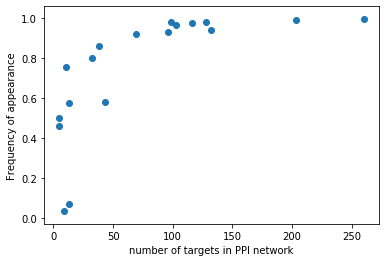

In [37]:
# Plot frequency of appearance versus number of targets in PPI network
plt.figure()
plt.scatter(x=original_drugs['num_targets'], y=original_drugs['num_appearance'])
plt.xlabel('number of targets in PPI network')
plt.ylabel('Frequency of appearance')
plt.show()

In [38]:
# Display table of non original drugs with frequency of appearance after randomization
# in increasing order of frequency of appearance
# This table provides information on the specificity of the original drug list. If a non original drug has high 
# frequency of appearance, it means that the fact that the original analysis did not select that drug is meaningful.
# Otherwise, it does not provide more information than the fact that the givn drug is specific to a limited number of
# terminal configurations
non_original_drugs = pickle.load(open("../Save_RandomizeTerminals/non_original_drugs.pkl", "rb"))
non_original_drugs = non_original_drugs.sort_values(by='num_appearance', ascending=False, inplace=False)
min_num_appearance_original_drugs = min(original_drugs['num_appearance'])
non_original_drugs.loc[non_original_drugs['num_appearance'] >= min_num_appearance_original_drugs]

,drug,num_targets,num_terminal_targets,num_appearance,max_target_centrality
1106,palbociclib,13,0,0.741,0.037187
952,mifepristone,10,0,0.544,0.040043
1569,vemurafenib,4,0,0.393,0.011169
384,danazol,16,0,0.377,0.040043
1405,tacrolimus,13,1,0.290,0.008884
703,haloperidol,42,0,0.286,0.022021
170,bicalutamide,2,0,0.277,0.021005
345,clozapine,39,0,0.195,0.015421
1295,risperidone,36,0,0.188,0.015421
1381,sulconazole,25,0,0.186,0.018721


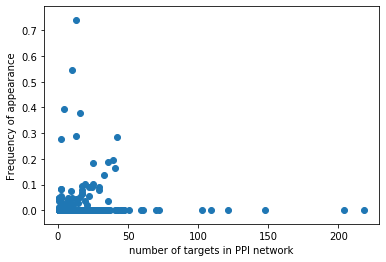

In [39]:
# Plot frequency of appearance versus number of targets in PPI network
plt.figure()
plt.scatter(x=non_original_drugs['num_targets'], y=non_original_drugs['num_appearance'])
plt.xlabel('number of targets in PPI network')
plt.ylabel('Frequency of appearance')
plt.show()

In [40]:
# Number of non selected drugs that appear at least as frequently as the least frequent selected drug 
print(len(non_original_drugs.loc[non_original_drugs['num_appearance'] >= min_num_appearance_original_drugs]))
# Compute percentage of non selected drugs that appear at least as frequently as the least frequent selected drug
print(len(non_original_drugs.loc[non_original_drugs['num_appearance'] >= min_num_appearance_original_drugs])/len(non_original_drugs))

41
0.025593008739076155


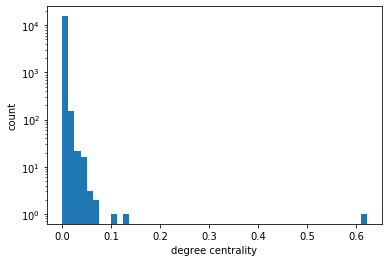

DescribeResult(nobs=15759, minmax=(6.345982992765579e-05, 0.6216524939713162), mean=0.0014658056940787115, variance=3.5573591503608185e-05, skewness=73.34915319443462, kurtosis=7441.827114495687)

In [41]:
# Plot distribution of degree centralities in the network
plt.figure()
plt.hist(centrality_dic.values(), bins=50)
plt.yscale('log')
plt.xlabel('degree centrality')
plt.ylabel('count')
plt.show()
ss.describe(list(centrality_dic.values()))